# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




##  Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [136]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
import warnings
from time import time
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform
import sklearn.metrics

# <b><u> Section 1: T-SNE on Amazon food reviews</u></b>



In [2]:
#get the dataset or dataframe
con = sqlite3.connect("Amazon Food reviews dataset.sqlite")
dataframe = pd.read_sql_query("Select * from Reviews where Score != 3", con)
con.close()
print(dataframe.shape)
#dataframe.head(3)

(525814, 10)


In [3]:
#now convert the reviews as positive and negative based on score value as following

#first create a transform function
def ConvertScores(score):
    """convert the numerical score to either positive or negative score
    """
    if(score <= 2):
        return 0
    else:
        return 1

scores = dataframe["Score"]
score_conv = scores.map(ConvertScores)
dataframe["Score"] = score_conv
#dataframe.head(5) #print top 5 rows to make sure conversion happened

### <u>1.1: Performing initial data cleaning text</u>

In [4]:
#perform data cleaning on the dataframe obtained
sorted_data = dataframe.sort_values("ProductId",axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#remove duplicate reviews
deduplicated_data = dataframe.drop_duplicates(subset={'UserId', 'Time', 'Summary'}, keep='first', inplace=False)
print(deduplicated_data.shape)


(363186, 10)


In [5]:
#check percentage of data remaining
len(deduplicated_data)/len(dataframe) * 100

69.07119247490557

In [6]:
#perform more data cleaning
deduplicated_data = deduplicated_data[deduplicated_data.HelpfulnessDenominator >= deduplicated_data.HelpfulnessNumerator]
#final shape of cleaned data
print(deduplicated_data.shape)
#see how many positive and negative reviews are in the data
print(deduplicated_data["Score"].value_counts())

(363184, 10)
1    306170
0     57014
Name: Score, dtype: int64


Hence our data is imbalanced data

### <u>1.2: Performing text pre-processing</u>

In [7]:
#import nltk modules
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer

In [9]:
#convert to lowercase
cleaned_data = deduplicated_data
reviews = cleaned_data["Text"]
cleaned_data["Text"] = reviews.map(lambda x: x.lower())

In [11]:
#get stopwords to use later
stop_words = set(stopwords.words('English'))
#remove not and very from stopwords
stop_words.remove("not")
stop_words.remove("very")

In [12]:
#get snowball stemmer
sno = SnowballStemmer('english')
print("Done")

Done


In [13]:
#define methods to clean html and punctuations
import re
def RemoveHtml(text):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', text)
    return cleantext
def RemovePunc(text):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',text)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [15]:
#clean the reviews before converting them to vectors
import pdb
from tqdm import tqdm
cleaned_reviews = []
positive_words = []
negative_words=[]
for idx,review in enumerate(tqdm(cleaned_data["Text"].values)):
    review = RemoveHtml(review)
    review = RemovePunc(review)
    words = review.split()
    stemmed_words=[]
    for word in words:
        if(len(word) > 2 and word not in stop_words):
            stemmed = (sno.stem(word)).encode('utf-8')
            #print(stemmed)
            stemmed_words.append(stemmed)
            if(cleaned_data.iloc[idx,6] == 1):
                positive_words.append(stemmed)
            else:
                negative_words.append(stemmed)
        else:
            continue
    #print(stemmed_words)
    stemmed_review = b" ".join(stemmed_words)   
    cleaned_reviews.append(stemmed_review)
    #pdb.set_trace()
print("done")



100%|█████████████████████████████████████████████████████████████████████████| 363184/363184 [13:34<00:00, 445.98it/s]


done


In [15]:
#store data in cleaned.sqlite
cleaned_data["Cleaned_Text"] = cleaned_reviews
cleaned_data["Cleaned_Text"] = cleaned_data["Cleaned_Text"].str.decode('utf-8')
conn = sqlite3.connect("cleaned.sqlite")
c = conn.cursor()
con.text_factory = str
cleaned_data.to_sql('Reviews', conn, schema=None,if_exists='replace',\
                   index=True, index_label=None, chunksize = None, dtype=None)
conn.close()


In [17]:
#serialize positive and negative reviews using pickle
import pickle
with open('all_positive_words.pkl','wb') as f:
    pickle.dump(positive_words, f)
with open('all_negative_words.pkl','wb') as f:
    pickle.dump(negative_words, f)

In [14]:
import os
import sqlite3
import pandas as pd
con = sqlite3.connect("cleaned.sqlite")
 #get 5000 records 
final = pd.read_sql_query("select Cleaned_Text,Score from Reviews where Score != 3 limit 5000", con)
con.close()
print(final.shape)

(5000, 2)


### <u>1.3: Vectorize using BOW</u>

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
bow_vector = cv.fit_transform(final.iloc[:,0])
print("the type of count vectorizer ",type(bow_vector))
print("the shape of out text BOW vectorizer ",bow_vector.get_shape())
print("the number of unique words ", bow_vector.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 9623)
the number of unique words  9623


In [5]:
#analyzing positive and negative words
import nltk
import pickle
with open('all_positive_words.pkl','rb') as f:
    positive_words = pickle.load(f)
with open('all_negative_words.pkl','rb') as f:
    negative_words = pickle.load(f)
#freq_dist_pos = nltk.FreqDist(positive_words)
#freq_dist_neg = nltk.FreqDist(negative_words)
#print("Most Common Positive Words : ",freq_dist_pos.most_common(20))
#print("Most Common Negative Words : ",freq_dist_neg.most_common(20))

In [10]:
# defining visualization method which will be used throughout the assignment
import seaborn as sns
def VisualizeTsne(vectorizer,tsne_data, score):
    tsne_data = np.vstack((tsne_data.T,score)).T
    tsne_df=pd.DataFrame(tsne_data, columns=('Dim1', 'Dim2', 'Score'))
    sns.FacetGrid(tsne_df, hue='Score', size=6).map(plt.scatter,'Dim1','Dim2').add_legend()
    plt.title('T-sne on Amazon food reviews vectorized using ' +vectorizer)
    plt.show()

### <u>1.4: Implementing T-SNE on BOW</u>

In [7]:
#standardize the data befor performing tsne
from sklearn.preprocessing import StandardScaler
bow_std = StandardScaler().fit_transform(bow_vector.toarray())
print(bow_std.shape)

(5000, 9623)


In [8]:
#train tsne with default parameter values
from sklearn.manifold import TSNE as tsne
model = tsne(n_components=2)
tsne_data = model.fit_transform(bow_std)
print("tsne Model trained")

tsne Model trained


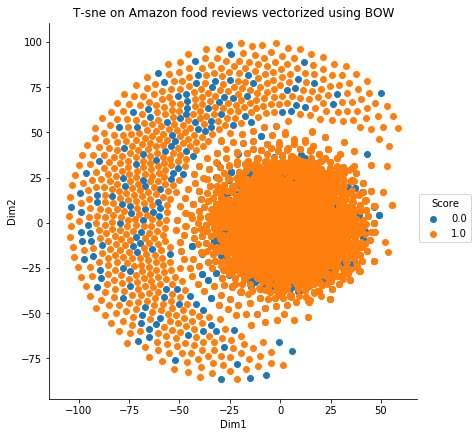

In [12]:
#visualizing the results of tsne
score =  final.iloc[:,1]
VisualizeTsne("BOW",tsne_data, score)

### <u>Conclusion</u>
We can conclude that the negative and positive reviews are highly overlapping and there is no clear separation visible with BOW. Furthermore it is hard to identify any pattern in the data visually

### <u>1.5: Vectorize using TF-IDF</u>

In [13]:
#implement uni-gram tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
tfidf_data = tfidf_vect.fit_transform(final["Cleaned_Text"].values)
print("the type of count vectorizer ",type(tfidf_data))
print("the shape of out text TFIDF vectorizer ",tfidf_data.get_shape())
print("the number of unique words are ", tfidf_data.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5000, 9623)
the number of unique words are  9623


### <u>1.6: Implementing T-SNE on TF-IDF</u>

In [14]:
#standardize tfidf vector before applying tsne
sc = StandardScaler()
tfidf_std = sc.fit_transform(tfidf_data.toarray())
print(tfidf_std.shape)

(5000, 9623)


In [15]:
#train tsne with default parameters
model = tsne(n_components=2)
tsne_data = model.fit_transform(tfidf_std)
print("tsne model trained on tfidf vector")

tsne model trained on tfidf vector


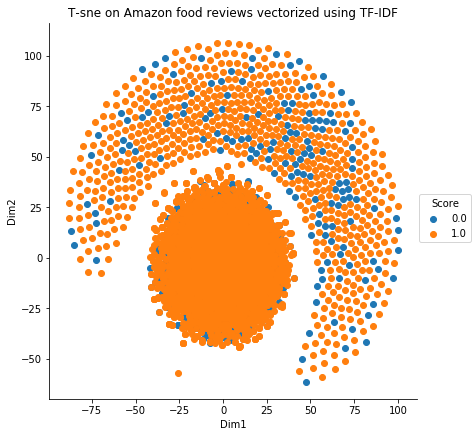

In [16]:
#visualizing the results of tsne
VisualizeTsne("TF-IDF",tsne_data, score)

### <u>Conclusion</u>
We can conclude that the negative and positive reviews are highly overlapping and there is no clear separation visible with tf-idf. Furthermore it is hard to identify any pattern in the data visually

### <u>1.7: Train Word2Vec</u>

In [1]:
import os
import sqlite3
import pandas as pd
con = sqlite3.connect("cleaned.sqlite")
#Note: here I am taking whole 364k records for training model since we will have less dimensions with w2v 
final = pd.read_sql_query("select Cleaned_Text,Score from Reviews where Score != 3", con)
con.close()

In [3]:
list_of_reviews = []
for review in final["Cleaned_Text"].values:
    list_of_reviews.append(review.split())        

In [7]:
from gensim.models import Word2Vec
#training our own w2v model
w2v_model = Word2Vec(list_of_reviews,min_count=5,size=100, workers=4)
print("word2vec trained")

word2vec trained


In [11]:
w2v_words = list(w2v_model.wv.vocab)

### <u>1.8: Vectorize using average Word2Vec</u>

In [21]:
#writing code to vectorize using avg w2v
from tqdm import tqdm
review_word_vector = []
for review in tqdm(list_of_reviews):
    w2v_vector = np.zeros(100)
    for word in review:
        word_count = 0
        if(word in w2v_words):
            w2v_vector += w2v_model.wv[word]
            word_count += 1
    if word_count != 0:
        w2v_vector /= word_count
    review_word_vector.append(w2v_vector)
print(len(review_word_vector))
print(len(review_word_vector[0]))

100%|█████████████████████████████████████████████████████████████████████████| 363184/363184 [11:35<00:00, 521.86it/s]


363184
100


### <u>1.9: Implementing T-SNE on Average Word2Vec</u>

In [22]:
#standardize w2v
sc = StandardScaler()
review_word_vector = sc.fit_transform(review_word_vector)

In [23]:
#serializing the avg w2v for later use
import pickle
with open("avg_w2v_all_100dim.pkl","wb") as f:
    pickle.dump(review_word_vector,f)

In [20]:
with open("avg_w2v_all_100dim.pkl","rb") as f:
#with open("review_word_vector.pkl","rb") as f:
    review_word_vector = pickle.load(f)

In [21]:
#train tsne model with default params on avg w2v of 5000 data points
model = tsne(n_components = 2)
tsne_data = model.fit_transform(review_word_vector[0:5000,:])
print("tsne model trained with default params on avg word2vec")

tsne model trained with default params on avg word2vec


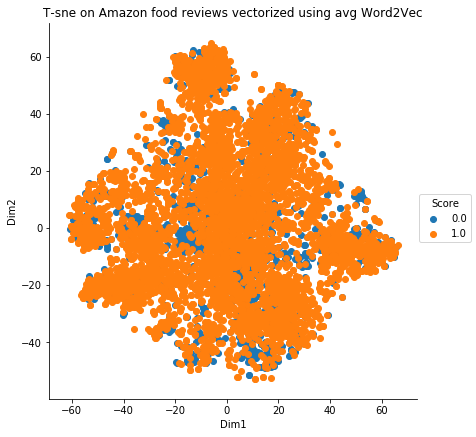

In [22]:
#visualizing the results of tsne
VisualizeTsne("avg Word2Vec",tsne_data, score)

### <u>Conclusion</u>
We can conclude that the negative and positive reviews are highly overlapping and there is no clear separation visible with avg w2v. Furthermore it is hard to identify any pattern in the data visually

### <u>1.10: Vectorize using TFIDF weighted Word2Vec</u>

In [8]:
#save tfidf scores of all the cleaned words from all the reviews in a dictionary
from sklearn.feature_extraction.text import TfidfVectorizer
model = TfidfVectorizer()
tfidf_data =  model.fit_transform(final["Cleaned_Text"].values)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [14]:
#import pdb
#code to vectorize reviews using tf-idf w2v
from tqdm import tqdm
tfidf_feat = model.get_feature_names() # tfidf words/col-names
tfidf_w2v = []
for row,review in enumerate(tqdm(list_of_reviews)):
    review_vect = np.zeros(100)
    tfidf_sum = 0
    for word in review:
        if(word in w2v_words and word in dictionary):
            #tf_idf = tfidf_data[row, tfidf_feat.index(word)]
            tf_idf = dictionary[word] * review.count(word)/len(review)
            tfidf_sum += tf_idf
            #pdb.set_trace()
            review_vect += w2v_model.wv[word] * tf_idf
    if tfidf_sum != 0:
        review_vect /= tfidf_sum
    tfidf_w2v.append(review_vect)
print("tfidf w2v prepared")

100%|█████████████████████████████████████████████████████████████████████████| 363184/363184 [21:04<00:00, 287.32it/s]


tfidf w2v prepared


In [38]:
#standardize tfidf w2v
sc = StandardScaler()
tfidf_w2v = sc.fit_transform(tfidf_w2v)

In [39]:
#serializing the tdidf w2v for later use
import pickle
with open("tfidf_w2v_all_100dim.pkl","wb") as f:
    pickle.dump(tfidf_w2v,f)

In [24]:
with open("tfidf_w2v_all_100dim.pkl","rb") as f:
    tfidf_w2v = pickle.load(f)

In [25]:
#train tsne model with default params on tfidf-w2v of 5000 data points
from sklearn.manifold import TSNE as tsne
model = tsne(n_components = 2)
tsne_data = model.fit_transform(tfidf_w2v[0:5000,:])
print("tsne model trained with default params on tfidf word2vec")

tsne model trained with default params on tfidf word2vec


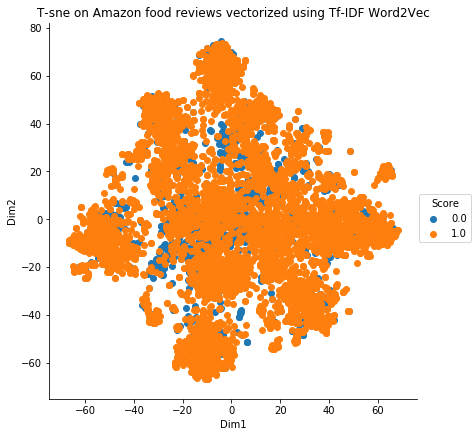

In [26]:
#visualizing the results of tsne
VisualizeTsne("Tf-IDF Word2Vec",tsne_data, score)

### <u>Conclusion</u>
We can conclude that the negative and positive reviews are highly overlapping and there is no clear separation visible with tfidf-w2v. Furthermore it is hard to identify any pattern in the data visually

# <b><u>Section 2: KNN on Amazon Fine Food reviews</u></b>

<b>Defining some methods that we will use throughout this section:</b>

In [2]:
import time
#from tqdm import tqdm_notebook
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.model_selection import cross_val_score
def KNN_KFold_Val(neighbors, X_train, y_train, cv, algorithm = 'auto'):
    """performs k fold cross validation for knn classifier and returns cross validation scores"""
    cv_scores = []
    start = time.time()
    for neighbors in tqdm(neighbors):
        knnc = knn(n_neighbors = neighbors, algorithm = algorithm)
        scores = cross_val_score(knnc, X_train, y_train, cv=10, scoring='recall')
        cv_scores.append(scores.mean())
    end = time.time()
    print("Time taken to execute is " + str(end - start) + " seconds")
    return cv_scores

In [3]:
#from tqdm import tqdm_notebook
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.metrics import accuracy_score
def KNNCrossVal(neighbors, X_train, y_train,X_val, y_val, algorithm = 'auto'):
    """performs k fold cross validation for knn classifier and returns cross validation scores"""
    cv_scores = []
    for neighbors in tqdm(neighbors):
        knnc = knn(n_neighbors = neighbors, algorithm = algorithm)
        knnc.fit(X_train, y_train)
        yval_pred = knnc.predict(X_val)
        acc = accuracy_score(y_val, yval_pred, normalize=True) * float(100)
        cv_scores.append(acc)
    return cv_scores

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier as knn
def CheckTestAccuracy(X_train, y_train,n_neighbors, X_test, y_test, algorithm = 'auto'):
    """Returns the test accuracy for given k"""
    knnc = knn(n_neighbors = n_neighbors)
    knnc.fit(X_train, y_train)
    ytest_pred = knnc.predict(X_test)
    acc = accuracy_score(y_test, ytest_pred, normalize=True) * float(100)
    return acc

In [5]:
def PlotMSE(neighbors, cv_scores, vector_type):
    """plotting misclassification error against given k values"""
    MSE = [1-x for x in cv_scores]
    plt.plot(neighbors, MSE)
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.title("Misclassification error vs K-Neighbors plot for " + vector_type)
    plt.show()


In [6]:
#get the data from pre-processed or cleaned data that we saved in the previous assignment
import os
con = sqlite3.connect('cleaned.sqlite')
data = pd.read_sql_query("Select Cleaned_Text,Score from Reviews where Score != 3 order by Time limit 100000", con)
con.close()

In [7]:
print(data.shape)

(100000, 2)


In [8]:
X = data.iloc[:,0]
y = data.iloc[:, 1]

In [9]:
#splitting train,test and val
X1,X_test,y1,y_test = train_test_split(X, y, test_size = 0.3,shuffle = False, random_state = 0)
X_train,X_val,y_train,y_val = train_test_split(X1, y1, test_size = 0.3,shuffle = False, random_state = 0)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(49000,)
(21000,)
(30000,)


# <u>Part 1: Implementing KNN with Brute method</u>

## <u>2.1.1: KNN (Brute) on BOW</u>

In [10]:
#generating uni-gram BOW
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_BOW_train = cv.fit_transform(X_train)
print(X_BOW_train.shape)

(49000, 30898)


In [11]:
#tranforming X_val to BOW
X_BOW_val = cv.transform(X_val)
print(X_BOW_val.shape)

(21000, 30898)


In [62]:
#Performin brute force KNN with simple cross validation on BOW
neighbors = np.arange(1,31,4)
cv_scores = KNNCrossVal(neighbors, X_BOW_train, y_train, X_BOW_val, y_val, "brute")
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
#print(cv_scores)
print('\nOptimal value of k = %d with accuracy of %d%%' % (optimal_k, max(cv_scores)))

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [09:48<00:00, 73.92s/it]



Optimal value of k = 13 with accuracy of 87%


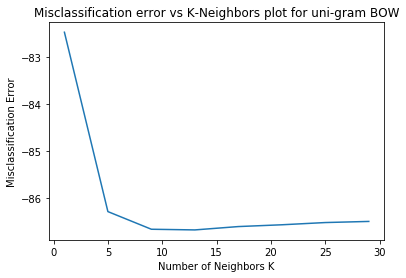

In [63]:
#plotting misclassification error against k values
PlotMSE(neighbors, cv_scores, "uni-gram BOW")

In [12]:
#tranforming X_val to BOW
X_BOW_test = cv.transform(X_test)
print(X_BOW_test.shape)

(30000, 30898)


In [13]:
#check the test accuracy for uni-gram bow
test_acc = CheckTestAccuracy(X_BOW_train, y_train,optimal_k, X_BOW_test, y_test, "brute")
print('\nTest accuracy on uni-gram BOW for k = %d is %d%%' % (optimal_k, test_acc))


Test accuracy on uni-gram BOW for k = 13 is 86%


### <u>2.1.2: KNN (brute) on TFIDF Vector </u>

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
X_tfidf_train = tfidf_vect.fit_transform(X_train)
print(X_tfidf_train.shape)

(49000, 30898)


In [15]:
#tranforming X_val to tfidf
X_tfidf_val = tfidf_vect.transform(X_val)
print(X_tfidf_val.shape)

(21000, 30898)


In [68]:
#Performin brute force KNN with simple cross validation on BOW
neighbors = np.arange(1,31,4)
cv_scores = KNNCrossVal(neighbors, X_tfidf_train, y_train, X_tfidf_val, y_val, "brute")
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
#print(cv_scores)
print('\nOptimal value of k = %d with accuracy of %d%%' % (optimal_k, max(cv_scores)))

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [10:53<00:00, 81.94s/it]



Optimal value of k = 9 with accuracy of 88%


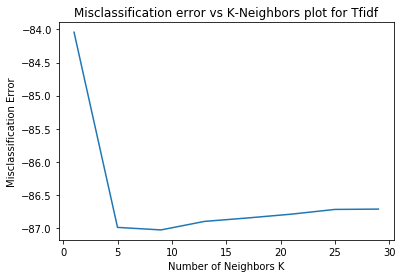

In [69]:
#plotting misclassification error on tfidf against k values
PlotMSE(neighbors, cv_scores, "Tfidf")

In [16]:
#tranforming X_val to tfidf
X_tfidf_test = tfidf_vect.transform(X_test)
print(X_tfidf_test.shape)

(30000, 30898)


In [17]:
#check the test accuracy for tfidf
test_acc = CheckTestAccuracy(X_tfidf_train, y_train,optimal_k, X_tfidf_test, y_test, "brute")
print('\nTest accuracy on tfidf for k = %d is %d%%' % (optimal_k, test_acc))


Test accuracy on tfidf for k = 9 is 87%


### <u>2.1.3: KNN (brute) on Average Word2Vec</u>

In [72]:
def Get_List_Reviews(X_type):
    """get list of words for all review for the given X_type"""
    list_of_reviews = []
    for review in X_type.values:
        list_of_reviews.append(review.split())
    return list_of_reviews

In [73]:
#converting X_train into list of words for each review
list_of_reviews_train = Get_List_Reviews(X_train)
print(len(list_of_reviews_train))

49000


In [74]:
#converting X_val into list of words for each review
list_of_reviews_val = Get_List_Reviews(X_val)
print(len(list_of_reviews_val))

21000


In [75]:
#converting X_test into list of words for each review
list_of_reviews_test = Get_List_Reviews(X_test)
print(len(list_of_reviews_test))

30000


In [83]:
from gensim.models import Word2Vec
#train avg w2v on list_of_reviews_train
w2v_model = Word2Vec(list_of_reviews_train, min_count=4,size=300, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [20]:
#writing code to generate X_avgw2v_type using avg w2v
def Get_Avg_W2v(list_of_reviews):
    from tqdm import tqdm
    review_word_vector = []
    for review in tqdm(list_of_reviews):
        w2v_vector = np.zeros(300)
        for word in review:
            word_count = 0
            if(word in w2v_words):
                w2v_vector += w2v_model.wv[word]
                word_count += 1
        if word_count != 0:
            w2v_vector /= word_count
        review_word_vector.append(w2v_vector)
    return review_word_vector

In [131]:
#get avg w2v for train data
X_avgw2v_train = Get_Avg_W2v(list_of_reviews_train)
print(len(X_avgw2v_train))
print(len(X_avgw2v_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 49000/49000 [01:55<00:00, 424.51it/s]


49000
300


In [132]:
#serializing the avg w2v train for later use
import pickle
with open("X_avgw2v_train_100k_300dim.pkl","wb") as f:
    pickle.dump(X_avgw2v_train,f)

In [27]:
#loading avg w2v train saved earlier
import pickle
with open("X_avgw2v_train_100k_300dim.pkl","rb") as f:
    X_avgw2v_train = pickle.load(f)

In [133]:
#get avg w2v for cross validation data
X_avgw2v_val = Get_Avg_W2v(list_of_reviews_val)
print(len(X_avgw2v_val))
print(len(X_avgw2v_val[0]))

100%|███████████████████████████████████████████████████████████████████████████| 21000/21000 [00:51<00:00, 409.34it/s]


21000
300


In [134]:
#serializing the avg w2v val for later use
with open("X_avgw2v_val_100k_300dim.pkl","wb") as f:
    pickle.dump(X_avgw2v_val,f)

In [77]:
#loading avg w2v val saved previously
with open("X_avgw2v_val_100k_300dim.pkl","rb") as f:
    X_avgw2v_val = pickle.load(f)

In [78]:
#Performin brute force KNN with simple cross validation on avg w2v
neighbors = np.arange(1,31,4)
cv_scores = KNNCrossVal(neighbors, X_avgw2v_train, y_train, X_avgw2v_val, y_val, "brute")
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
#print(cv_scores)
print('\nOptimal value of k = %d with accuracy of %d%%' % (optimal_k, max(cv_scores)))

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [05:04<00:00, 39.04s/it]



Optimal value of k = 13 with accuracy of 88%


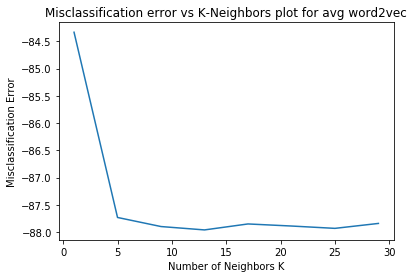

In [79]:
#plotting misclassification error on avg w2v against k values
PlotMSE(neighbors, cv_scores, "avg word2vec")

In [137]:
#get avg w2v for test data
X_avgw2v_test = Get_Avg_W2v(list_of_reviews_test)
print(len(X_avgw2v_test))
print(len(X_avgw2v_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:12<00:00, 412.20it/s]


30000
300


In [138]:
#serializing the avg w2v test for later use
with open("X_avgw2v_test_100k_300dim.pkl","wb") as f:
    pickle.dump(X_avgw2v_test,f)

In [28]:
#loading avg w2v val saved previously
with open("X_avgw2v_test_100k_300dim.pkl","rb") as f:
    X_avgw2v_test = pickle.load(f)

In [29]:
#check the test accuracy for avg w2v
test_acc = CheckTestAccuracy(X_avgw2v_train, y_train,optimal_k, X_avgw2v_test, y_test, "brute")
print('\nTest accuracy on avg w2v for k = %d is %d%%' % (optimal_k, test_acc))


Test accuracy on avg w2v for k = 13 is 88%


### <u>2.1.4: KNN on TFIDF Word2Vec</u>

In [82]:
#save tfidf scores of all the cleaned words from all the reviews in a dictionary
dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))

In [84]:
#code to vectorize reviews using tf-idf w2v
def Get_Tfidfw2v_Vector(list_of_reviews):
    from tqdm import tqdm
    tfidf_feat = tfidf_vect.get_feature_names() # tfidf words/col-names
    tfidf_w2v = []
    for row,review in enumerate(tqdm(list_of_reviews)):
        review_vect = np.zeros(300)
        tfidf_sum = 0
        for word in review:
            if(word in w2v_words and word in dictionary):
                #tf_idf = tfidf_data[row, tfidf_feat.index(word)]
                tf_idf = dictionary[word] * review.count(word)/len(review)
                tfidf_sum += tf_idf
                #pdb.set_trace()
                review_vect += w2v_model.wv[word] * tf_idf
        if tfidf_sum != 0:
            review_vect /= tfidf_sum
        tfidf_w2v.append(review_vect)
    return tfidf_w2v

In [85]:
#get tfidf w2v for train data
X_tfidfw2v_train = Get_Tfidfw2v_Vector(list_of_reviews_train)
print(len(X_tfidfw2v_train))

100%|███████████████████████████████████████████████████████████████████████████| 49000/49000 [02:08<00:00, 382.16it/s]


49000


In [46]:
#serializing the tfidf w2v train for later use
with open("X_tfidfw2v_train_100k_300dim.pkl","wb") as f:
    pickle.dump(X_tfidfw2v_train,f)

In [21]:
#loading tfidf w2v train saved previously
with open("X_tfidfw2v_train_100k_300dim.pkl","rb") as f:
    X_tfidfw2v_train = pickle.load(f)

In [86]:
#get avg tfidf for cross validation data
X_tfidfw2v_val = Get_Tfidfw2v_Vector(list_of_reviews_val)
print(len(X_tfidfw2v_val))

100%|███████████████████████████████████████████████████████████████████████████| 21000/21000 [00:58<00:00, 359.96it/s]


21000


In [49]:
#serializing the tfidf w2v val for later use
with open("X_tfidfw2v_val_100k_300dim.pkl","wb") as f:
    pickle.dump(X_tfidfw2v_val,f)

In [22]:
#loading tfidf w2v val saved previously
with open("X_tfidfw2v_val_100k_300dim.pkl","rb") as f:
    X_tfidfw2v_val = pickle.load(f)

In [87]:
#Performin brute force KNN with simple cross validation on avg w2v
neighbors = np.arange(1,31,4)
cv_scores = KNNCrossVal(neighbors, X_tfidfw2v_train, y_train, X_tfidfw2v_val, y_val, "brute")
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
#print(cv_scores)
print('\nOptimal value of k = %d with accuracy of %d%%' % (optimal_k, max(cv_scores)))

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [05:38<00:00, 42.63s/it]



Optimal value of k = 13 with accuracy of 88%


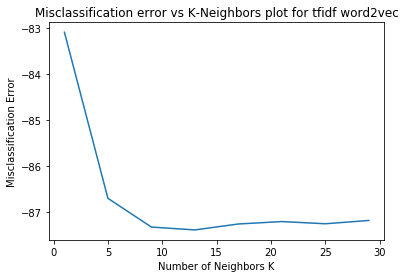

In [88]:
#plotting misclassification error on avg w2v against k values
PlotMSE(neighbors, cv_scores, "tfidf word2vec")

In [89]:
#get avg tfidf w2v for test data
X_tfidfw2v_test = Get_Tfidfw2v_Vector(list_of_reviews_test)
print(len(X_tfidfw2v_test))

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:14<00:00, 401.34it/s]


30000


In [54]:
#serializing the tfidf w2v test for later use
with open("X_tfidfw2v_test_100k_300dim.pkl","wb") as f:
    pickle.dump(X_tfidfw2v_test,f)

In [24]:
#loading avg tfidf w2v test saved previously
with open("X_tfidfw2v_test_100k_300dim.pkl","rb") as f:
    X_tfidfw2v_test = pickle.load(f)

In [26]:
#check the test accuracy for tfidf w2v
test_acc = CheckTestAccuracy(X_tfidfw2v_train, y_train,optimal_k, X_tfidfw2v_test, y_test, "brute")
print('\nTest accuracy on tfidf w2v for k = %d is %d%%' % (optimal_k, test_acc))


Test accuracy on tfidf w2v for k = 13 is 87%


## <u>Summary:</u><br/>
<table>
    <tr>
        <th>Vectorizer</th>
        <th>Algorithm</th>
        <th>Best K value</th>
        <th>Test Accuracy</th>
    </tr>
    <tr>
        <td>BOW</td>
        <td>Brute</td>
        <td>13</td>
        <td>86%</td>
    </tr>
    <tr>
        <td>TFIDF</td>
        <td>Brute</td>
        <td>9</td>
        <td>87%</td>
    </tr>
    <tr>
        <td>Avg W2V</td>
        <td>Brute</td>
        <td>13</td>
        <td>88%</td>
    </tr>
    <tr>
        <td>TFIDF W2V</td>
        <td>Brute</td>
        <td>13</td>
        <td>87%</td>
    </tr>
    </table>

# <u>Part 2: Implementing KNN with Kd_Tree algorithm</u>

#### <u>Note</u>:  Due to time complexity of kd tree algorithm, I will run KNN with kd_tree only on avg Word2Vec and TFIDF-Word2Vec using 60k data points in total

In [4]:
#get the data from pre-processed or cleaned data that we saved in the previous assignment
import os
con = sqlite3.connect('cleaned.sqlite')
#Here I am taking the 60k records to make the kd_tree run faster
data = pd.read_sql_query("Select Cleaned_Text,Score from Reviews where Score != 3 order by Time limit 60000", con)
con.close()

In [5]:
X = data.iloc[:,0]
y = data.iloc[:, 1]

In [6]:
#splitting train,test and val
X1,X_test,y1,y_test = train_test_split(X, y, test_size = 0.3,shuffle = False, random_state = 0)
X_train,X_val,y_train,y_val = train_test_split(X1, y1, test_size = 0.3,shuffle = False, random_state = 0)

### <u>2.2.1: KNN (kd_tree) on Average Word2Vec</u>

In [15]:
#converting X_train into list of words for each review
list_of_reviews_train = Get_List_Reviews(X_train)
print(len(list_of_reviews_train))

29400


In [16]:
#converting X_val into list of words for each review
list_of_reviews_val = Get_List_Reviews(X_val)
print(len(list_of_reviews_val))

12600


In [17]:
#converting X_test into list of words for each review
list_of_reviews_test = Get_List_Reviews(X_test)
print(len(list_of_reviews_test))

18000


In [18]:
from gensim.models import Word2Vec
#train avg w2v on list_of_reviews_train
w2v_model = Word2Vec(list_of_reviews_train, min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("w2v model trained")

w2v model trained


In [19]:
#writing code to generate X_avgw2v_type using avg w2v
def Get_Avg_W2v(list_of_reviews):
    from tqdm import tqdm
    review_word_vector = []
    for review in tqdm(list_of_reviews):
        w2v_vector = np.zeros(50)
        for word in review:
            word_count = 0
            if(word in w2v_words):
                w2v_vector += w2v_model.wv[word]
                word_count += 1
        if word_count != 0:
            w2v_vector /= word_count
        review_word_vector.append(w2v_vector)
    return review_word_vector

In [20]:
#get avg w2v for train data
X_avgw2v_train = Get_Avg_W2v(list_of_reviews_train)
print(len(X_avgw2v_train))
print(len(X_avgw2v_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 29400/29400 [00:51<00:00, 574.05it/s]


29400
50


In [21]:
#serializing the avg w2v train for later use
import pickle
with open("X_avgw2v_train_60k_50dim.pkl","wb") as f:
    pickle.dump(X_avgw2v_train,f)

In [22]:
#loading avg w2v train saved earlier
import pickle
with open("X_avgw2v_train_60k_50dim.pkl","rb") as f:
    X_avgw2v_train = pickle.load(f)

In [23]:
#get avg w2v for cross validation data
X_avgw2v_val = Get_Avg_W2v(list_of_reviews_val)
print(len(X_avgw2v_val))
print(len(X_avgw2v_val[0]))

100%|███████████████████████████████████████████████████████████████████████████| 12600/12600 [00:21<00:00, 590.07it/s]


12600
50


In [24]:
#serializing the avg w2v val for later use
import pickle
with open("X_avgw2v_val_60k_50dim.pkl","wb") as f:
    pickle.dump(X_avgw2v_val,f)

In [25]:
#loading avg w2v val saved previously
with open("X_avgw2v_val_60k_50dim.pkl","rb") as f:
    X_avgw2v_val = pickle.load(f)

In [29]:
#Performin kd_tree KNN with simple cross validation on avg w2v
neighbors = np.arange(1,31,4)
cv_scores = KNNCrossVal(neighbors, X_avgw2v_train, y_train, X_avgw2v_val, y_val, "kd_tree")
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
#print(cv_scores)
print('\nOptimal value of k = %d with accuracy of %d%%' % (optimal_k, max(cv_scores)))

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [08:36<00:00, 66.08s/it]



Optimal value of k = 13 with accuracy of 89%


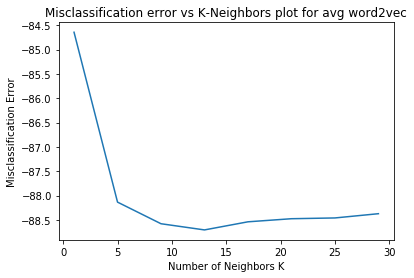

In [30]:
#plotting misclassification error on avg w2v against k values
PlotMSE(neighbors, cv_scores, "avg word2vec")

In [26]:
#get avg w2v for test data
X_avgw2v_test = Get_Avg_W2v(list_of_reviews_test)
print(len(X_avgw2v_test))
print(len(X_avgw2v_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 18000/18000 [00:31<00:00, 566.85it/s]


18000
50


In [27]:
#serializing the avg w2v test for later use
import pickle
with open("X_avgw2v_test_60k_50dim.pkl","wb") as f:
    pickle.dump(X_avgw2v_test,f)

In [28]:
#loading avg w2v test saved previously
with open("X_avgw2v_test_60k_50dim.pkl","rb") as f:
    X_avgw2v_test = pickle.load(f)

In [32]:
#check the test accuracy for avg w2v
test_acc = CheckTestAccuracy(X_avgw2v_train, y_train,optimal_k, X_avgw2v_test, y_test, "kd_tree")
print('\nTest accuracy on avg w2v for k = %d is %d%%' % (optimal_k, test_acc))


Test accuracy on avg w2v for k = 13 is 88%


### <u>2.2.2: KNN (kd_tree) on TFIDF Word2Vec</u>

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
X_tfidf_train = tfidf_vect.fit_transform(X_train)

In [34]:
#save tfidf scores of all the cleaned words from all the reviews in a dictionary
dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))

In [37]:
#code to vectorize reviews using tf-idf w2v
def Get_Tfidfw2v_Vector(list_of_reviews):
    from tqdm import tqdm
    tfidf_feat = tfidf_vect.get_feature_names() # tfidf words/col-names
    tfidf_w2v = []
    for row,review in enumerate(tqdm(list_of_reviews)):
        review_vect = np.zeros(50)
        tfidf_sum = 0
        for word in review:
            if(word in w2v_words and word in dictionary):
                #tf_idf = tfidf_data[row, tfidf_feat.index(word)]
                tf_idf = dictionary[word] * review.count(word)/len(review)
                tfidf_sum += tf_idf
                #pdb.set_trace()
                review_vect += w2v_model.wv[word] * tf_idf
        if tfidf_sum != 0:
            review_vect /= tfidf_sum
        tfidf_w2v.append(review_vect)
    return tfidf_w2v

In [38]:
#get tfidf w2v for train data
X_tfidfw2v_train = Get_Tfidfw2v_Vector(list_of_reviews_train)
print(len(X_tfidfw2v_train))

100%|███████████████████████████████████████████████████████████████████████████| 29400/29400 [01:00<00:00, 484.40it/s]


29400


In [39]:
#serializing the tfidf w2v train for later use
with open("X_tfidfw2v_train_60k_50dim.pkl","wb") as f:
    pickle.dump(X_tfidfw2v_train,f)

In [40]:
#loading tfidf w2v train saved previously
with open("X_tfidfw2v_train_60k_50dim.pkl","rb") as f:
    X_tfidfw2v_train = pickle.load(f)

In [41]:
#get avg tfidf for cross validation data
X_tfidfw2v_val = Get_Tfidfw2v_Vector(list_of_reviews_val)
print(len(X_tfidfw2v_val))

100%|███████████████████████████████████████████████████████████████████████████| 12600/12600 [00:26<00:00, 481.58it/s]


12600


In [42]:
#serializing the tfidf w2v val for later use
with open("X_tfidfw2v_val_60k_50dim.pkl","wb") as f:
    pickle.dump(X_tfidfw2v_val,f)

In [43]:
#loading tfidf w2v val saved previously
with open("X_tfidfw2v_val_60k_50dim.pkl","rb") as f:
    X_tfidfw2v_val = pickle.load(f)

In [44]:
#Performin kd_tree KNN with simple cross validation on tfidf w2v
neighbors = np.arange(1,31,4)
cv_scores = KNNCrossVal(neighbors, X_tfidfw2v_train, y_train, X_tfidfw2v_val, y_val, "kd_tree")
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
#print(cv_scores)
print('\nOptimal value of k = %d with accuracy of %d%%' % (optimal_k, max(cv_scores)))

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [09:04<00:00, 70.19s/it]



Optimal value of k = 25 with accuracy of 89%


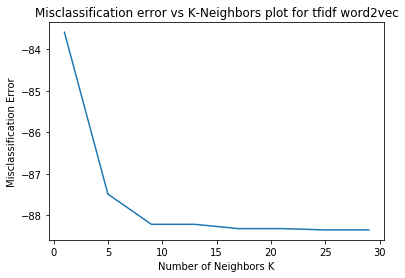

In [45]:
#plotting misclassification error on avg w2v against k values
PlotMSE(neighbors, cv_scores, "tfidf word2vec")

In [46]:
#get avg tfidf w2v for test data
X_tfidfw2v_test = Get_Tfidfw2v_Vector(list_of_reviews_test)
print(len(X_tfidfw2v_test))

100%|███████████████████████████████████████████████████████████████████████████| 18000/18000 [00:36<00:00, 487.08it/s]


18000


In [47]:
#serializing the tfidf w2v test for later use
with open("X_tfidfw2v_test_60k_50dim.pkl","wb") as f:
    pickle.dump(X_tfidfw2v_test,f)

In [48]:
#loading avg tfidf w2v test saved previously
with open("X_tfidfw2v_test_60k_50dim.pkl","rb") as f:
    X_tfidfw2v_test = pickle.load(f)

In [49]:
#check the test accuracy for tfidf w2v
test_acc = CheckTestAccuracy(X_tfidfw2v_train, y_train,optimal_k, X_tfidfw2v_test, y_test, "kd_tree")
print('\nTest accuracy on tfidf w2v for k = %d is %d%%' % (optimal_k, test_acc))


Test accuracy on tfidf w2v for k = 25 is 88%


## <u>Summary:</u><br/>
<table>
    <tr>
        <th>Vectorizer</th>
        <th>Algorithm</th>
        <th>Best K value</th>
        <th>Test Accuracy</th>
    </tr>
    <tr>
        <td>Avg W2V</td>
        <td>kd_tree</td>
        <td>13</td>
        <td>88%</td>
    </tr>
    <tr>
        <td>TFIDF W2V</td>
        <td>kd_tree</td>
        <td>25</td>
        <td>88%</td>
    </tr>
    </table>

# <b><u>Section 3: Naive Bayes on Amazon Fine Food Reviews</u></b>

In [1]:
#importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import sklearn.metrics
import warnings
warnings.filterwarnings("ignore")

##### <b><u>Note</u></b>: Defining some functions that we will use throughout this section

In [19]:
#from tqdm import tqdm_notebook
from tqdm import tqdm
#from tqdm.auto import tqdm
from sklearn.naive_bayes import MultinomialNB
def NBCrossVal(alphas, X_train, y_train,X_val, y_val, sample_weight, class_prior):
    """performs cross validation for MultinomialNB classifier and returns various cross validation scores for training
    and validation set
    """
    cv_acc_scores = []
    cv_prec_scores = []
    cv_recall_scores = []
    cv_f1_scores = []
    cv_auc_scores = []
    
    train_acc_scores = []
    train_prec_scores = []
    train_recall_scores = []
    train_f1_scores = []
    train_auc_scores = []
    
    for alpha in tqdm(alphas):
        mnb = MultinomialNB(alpha = alpha, class_prior = class_prior)
        mnb.fit(X_train, y_train, sample_weight = sample_weight)
        #train scores
        ytrain_pred = mnb.predict(X_train)
        ytrain_log_prob = mnb.predict_log_proba(X_train)
        acc = sklearn.metrics.accuracy_score(y_train, ytrain_pred, normalize=True) * float(100)
        prec = sklearn.metrics.precision_score(y_train, ytrain_pred) * float(100)
        recall = sklearn.metrics.recall_score(y_train, ytrain_pred) * float(100)
        f1 = sklearn.metrics.f1_score(y_train, ytrain_pred) * float(100)
        auc = sklearn.metrics.roc_auc_score(y_train, ytrain_log_prob[:,1]) * float(100)
        train_acc_scores.append(acc)
        train_prec_scores.append(prec)
        train_recall_scores.append(recall)
        train_f1_scores.append(f1)
        train_auc_scores.append(auc)
        #val scores
        yval_pred = mnb.predict(X_val)
        yval_log_prob = mnb.predict_log_proba(X_val)
        acc = sklearn.metrics.accuracy_score(y_val, yval_pred, normalize=True) * float(100)
        prec = sklearn.metrics.precision_score(y_val, yval_pred) * float(100)
        recall = sklearn.metrics.recall_score(y_val, yval_pred) * float(100)
        f1 = sklearn.metrics.f1_score(y_val, yval_pred) * float(100)
        auc = sklearn.metrics.roc_auc_score(y_val, yval_log_prob[:,1]) * float(100)
        cv_acc_scores.append(acc)
        cv_prec_scores.append(prec)
        cv_recall_scores.append(recall)
        cv_f1_scores.append(f1)
        cv_auc_scores.append(auc)
    return cv_acc_scores,cv_prec_scores,cv_recall_scores,cv_f1_scores,cv_auc_scores,train_acc_scores,train_prec_scores,train_recall_scores,train_f1_scores,train_auc_scores

In [18]:
from sklearn.naive_bayes import MultinomialNB
def CheckTestSetScores(X_train, y_train,alpha, X_test, y_test, sample_weight, class_prior):
    """Returns the scoring metrics for given alpha on MultinomialNB on test/val set"""
    mnb = MultinomialNB(alpha = alpha, class_prior = class_prior)
    mnb.fit(X_train, y_train, sample_weight = sample_weight)
    ytest_pred = mnb.predict(X_test)
    ytest_log_prob = mnb.predict_log_proba(X_test)
    acc = sklearn.metrics.accuracy_score(y_test, ytest_pred, normalize=True) * float(100)
    prec = sklearn.metrics.precision_score(y_test, ytest_pred) * float(100)
    recall = sklearn.metrics.recall_score(y_test, ytest_pred) * float(100)
    f1 = sklearn.metrics.f1_score(y_test, ytest_pred) * float(100)
    auc = sklearn.metrics.roc_auc_score(y_test, ytest_log_prob[:,1]) * float(100)
    conf_matrix = sklearn.metrics.confusion_matrix(y_test, ytest_pred)
    feature_log_prob = mnb.feature_log_prob_ 
    #print(conf_matrix)
    return acc,prec,recall,f1,auc,conf_matrix,feature_log_prob

In [4]:
def PlotTrainVsCVerror(alphas,train_scores, cv_scores, score_type):
    """plotting misclassification train and CV error against given alpha values for a given score metric"""
    MSE_train = [100-x for x in train_scores]
    MSE_cv = [100-x for x in cv_scores]
    #plt.xticks(np.arange(min(alphas), max(alphas)+1, 0.5))
    plt.figure(figsize=(10,5))
    plt.plot(alphas, MSE_train, 'r-', label= 'Train Error')
    plt.plot(alphas, MSE_cv, 'b-', label= 'CV Error')
    plt.xlabel('alphas')
    plt.ylabel('Misclassification Error')
    plt.title("Train & CV error plot for " + score_type)
    plt.legend(loc='best')
    plt.show()

In [34]:
def PlotRUC(alpha, X_train, y_train, X_val, y_val,sample_weight, class_prior):
    """plot RUC curve for validation/test data for a given alpha value"""
    mnb = MultinomialNB(alpha = alpha, class_prior = class_prior)
    mnb.fit(X_train, y_train, sample_weight = sample_weight)
    yval_pred = mnb.predict(X_val)
    yval_log_prob = mnb.predict_log_proba(X_val)
    fpr,tpr,thresholds = sklearn.metrics.roc_curve(y_val, yval_log_prob[:,1])
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title("RUC Curve")
    plt.show()

In [6]:
#get the data from pre-processed or cleaned data that we saved in the previous assignment
import os
import sqlite3
con = sqlite3.connect('cleaned.sqlite')
data = pd.read_sql_query("Select Cleaned_Text,Score from Reviews where Score != 3 order by Time limit 100000", con)
con.close()

In [8]:
X = data.iloc[:,0]
y = data.iloc[:, 1]

In [9]:
#splitting train,test and val
X1,X_test,y1,y_test = train_test_split(X, y, test_size = 0.3,shuffle = False, random_state = 0)
X_train,X_val,y_train,y_val = train_test_split(X1, y1, test_size = 0.3,shuffle = False, random_state = 0)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(49000,)
(21000,)
(30000,)


In [10]:
y_train.value_counts()

1    43495
0     5505
Name: Score, dtype: int64

#### <u>Important Note</u>: Since our data is imbalanced so we will apply sample weights while fitting the data

In [12]:
#we will use sklearn.utils.class_weight to estimate sample weights
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

#### <u>Note</u>: I will use Multinomial Naive Bayes as we have discrete features in case of Bag of words (non-binary)

## <u>3.1: MultinomialNB on BOW</u>

In [13]:
#generating uni-gram BOW
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_BOW_train = cv.fit_transform(X_train)
print(X_BOW_train.shape)

(49000, 30898)


In [14]:
#tranforming X_val to BOW
X_BOW_val = cv.transform(X_val)
print(X_BOW_val.shape)

(21000, 30898)


In [15]:
#tranforming X_val to BOW
X_BOW_test = cv.transform(X_test)
print(X_BOW_test.shape)

(30000, 30898)


In [16]:
#Performin MultinomialNB with simple cross validation on BOW
alphas = np.arange(10**-3,10**3,0.1)
cv_acc_scores,cv_prec_scores,cv_recall_scores,cv_f1_scores,cv_auc_scores,train_acc_scores,train_prec_scores,train_recall_scores,train_f1_scores,train_auc_scores = NBCrossVal(alphas, X_BOW_train, y_train, X_BOW_val, y_val, sample_weights, None)

100%|██████████| 10000/10000 [34:48<00:00,  4.66it/s]


In [193]:
optimal_alpha = alphas[cv_acc_scores.index(max(cv_acc_scores))]
print('\nOptimal value of alpha = %d with acc score of %d%%' % (optimal_alpha, max(cv_acc_scores)))
optimal_alpha = alphas[cv_prec_scores.index(max(cv_prec_scores))]
print('\nOptimal value of alpha = %d with precision score of %d%%' % (optimal_alpha, max(cv_prec_scores)))
optimal_alpha = alphas[cv_recall_scores.index(max(cv_recall_scores))]
print('\nOptimal value of alpha = %d with recall score of %d%%' % (optimal_alpha, max(cv_recall_scores)))
optimal_alpha = alphas[cv_f1_scores.index(max(cv_f1_scores))]
print('\nOptimal value of alpha = %d with f1-score of %d%%' % (optimal_alpha, max(cv_f1_scores)))
optimal_alpha = alphas[cv_auc_scores.index(max(cv_auc_scores))]
print('\nOptimal value of alpha = %d with auc score of %d%%' % (optimal_alpha, max(cv_auc_scores)))


Optimal value of alpha = 0 with acc score of 87%

Optimal value of alpha = 230 with precision score of 98%

Optimal value of alpha = 0 with recall score of 90%

Optimal value of alpha = 0 with f1-score of 92%

Optimal value of alpha = 28 with auc score of 91%


<b><u>Note</u></b>: Now we have various best values of alpha based on different scoring metrics. We shall now further filter out
the best alpha value among these alpha values

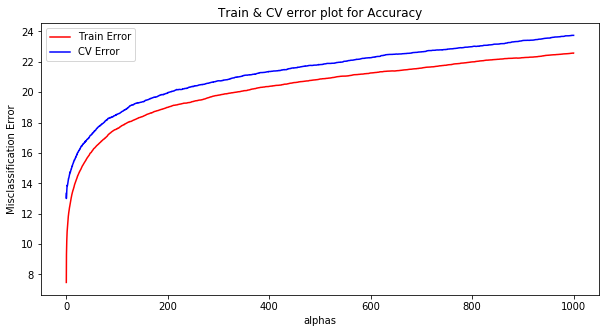

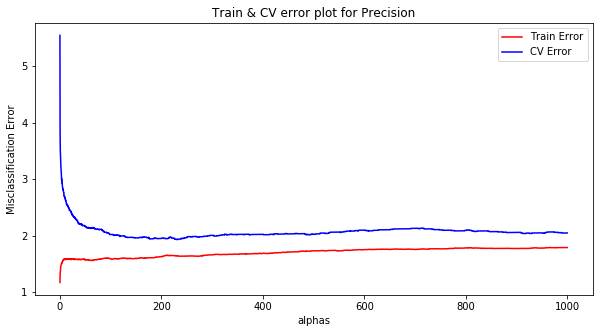

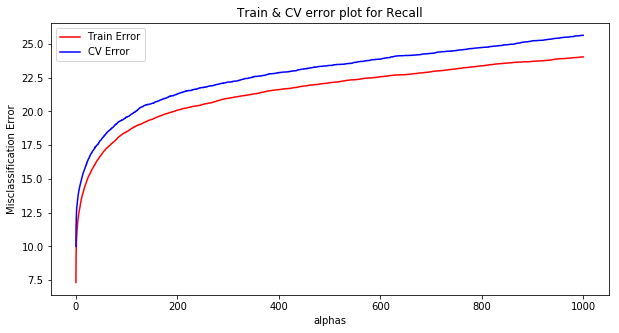

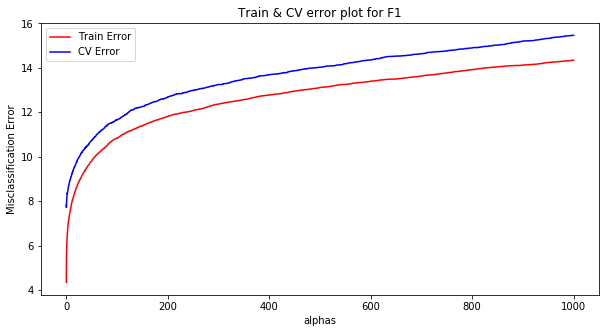

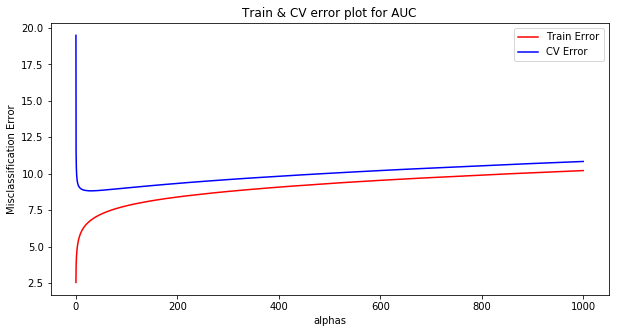

In [194]:
#plot Train and CV errors for different metrices

#for accuracy score
PlotTrainVsCVerror(alphas,train_acc_scores, cv_acc_scores, "Accuracy")
#for precision score
PlotTrainVsCVerror(alphas,train_prec_scores, cv_prec_scores, "Precision")
#for recall score
PlotTrainVsCVerror(alphas,train_recall_scores, cv_recall_scores, "Recall")
#for f1 score
PlotTrainVsCVerror(alphas,train_f1_scores, cv_f1_scores, "F1")
#for auc score
PlotTrainVsCVerror(alphas,train_auc_scores, cv_auc_scores, "AUC")

<b><u>Conclusion for best hyper-parameter</u></b>: We have three possible alpha values. 0, 28 and 230 based on different scoring metrices which can also be observed in the above CV vs Train plots. I will skip alpha = 0 as this value means no laplace smoothing. I will select an alpha value from 28 and 230 finally pick the one which gives lowest FP (and highest  TN) on test set. 

<b><u>Note</u></b>: After diagnosing various scoring metrices and RUC plot for all the three possible alpha values on test set, I came to conclusion that 230 alpha value is the best value as it gives lowest FP (and highest TN). I am not including the steps I performed in the ipython notebook to reduce the code size. I will now perform the prediction on test set with alpha = 230 and list out various metrices, RUC plot and feature importance

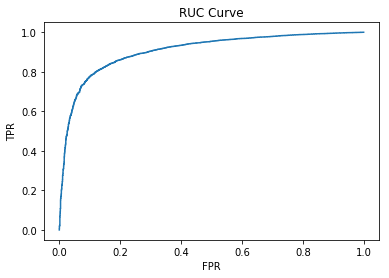

In [35]:
#plotting ruc curve for validation set
optimal_alpha = 230 #this value seems to be the best alphas
PlotRUC(optimal_alpha, X_BOW_train, y_train, X_BOW_val, y_val,sample_weights, None)

<b><u>Note</u></b>:The above RUC curve on validation set shows we have selected a good hyper-parameter

In [36]:
#Let us now check if our model is overfitting or underfitting on train data itself with optimal alpha value
acc,prec,recall,f1,auc,conf_matrix,feature_log_prob = CheckTestSetScores(X_BOW_train, y_train,optimal_alpha, X_BOW_train, y_train, sample_weights, None)

Confusion matrix is: 

[[ 4928   577]
 [ 8859 34636]]


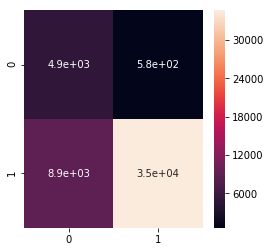

In [37]:
print("Confusion matrix is: \n")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 4))
sns.heatmap(conf_matrix, annot=True)
plt.show()

In [38]:
tn, fp, fn, tp = conf_matrix.ravel()
print('True Negative with %d alpha value is %d' % (optimal_alpha, tn))
print('False Positive with %d alpha value is %d' % (optimal_alpha, fp))
print('True Positive with %d alpha value is %d' % (optimal_alpha, tp))
print('False Negative with %d alpha value is %d' % (optimal_alpha, fn))
print('Accuracy with %d alpha value is %d%%' % (optimal_alpha, acc))
print('Precision with %d alpha value is %d%%' % (optimal_alpha, prec))
print('Recall with %d alpha value is %d%%' % (optimal_alpha, recall))
print('F1 Score with %d alpha value is %d%%' % (optimal_alpha, f1))
print('AUC Score with %d alpha value is %d%%' % (optimal_alpha, auc))

True Negative with 230 alpha value is 4928
False Positive with 230 alpha value is 577
True Positive with 230 alpha value is 34636
False Negative with 230 alpha value is 8859
Accuracy with 230 alpha value is 80%
Precision with 230 alpha value is 98%
Recall with 230 alpha value is 79%
F1 Score with 230 alpha value is 88%
AUC Score with 230 alpha value is 91%


<b><u>Note</u></b>:The above metrices show that trained model on training data seems to be neither overfitting nor underfitting

In [43]:
#Now get the model performance metrices on test set with optimal alpha value
acc,prec,recall,f1,auc,conf_matrix,feature_log_prob = CheckTestSetScores(X_BOW_train, y_train,optimal_alpha, X_BOW_test, y_test, sample_weights, None)

Confusion matrix is: 

[[ 3717   403]
 [ 5703 20177]]


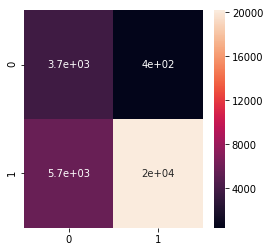

In [44]:
print("Confusion matrix is: \n")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 4))
sns.heatmap(conf_matrix, annot=True)
plt.show()

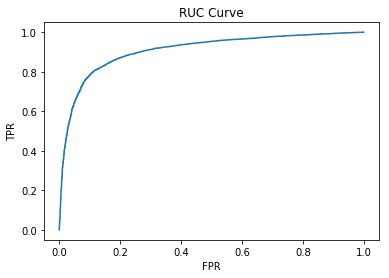

In [45]:
#plot ruc curve for test set
PlotRUC(optimal_alpha, X_BOW_train, y_train, X_BOW_test, y_test, sample_weights, None)

<b><u>Note</u></b>:The above RUC curve shows we that the alphas value we selected is working well with test set data as well

In [22]:
#we need high TNR and low FPR
tn, fp, fn, tp = conf_matrix.ravel()
#tnr = tn/(tn + fp) * float(100)
#tpr = tp/(tp + fn) * float(100)
#fnr = fn/(tp + fn) * float(100)
#fpr = fp/(tn + fp) * float(100)
print('True Negative with %d alpha value is %d' % (optimal_alpha, tn))
print('False Positive with %d alpha value is %d' % (optimal_alpha, fp))
print('True Positive with %d alpha value is %d' % (optimal_alpha, tp))
print('False Negative with %d alpha value is %d' % (optimal_alpha, fn))
print('Accuracy with %d alpha value is %d%%' % (optimal_alpha, acc))
print('Precision with %d alpha value is %d%%' % (optimal_alpha, prec))
print('Recall with %d alpha value is %d%%' % (optimal_alpha, recall))
print('F1 Score with %d alpha value is %d%%' % (optimal_alpha, f1))
print('AUC Score with %d alpha value is %d%%' % (optimal_alpha, auc))

True Negative with 230 alpha value is 3717
False Positive with 230 alpha value is 403
True Positive with 230 alpha value is 20177
False Negative with 230 alpha value is 5703
Accuracy with 230 alpha value is 79%
Precision with 230 alpha value is 98%
Recall with 230 alpha value is 77%
F1 Score with 230 alpha value is 86%
AUC Score with 230 alpha value is 90%


In [164]:
#predicting feature importance
#reference: https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
neg_class_prob_sorted = feature_log_prob[0, :].argsort()[::-1]
pos_class_prob_sorted = feature_log_prob[1, :].argsort()[::-1]
print("Most important words for a negative review are")
print(np.take(cv.get_feature_names(), neg_class_prob_sorted[:10]))
print("\nMost important words for a positive review are")
print(np.take(cv.get_feature_names(), pos_class_prob_sorted[:10]))

['not' 'tast' 'like' 'product' 'one' 'flavor' 'veri' 'would' 'tri' 'good']
['not' 'like' 'tast' 'tea' 'good' 'flavor' 'great' 'love' 'use' 'one']


## <u>3.2: MultinomialNB on TF-IDF Vectorizer</u>

<b><u>Note</u></b>: Sklearn documentation for MultinomialNB says <i>"The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work."</i>
So I will use MultinomialNB for TFIDF as well

In [47]:
#generating uni-gram BOW
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
X_tfidf_train = tfidf_vect.fit_transform(X_train)
print(X_tfidf_train.shape)

(49000, 30898)


In [48]:
#tranforming X_val to tfidf
X_tfidf_val = tfidf_vect.transform(X_val)
print(X_tfidf_val.shape)

(21000, 30898)


In [49]:
#tranforming X_test to tfidf
X_tfidf_test = tfidf_vect.transform(X_test)
print(X_tfidf_test.shape)

(30000, 30898)


In [15]:
#Performin MultinomialNB with simple cross validation on TfIDF
alphas = np.arange(10**-3,10**3,0.1)
cv_acc_scores,cv_prec_scores,cv_recall_scores,cv_f1_scores,cv_auc_scores,train_acc_scores,train_prec_scores,train_recall_scores,train_f1_scores,train_auc_scores = NBCrossVal(alphas, X_tfidf_train, y_train, X_tfidf_val, y_val, sample_weights, None)

100%|██████████| 10000/10000 [28:29<00:00,  7.14it/s]


In [50]:
optimal_alpha = alphas[cv_f1_scores.index(max(cv_f1_scores))]
print('\nOptimal value of alpha = %d with f1-score of %d%%' % (optimal_alpha, max(cv_f1_scores)))
optimal_alpha = alphas[cv_acc_scores.index(max(cv_acc_scores))]
print('\nOptimal value of alpha = %d with accuracy score of %d%%' % (optimal_alpha, max(cv_acc_scores)))
optimal_alpha = alphas[cv_prec_scores.index(max(cv_prec_scores))]
print('\nOptimal value of alpha = %d with precision score of %d%%' % (optimal_alpha, max(cv_prec_scores)))
optimal_alpha = alphas[cv_recall_scores.index(max(cv_recall_scores))]
print('\nOptimal value of alpha = %d with recall score of %d%%' % (optimal_alpha, max(cv_recall_scores)))
optimal_alpha = alphas[cv_auc_scores.index(max(cv_auc_scores))]
print('\nOptimal value of alpha = %d with auc score of %d%%' % (optimal_alpha, max(cv_auc_scores)))


Optimal value of alpha = 0 with f1-score of 91%

Optimal value of alpha = 0 with accuracy score of 86%

Optimal value of alpha = 30 with precision score of 97%

Optimal value of alpha = 0 with recall score of 89%

Optimal value of alpha = 14 with auc score of 92%


<b><u>Note</u></b>: Now we have various best values of alpha based on different scoring metrics. We shall now further filter out
the best alpha value among these alpha values

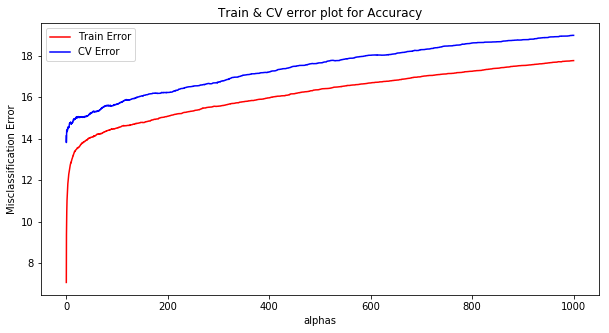

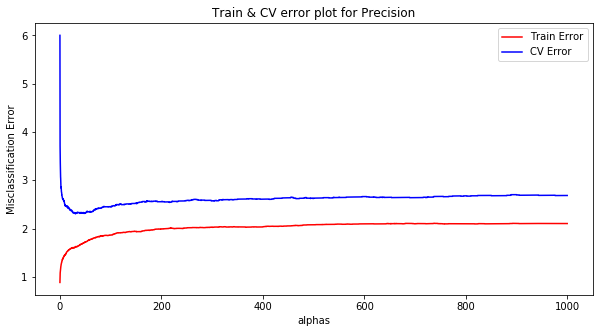

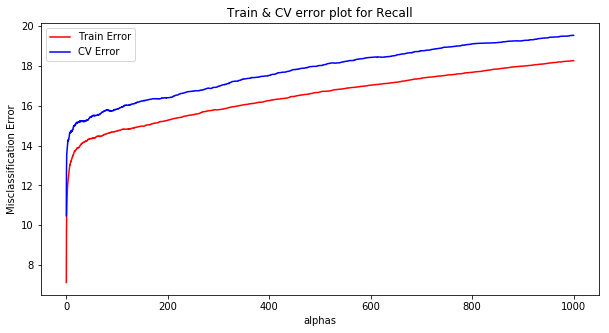

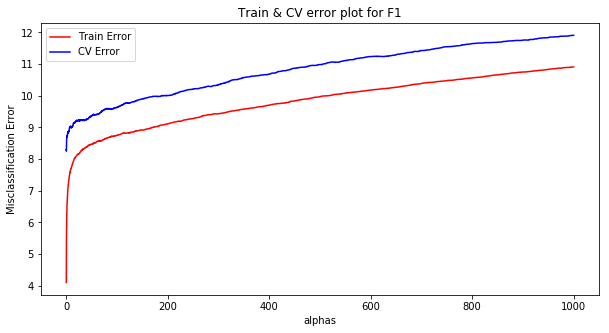

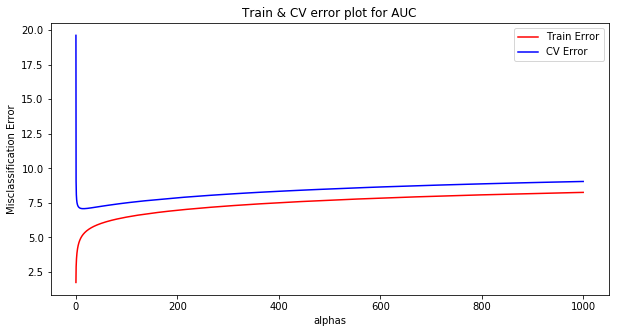

In [18]:
#plot Train and CV errors for different matrices

#for accuracy score
PlotTrainVsCVerror(alphas,train_acc_scores, cv_acc_scores, "Accuracy")
#for precision score
PlotTrainVsCVerror(alphas,train_prec_scores, cv_prec_scores, "Precision")
#for recall score
PlotTrainVsCVerror(alphas,train_recall_scores, cv_recall_scores, "Recall")
#for f1 score
PlotTrainVsCVerror(alphas,train_f1_scores, cv_f1_scores, "F1")
#for auc score
PlotTrainVsCVerror(alphas,train_auc_scores, cv_auc_scores, "AUC")

<b><u>Conclusion for best hyper-parameter</u></b>: We have three possible alpha values. 0, 14 and 30 based on different scoring metrices which can also be observed in the above CV vs Train plots.I will skip alpha = 0 as this value means no laplace smoothing. I will select an alpha value from 14 and 30 finally pick the one which gives lowest FP (and highest  TN) on test set. 

<b><u>Note</u></b>: After diagnosing various scoring metrices and RUC plot for all the three possible alpha values on test set, I came to conclusion that 14 alpha value is the best value as it gives lowest FP and cosiderably good scoring metrics values. I am not including the steps I performed in the ipython notebook to reduce the code size. I will now perform the prediction on test set with alpha = 14 and list out various metrices, RUC plot and feature importance

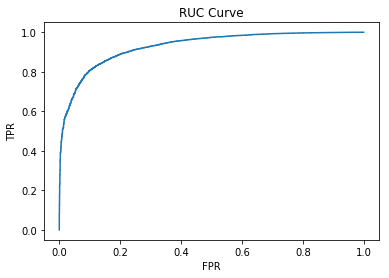

In [50]:
#plotting ruc curve for validation set
optimal_alpha = 14 #this value seems to be the best alpha value
PlotRUC(optimal_alpha, X_tfidf_train, y_train, X_tfidf_val, y_val, sample_weights, None)

<b><u>Note</u></b>:The above RUC curve on validation set shows we have selected a good hyper-parameter

In [51]:
#Let us now check if our model is overfitting or underfitting on train data itself with optimal alpha value
acc,prec,recall,f1,auc,conf_matrix,feature_log_prob = CheckTestSetScores(X_tfidf_train, y_train,optimal_alpha, X_tfidf_train, y_train, sample_weights, None)

Confusion matrix is: 

[[ 4925   580]
 [ 5897 37598]]


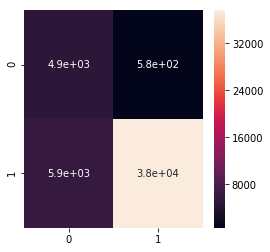

In [52]:
print("Confusion matrix is: \n")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 4))
sns.heatmap(conf_matrix, annot=True)
plt.show()

In [53]:
tn, fp, fn, tp = conf_matrix.ravel()
print('True Negative with %d alpha value is %d' % (optimal_alpha, tn))
print('False Positive with %d alpha value is %d' % (optimal_alpha, fp))
print('True Positive with %d alpha value is %d' % (optimal_alpha, tp))
print('False Negative with %d alpha value is %d' % (optimal_alpha, fn))
print('Accuracy with %d alpha value is %d%%' % (optimal_alpha, acc))
print('Precision with %d alpha value is %d%%' % (optimal_alpha, prec))
print('Recall with %d alpha value is %d%%' % (optimal_alpha, recall))
print('F1 Score with %d alpha value is %d%%' % (optimal_alpha, f1))
print('AUC Score with %d alpha value is %d%%' % (optimal_alpha, auc))

True Negative with 14 alpha value is 4925
False Positive with 14 alpha value is 580
True Positive with 14 alpha value is 37598
False Negative with 14 alpha value is 5897
Accuracy with 14 alpha value is 86%
Precision with 14 alpha value is 98%
Recall with 14 alpha value is 86%
F1 Score with 14 alpha value is 92%
AUC Score with 14 alpha value is 94%


<b><u>Note</u></b>:The above metrices show that trained model on training data seems to be neither overfitting nor underfitting

In [54]:
#Now get the model performance metrices on test set with optimal alpha values
acc,prec,recall,f1,auc,conf_matrix,feature_log_prob = CheckTestSetScores(X_tfidf_train, y_train,optimal_alpha, X_tfidf_test, y_test, sample_weights, None)

Confusion matrix is: 

[[ 3590   530]
 [ 3957 21923]]


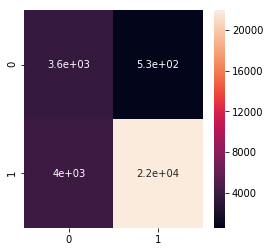

In [55]:
print("Confusion matrix is: \n")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 4))
sns.heatmap(conf_matrix, annot=True)
plt.show()

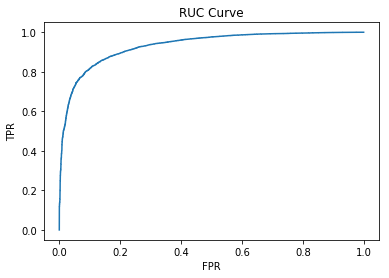

In [56]:
#plot ruc curve for test set
PlotRUC(optimal_alpha, X_tfidf_train, y_train, X_tfidf_test, y_test, sample_weights, None)

<b><u>Note</u></b>:The above RUC curve shows we that the alpha value we selected is working well with test set data as well

In [57]:
#we need high TNR and low FPR
tn, fp, fn, tp = conf_matrix.ravel()
#tnr = tn/(tn + fp) * float(100)
#tpr = tp/(tp + fn) * float(100)
#fnr = fn/(tp + fn) * float(100)
#fpr = fp/(tn + fp) * float(100)
print('True Negative with %d alpha value is %d' % (optimal_alpha, tn))
print('False Positive with %d alpha value is %d' % (optimal_alpha, fp))
print('True Positive with %d alpha value is %d' % (optimal_alpha, tp))
print('False Negative with %d alpha value is %d' % (optimal_alpha, fn))
print('Accuracy with %d alpha value is %d%%' % (optimal_alpha, acc))
print('Precision with %d alpha value is %d%%' % (optimal_alpha, prec))
print('Recall with %d alpha value is %d%%' % (optimal_alpha, recall))
print('F1 Score with %d alpha value is %d%%' % (optimal_alpha, f1))
print('AUC Score with %d alpha value is %d%%' % (optimal_alpha, auc))

True Negative with 14 alpha value is 3590
False Positive with 14 alpha value is 530
True Positive with 14 alpha value is 21923
False Negative with 14 alpha value is 3957
Accuracy with 14 alpha value is 85%
Precision with 14 alpha value is 97%
Recall with 14 alpha value is 84%
F1 Score with 14 alpha value is 90%
AUC Score with 14 alpha value is 93%


In [58]:
#predicting feature importance
#reference: https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
neg_class_prob_sorted = feature_log_prob[0, :].argsort()[::-1]
pos_class_prob_sorted = feature_log_prob[1, :].argsort()[::-1]
print("Most important words for a negative review are")
print(np.take(tfidf_vect.get_feature_names(), neg_class_prob_sorted[:10]))
print("\nMost important words for a positive review are")
print(np.take(tfidf_vect.get_feature_names(), pos_class_prob_sorted[:10]))

Most important words for a negative review are
['not' 'tast' 'like' 'product' 'would' 'one' 'veri' 'flavor' 'order' 'tri']

Most important words for a positive review are
['tea' 'great' 'tast' 'love' 'good' 'like' 'not' 'flavor' 'product' 'veri']


## <u>Summary:</u><br/>
<table>
    <tr>
        <th>Vectorizer</th>
        <th>Algorithm</th>
        <th>Best alpha value</th>
        <th>True Negative(Test)</th>
        <th>False Positive(Test)</th>
        <th>True Positive(Test)</th>
        <th>False Negative(Test)</th>
        <th>Test F1-Score</th>
        <th>Test Accuracy</th>
        <th>Test Precision</th>
        <th>Test Recall</th>
        <th>Test AUC</th>
    </tr>
    <tr>
        <td>BOW</td>
        <td>MultiNomialNB</td>
        <td>230</td>
        <td>3717</td>
        <td>403</td>
        <td>20177</td>
        <td>5703</td>
        <td>86%</td>
        <td>79%</td>
        <td>98%</td>
        <td>77%</td>
        <td>86%</td>
    </tr>
    <tr>
        <td>TFIDF</td>
        <td>MultiNomialNB</td>
        <td>14</td>
        <td>3590</td>
        <td>530</td>
        <td>21923</td>
        <td>3957</td>
        <td>90%</td>
        <td>85%</td>
        <td>97%</td>
        <td>84%</td>
        <td>93%</td>
    </tr>
    </table>

## <u>Conclusion</u>:
If we are more concerned about misclassification of negative reviews, then MultiNomialNB on BOW seems to be working better. But the overall model performance for MultiNomialNB on TFIDF seems to be better.

# Section 4: Apply Logistic Regression

# Applying Logistic Regression

## [4.1] Logistic Regression on BOW

### [4.1.1] Applying Logistic Regression with L1 regularization on BOW

##### <b><u>Note</u></b>: Defining some functions that we will use throughout the assignment

In [137]:
#Perform grid search for logistic regression
from sklearn.model_selection import GridSearchCV
def PerformGridSearchCV(estimator,parameters, cv, scoring, X_train, y_train):
    clf = GridSearchCV(estimator = estimator, param_grid = parameters, cv=cv, scoring = scoring, n_jobs = -1, verbose = 1)
    start = time()
    clf.fit(X_train, y_train)
    print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(clf.cv_results_['params'])))
    report(clf.cv_results_)
    #print(clf.cv_results_)
    return clf.cv_results_,clf.best_score_ ,clf.best_estimator_

In [138]:
# Utility function to report best scores
#reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [139]:
from sklearn.linear_model import LogisticRegression
def CheckTestSetScores(OptimalCValue, x_train, y_train, x_test, y_test, penalty, solver):
    """Returns the scoring metrics for given C value on Logistic Regression on test/val set"""
    lrc = LogisticRegression(C=OptimalCValue, penalty=penalty, class_weight = 'balanced', n_jobs = -1, solver = solver)
    lrc.fit(X=x_train,y= y_train)
    ytest_pred = lrc.predict(X = x_test)
    ytest_log_prob = lrc.predict_log_proba(X = x_test)
    ytrain_pred = lrc.predict(X = x_train)
    ytrain_log_prob = lrc.predict_log_proba(X = x_train)
    acc = sklearn.metrics.accuracy_score(y_test, ytest_pred, normalize=True) * float(100)
    prec = sklearn.metrics.precision_score(y_test, ytest_pred) * float(100)
    recall = sklearn.metrics.recall_score(y_test, ytest_pred) * float(100)
    f1 = sklearn.metrics.f1_score(y_test, ytest_pred) * float(100)
    auc = sklearn.metrics.roc_auc_score(y_test, ytest_log_prob[:,1]) * float(100)
    conf_matrix = sklearn.metrics.confusion_matrix(y_test, ytest_pred)
    log_loss = sklearn.metrics.log_loss(y_test, ytest_pred)
    weights = lrc.coef_
    #Plot ROC Curve
    fpr,tpr,thresholds = sklearn.metrics.roc_curve(y_test, ytest_log_prob[:,1])
    fpr_train,tpr_train,thresholds_train = sklearn.metrics.roc_curve(y_train, ytrain_log_prob[:,1])
    plt.plot(fpr, tpr, 'b-', label= 'Test ROC')
    plt.plot(fpr_train, tpr_train, 'r-', label= 'Train ROC')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title("ROC Curves for train and test data")
    plt.legend(loc='best')
    plt.show()
    #print(conf_matrix)
    return acc,prec,recall,f1,auc,conf_matrix,log_loss,weights

In [140]:
def PlotROC(CValue, x_train, y_train, x_val, y_val, penalty, solver):
    """plot ROC curve for validation/test data for a given alpha value"""
    lrc = LogisticRegression(C=CValue, penalty=penalty, class_weight = "balanced", solver = solver, n_jobs = -1)
    lrc.fit(X =x_train,y= y_train)
    yval_pred = lrc.predict(X = x_val)
    yval_log_prob = lrc.predict_log_proba(X = x_val)
    fpr,tpr,thresholds = sklearn.metrics.roc_curve(y_val, yval_log_prob[:,1])
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title("ROC Curve")
    plt.show()

In [141]:
def PlotTrainVsCVerror(Cvalues,train_scores, cv_scores, score_type):
    """plotting misclassification train and CV error against given C values for a given score metric"""
    plt.figure(figsize=(20,5))
    #plt.xticks(np.arange(min(Cvalues), max(Cvalues)+1, 0.5))
    plt.plot(Cvalues, train_scores, 'r-', label= 'Train result')
    plt.plot(Cvalues, cv_scores, 'b-', label= 'CV result')
    plt.xlabel('C-Values')
    plt.ylabel(score_type + ' Score')
    plt.title("Train VS CV plot for " + score_type)
    plt.legend(loc='best')
    plt.show()

In [142]:
#get the data from pre-processed or cleaned data that we saved in the previous assignment
import os
import sqlite3
con = sqlite3.connect('cleaned.sqlite')
data = pd.read_sql_query("Select Cleaned_Text,Score from Reviews where Score != 3 order by Time limit 100000", con)
con.close()

In [61]:
X = data.iloc[:,0]
y = data.iloc[:, 1]

In [143]:
#since I will use gridSearchCV so I will only split the data into train and test set (and skip a separate validation set)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3,shuffle = False, random_state = 0)
print(X_train.shape)
print(X_test.shape)

(70000,)
(30000,)


In [144]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_BOW_train = cv.fit_transform(X_train)
print(X_BOW_train.shape)

(70000, 36445)


In [145]:
#standardize the train data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_BOW_train_std = sc.fit_transform(X_BOW_train)
print(X_BOW_train_std.shape)

(70000, 36445)


In [147]:
#Serializing BOW train saved previously
with open("X_BOW_train_std_noval_100k.pkl","wb") as f:
     pickle.dump(X_BOW_train_std,f)

In [148]:
#loading BOW train saved previously
with open("X_BOW_train_std_noval_100k.pkl","rb") as f:
    X_BOW_train_std = pickle.load(f)

In [149]:
#tranforming X_test to BOW
X_BOW_test = cv.transform(X_test)
print(X_BOW_test.shape)

(30000, 36445)


In [150]:
#standardize the test data
X_BOW_test_std = sc.transform(X_BOW_test)
print(X_BOW_test_std.shape)

(30000, 36445)


In [151]:
#Serializing BOW test saved previously
with open("X_BOW_test_std_noval_100k.pkl","wb") as f:
     pickle.dump(X_BOW_test_std,f)

In [152]:
#loading BOW test saved previously
with open("X_BOW_test_std_noval_100k.pkl","rb") as f:
    X_BOW_test_std = pickle.load(f)

In [26]:
#Define parameters and logistic regression estimator to be used in GridSearchCV
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
lrc = LogisticRegression(class_weight = 'balanced', n_jobs = -1, solver = 'sag')

In [27]:
#check best params using gridsearch on the basis of auc score
auc_results,best_auc,best_estimator_auc = PerformGridSearchCV(lrc, parameters, 5, "roc_auc", X_BOW_train_std, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.6min finished


GridSearchCV took 170.54 seconds for 9 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.920 (std: 0.004)
Parameters: {'C': 0.0001}

Model with rank: 2
Mean validation score: 0.919 (std: 0.004)
Parameters: {'C': 0.001}

Model with rank: 3
Mean validation score: 0.919 (std: 0.004)
Parameters: {'C': 0.01}



In [28]:
#get train and CV data from gridsearch results object
df_auc_results = pd.DataFrame(auc_results)
grd_srch_test = df_auc_results["mean_test_score"].values
grd_srch_train = df_auc_results["mean_train_score"].values
CValues = df_auc_results["param_C"].values

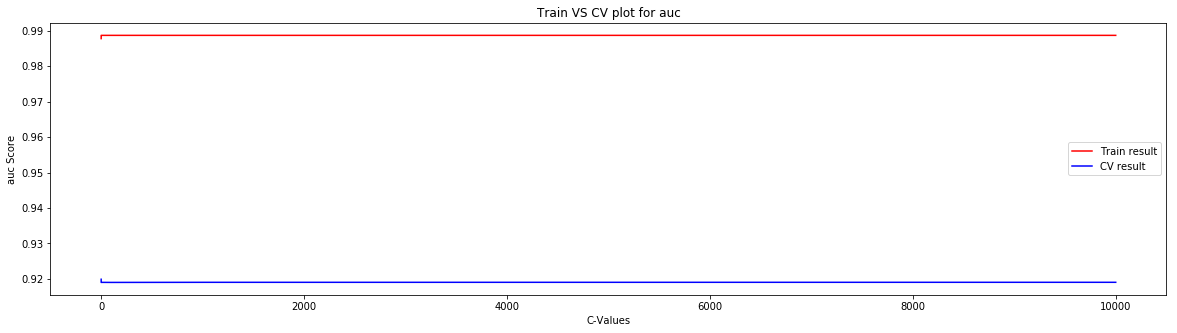

In [29]:
#Plot train vs CV data on the selected C Values on the basis of auc score
PlotTrainVsCVerror(CValues,grd_srch_train, grd_srch_test, "auc")

<b><u>Conclusion for best hyper-parameter</u></b>:From GridSearchCV and above plot we can conclude that CValue of 0.0001 seems to be the best value on the basis of AUC score.

#### [4.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW

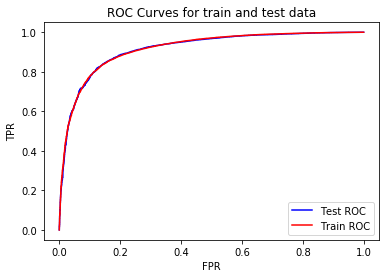

In [52]:
#Now get the model performance metrices on test set with optimal C value
optimal_CValue = 0.001 #let's take the 2nd best C value = 0.001, otherwise weights will be too sparse
acc,prec,recall,f1,auc,conf_matrix,log_loss,weights = CheckTestSetScores(optimal_CValue, X_BOW_train_std, y_train,X_BOW_test_std, y_test, "l1", solver='saga')


In [53]:
print("auc score is for test set with L1 regularization is " + str(auc))

auc score is for test set with L1 regularization is 91.66953339535723


In [54]:
print("Number of non zero weights with L1 Regulariation are: " + str(np.count_nonzero(weights)))

Number of non zero weights with L1 Regulariation are: 295


<b>Observation:</b> Hence we could observe that weights are now sparse with C Value of 0.001

Confusion matrix for test set is: 

[[ 3467   653]
 [ 3788 22092]]


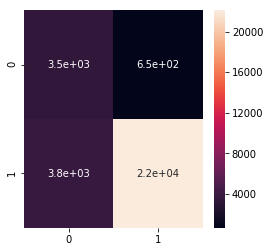

In [55]:
#print confusion matrix for test set
print("Confusion matrix for test set is: \n")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 4))
sns.heatmap(conf_matrix, annot=True)
plt.show()

### [4.1.2] Applying Logistic Regression with L2 regularization on BOW

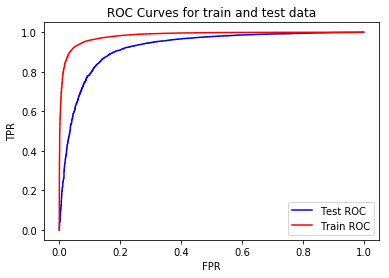

In [33]:
#Now get the model performance metrices on test set with optimal C value
optimal_CValue = 0.0001 #Let's take the best C value for L2 Regularization
acc,prec,recall,f1,auc,conf_matrix,log_loss,weights = CheckTestSetScores(optimal_CValue, X_BOW_train_std, y_train,X_BOW_test_std, y_test, "l2", solver='saga')

In [34]:
print("auc score is for test set with L2 regularization is " + str(auc))

auc score is for test set with L2 regularization is 92.31075135802284


In [93]:
print("Number of non zero weights with L2 Regulariation are: " + str(np.count_nonzero(weights)))

Number of non zero weights with L2 Regulariation are: 36445


<b>Observation:</b> Hence we could observe that weights are not at all sparse with C Value of 0.001 for L2 Regularization

Confusion matrix for test set is: 

[[ 3283   837]
 [ 2253 23627]]


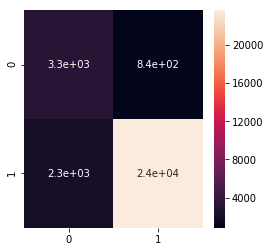

In [94]:
#print confusion matrix for test set
print("Confusion matrix for test set is: \n")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 4))
sns.heatmap(conf_matrix, annot=True)
plt.show()

#### [4.1.2.1] Performing pertubation test (multicollinearity check) on BOW

In [38]:
noise = np.random.normal(loc=0.0, scale=0.0001)
X_BOW_train_std.data += noise #introduce noise to the train set
optimal_CValue = 0.0001
lrc = LogisticRegression(C=optimal_CValue, penalty="l2", class_weight = 'balanced', n_jobs = -1, solver = "sag")
lrc.fit(X_BOW_train_std,y_train)
weights_e = lrc.coef_

In [125]:
#add small values to weigths to avoid divide by 0 error
weights = weights[0] + 10**-6
weights_e = weights_e[0] + 10**-6

In [109]:
#Calculate percentage weight change
percentage_weight_change = (abs((weights - weights_e)/np.linalg.norm(weights))) * 100

In [110]:
#plot the CDF for percentage_weight_change
counts, bin_edges = np.histogram(percentage_weight_change, bins = 1000, density = True)
pdf_percentage_weight_change = counts/sum(counts)
cdf_percentage_weight_change = np.cumsum(pdf_percentage_weight_change)

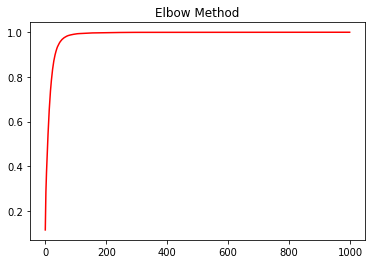

In [135]:
#check for the cut-off values of weight difference percentage using elbow method
plt.plot(cdf_percentage_weight_change,'r-')
plt.title("Elbow Method")
#plt.legend(loc='best')
plt.show()

In [112]:
# find 0th to 100th percentiles for percentage_weight_change
for i in range(0,101,10):
    print(str(i) + "th Percentile is " + str(np.percentile(percentage_weight_change, i)))

0th Percentile is 6.351631975050852e-07
10th Percentile is 0.004423937640507152
20th Percentile is 0.009185558985561327
30th Percentile is 0.01656341962652962
40th Percentile is 0.029130334884800504
50th Percentile is 0.04359336908824538
60th Percentile is 0.06041765013865018
70th Percentile is 0.08140139527862168
80th Percentile is 0.1124361518758804
90th Percentile is 0.16903522602416948
100th Percentile is 5.076613779415046


<b>Observation: </b>We could clearly see a jump from 90th percentile of 0.16 to 100th percentile of 5.07. 

In [113]:
#Let's dissect the percentiles further
for i in np.linspace(99.98,100,11):
    print(str(i) + "th Percentile is " + str(np.percentile(percentage_weight_change, i)))

99.98th Percentile is 2.3116339080756054
99.982th Percentile is 2.437373694818024
99.98400000000001th Percentile is 2.595993265308702
99.986th Percentile is 2.738669880895666
99.988th Percentile is 2.977754612970098
99.99000000000001th Percentile is 3.2637776999140793
99.992th Percentile is 3.56267735975029
99.994th Percentile is 3.70979121810035
99.996th Percentile is 3.9534182822118042
99.998th Percentile is 4.384668567554051
100.0th Percentile is 5.076613779415046


<b>Observation: </b>We could see a change in percentile value above 2.5 from 98.984 percentile onwards. 

In [114]:
#find the indices of percentage_weight_change values that are having values > 2.5
perc_change_major_indices = [i for i,v in enumerate(percentage_weight_change) if v > 2.5]

In [132]:
#print the feature/word names that correspond to high percent change in weights or in other words multi-collinear features
print(np.take(cv.get_feature_names(), perc_change_major_indices))

['best' 'delici' 'disappoint' 'good' 'great' 'love' 'not']


### [4.1.3] Feature Importance on BOW

#### [4.1.3.1] Top 10 important features of positive class

In [133]:
#sort the weights in descending and take the top 10 indices which will correspond to positive review
pos_class_prob_sorted = np.argsort(-weights)
print("Most important words for a positive review are")
#get top 10 features for positive reviews
print(np.take(cv.get_feature_names(), pos_class_prob_sorted)[:10]) 

Most important words for a positive review are
['great' 'love' 'best' 'delici' 'perfect' 'good' 'excel' 'favorit' 'find'
 'nice']


#### [4.1.3.2] Top 10 important features of negative class

In [134]:
#sort the weights in ascending and take the top 10 indices which will correspond to negative review
neg_class_prob_sorted = np.argsort(weights)
print("Most important words for a negative review are")
#get top 10 features for negative reviews
print(np.take(cv.get_feature_names(), neg_class_prob_sorted)[:10]) 

Most important words for a negative review are
['disappoint' 'not' 'worst' 'terribl' 'aw' 'horribl' 'bad' 'money' 'threw'
 'return']


## [4.2] Logistic Regression on TFIDF

In [153]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
X_tfidf_train = tfidf_vect.fit_transform(X_train)
print(X_tfidf_train.shape)

(70000, 36445)


In [154]:
#standardize the tfidf train data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_tfidf_train_std = sc.fit_transform(X_tfidf_train)
print(X_tfidf_train_std.shape)

(70000, 36445)


In [155]:
#serializing tfidf train
with open("X_tfidf_train_std_noval_100k.pkl","wb") as f:
     pickle.dump(X_tfidf_train_std,f)

In [156]:
#loading tfidf train saved previously
with open("X_tfidf_train_std_noval_100k.pkl","rb") as f:
    X_tfidf_train_std = pickle.load(f)

In [157]:
#tranforming X_test to tfidf
X_tfidf_test = tfidf_vect.transform(X_test)
print(X_tfidf_test.shape)

(30000, 36445)


In [158]:
#standardize the tfidf test data
X_tfidf_test_std = sc.transform(X_tfidf_test)
print(X_tfidf_test_std.shape)

(30000, 36445)


In [159]:
#serializing tfidf test data
with open("X_tfidf_test_std_noval_100k.pkl","wb") as f:
     pickle.dump(X_tfidf_test_std,f)

In [160]:
#loading tfidf test saved previously
with open("X_tfidf_test_std_noval_100k.pkl","rb") as f:
    X_tfidf_test_std = pickle.load(f)

In [44]:
#Define parameters and logistic regression estimator to be used in GridSearchCV
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
lrc = LogisticRegression(class_weight = 'balanced', n_jobs = -1, solver = 'saga')

In [45]:
#check best params using gridsearch on the basis on auc
auc_results,best_auc,best_estimator_auc = PerformGridSearchCV(lrc, parameters, 5, "roc_auc", X_tfidf_train_std, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.5min finished


GridSearchCV took 164.18 seconds for 9 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.929 (std: 0.004)
Parameters: {'C': 0.0001}

Model with rank: 2
Mean validation score: 0.929 (std: 0.004)
Parameters: {'C': 0.01}

Model with rank: 3
Mean validation score: 0.929 (std: 0.004)
Parameters: {'C': 0.001}



In [46]:
#get train and CV data from gridsearch results object
df_auc_results = pd.DataFrame(auc_results)
grd_srch_test = df_auc_results["mean_test_score"].values
grd_srch_train = df_auc_results["mean_train_score"].values
CValues = df_auc_results["param_C"].values

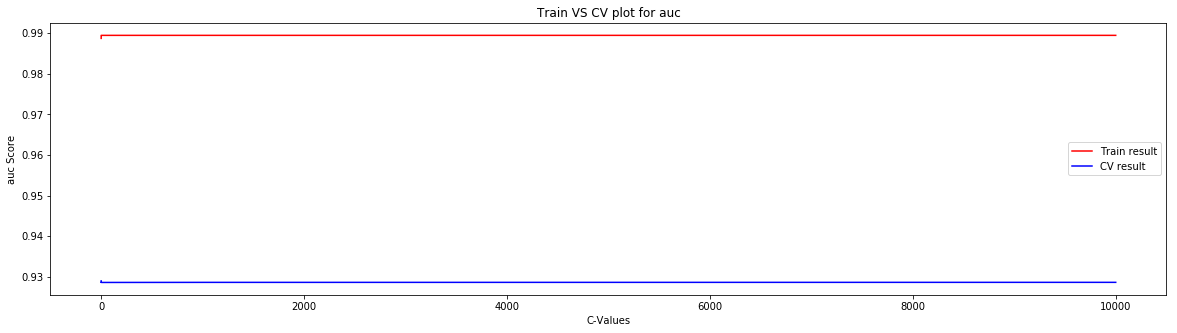

In [47]:
#Plot train vs CV data on the selected C Values on the basis of auc score
PlotTrainVsCVerror(CValues,grd_srch_train, grd_srch_test, "auc")

<b><u>Conclusion for best hyper-parameter</u></b>:From GridSearchCV and above plot we can conclude that CValue of 0.0001 seems to be the best value on the basis of AUC score.

### [4.2.1] Applying Logistic Regression with L1 regularization on TFIDF

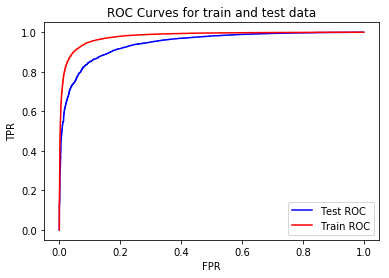

In [70]:
#Now get the model performance metrices on test set with optimal C value
optimal_CValue = 0.01 #let's take the 2nd best C = 0.01 otherwise weights will be too sparse
acc,prec,recall,f1,auc,conf_matrix,log_loss,weights = CheckTestSetScores(optimal_CValue, X_tfidf_train_std, y_train,X_tfidf_test_std, y_test, "l1", solver='saga')


In [71]:
print("auc score is for test set with L1 regularization is " + str(auc))

auc score is for test set with L1 regularization is 94.38843345312947


In [72]:
print("Number of non zero weights with L1 Regulariation are: " + str(np.count_nonzero(weights)))

Number of non zero weights with L1 Regulariation are: 10764


<b>Observation:</b> Hence we could observe that weights are now sparse with C Value of 0.01

Confusion matrix for test set is: 

[[ 3425   695]
 [ 2567 23313]]


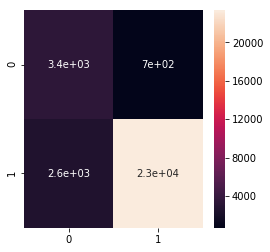

In [73]:
#print confusion matrix for test set
print("Confusion matrix for test set is: \n")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 4))
sns.heatmap(conf_matrix, annot=True)
plt.show()

### [4.2.2] Applying Logistic Regression with L2 regularization on TFIDF

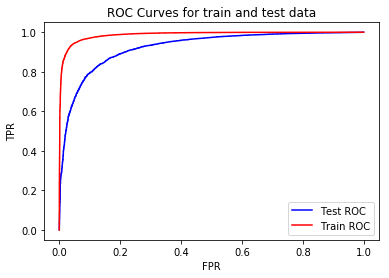

In [95]:
#Now get the model performance metrices on test set with optimal C value
optimal_CValue = 0.0001 #let's take best C value forr L2 reg
acc,prec,recall,f1,auc,conf_matrix,log_loss,weights = CheckTestSetScores(optimal_CValue, X_tfidf_train_std, y_train,X_tfidf_test_std, y_test, "l2", solver='saga')

In [96]:
print("auc score is for test set is " + str(auc))

auc score is for test set is 92.439283342837


Confusion matrix for test set is: 

[[ 3179   941]
 [ 2393 23487]]


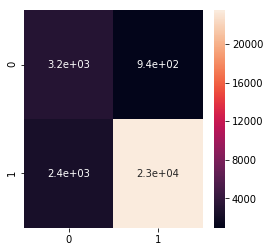

In [97]:
#print confusion matrix for test set
print("Confusion matrix for test set is: \n")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 4))
sns.heatmap(conf_matrix, annot=True)
plt.show()

### [4.2.3] Feature Importance on TFIDF

#### [4.2.3.1] Top 10 important features of positive class from

In [68]:
#sort the weights in descending and take the top 10 indices which will correspond to positive review
pos_class_prob_sorted = np.argsort(-weights)[:10] 
print("Most important words for a positive review are")
#get top 10 features for positive reviews
print(np.take(cv.get_feature_names(), pos_class_prob_sorted)[0][:10]) 

Most important words for a positive review are
['great' 'love' 'best' 'delici' 'good' 'perfect' 'favorit' 'excel' 'find'
 'nice']


#### [4.2.3.2] Top 10 important features of negative class

In [69]:
#sort the weights in ascending and take the top 10 indices which will correspond to negative review
neg_class_prob_sorted = np.argsort(weights)[:10] 
print("Most important words for a negative review are")
#get top 10 features for negative reviews
print(np.take(cv.get_feature_names(), neg_class_prob_sorted)[0][:10]) 

Most important words for a negative review are
['not' 'disappoint' 'worst' 'terribl' 'aw' 'horribl' 'bland' 'bad'
 'return' 'stale']


## [4.3] Logistic Regression on AVG W2V

### [4.3.1] Applying Logistic Regression with L1 regularization on AVG W2V

In [161]:
def Get_List_Reviews(X_type):
    """get list of words for all review for the given X_type"""
    list_of_reviews = []
    for review in X_type.values:
        list_of_reviews.append(review.split())
    return list_of_reviews

In [162]:
#converting X_train into list of words for each review
list_of_reviews_train = Get_List_Reviews(X_train)
print(len(list_of_reviews_train))

70000


In [163]:
#converting X_test into list of words for each review
list_of_reviews_test = Get_List_Reviews(X_test)
print(len(list_of_reviews_test))

30000


In [164]:
from gensim.models import Word2Vec
#train avg w2v on list_of_reviews_train
w2v_model = Word2Vec(list_of_reviews_train, min_count=4,size=300, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [165]:
#writing code to generate X_avgw2v_type using avg w2v
def Get_Avg_W2v(list_of_reviews):
    from tqdm import tqdm
    review_word_vector = []
    for review in tqdm(list_of_reviews):
        w2v_vector = np.zeros(300)
        for word in review:
            word_count = 0
            if(word in w2v_words):
                w2v_vector += w2v_model.wv[word]
                word_count += 1
        if word_count != 0:
            w2v_vector /= word_count
        review_word_vector.append(w2v_vector)
    return review_word_vector

In [166]:
#get avg w2v for train data
X_avgw2v_train = Get_Avg_W2v(list_of_reviews_train)
print(len(X_avgw2v_train))
print(len(X_avgw2v_train[0]))

100%|██████████| 70000/70000 [01:38<00:00, 713.69it/s] 


70000
300


In [167]:
#Serializing avg w2v train
with open("X_avgw2v_train_noval_100k_300dim.pkl","wb") as f:
    pickle.dump(X_avgw2v_train,f)

In [168]:
#loading avg w2v train saved previously
with open("X_avgw2v_train_noval_100k_300dim.pkl","rb") as f:
    X_avgw2v_train = pickle.load(f)

In [169]:
#get avg w2v for test data
X_avgw2v_test = Get_Avg_W2v(list_of_reviews_test)
print(len(X_avgw2v_test))
print(len(X_avgw2v_test[0]))

100%|██████████| 30000/30000 [00:59<00:00, 502.64it/s]


30000
300


In [170]:
#Serializing avg w2v test
with open("X_avgw2v_test_100k_300dim.pkl","wb") as f:
    pickle.dump(X_avgw2v_test,f)

In [171]:
#loading avg w2v test saved in previous assignments
with open("X_avgw2v_test_100k_300dim.pkl","rb") as f:
    X_avgw2v_test = pickle.load(f)

In [145]:
#Define parameters and logistic regression estimator to be used in GridSearchCV
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
lrc = LogisticRegression(class_weight = 'balanced', n_jobs = -1, solver = 'sag')

In [146]:
#check best params using gridsearch on the basis on auc
auc_results,best_auc,best_estimator_auc = PerformGridSearchCV(lrc, parameters, 5, "roc_auc", X_avgw2v_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  4.4min finished


GridSearchCV took 285.95 seconds for 9 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.906 (std: 0.004)
Parameters: {'C': 0.01}

Model with rank: 2
Mean validation score: 0.906 (std: 0.004)
Parameters: {'C': 10000}

Model with rank: 3
Mean validation score: 0.906 (std: 0.004)
Parameters: {'C': 100}



In [147]:
#get train and CV data from gridsearch results object
df_auc_results = pd.DataFrame(auc_results)
grd_srch_test = df_auc_results["mean_test_score"].values
grd_srch_train = df_auc_results["mean_train_score"].values
CValues = df_auc_results["param_C"].values

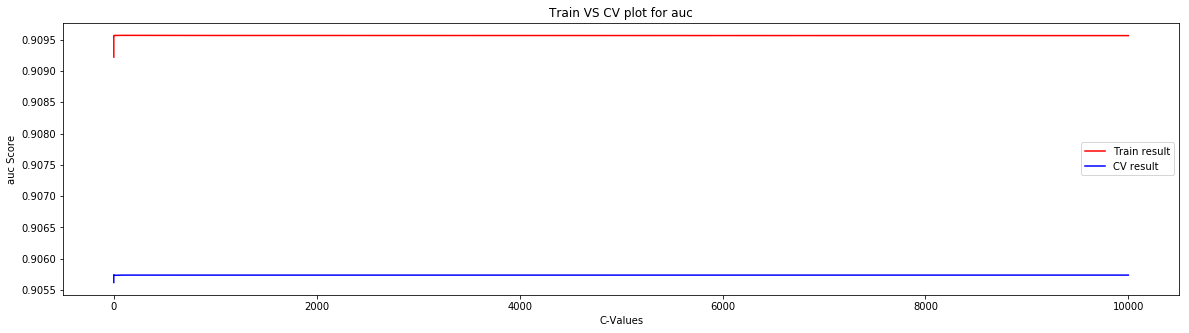

In [148]:
#Plot train vs CV data on the selected C Values on the basis of auc score
PlotTrainVsCVerror(CValues,grd_srch_train, grd_srch_test, "auc")

<b><u>Conclusion for best hyper-parameter</u></b>:From GridSearchCV and above plot we can conclude that CValue of 0.01 seems to be the best value on the basis of AUC score.

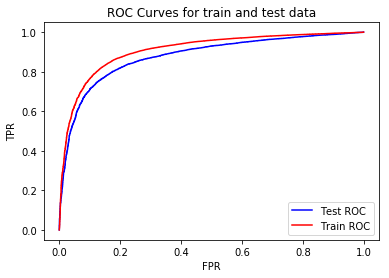

In [76]:
#Now get the model performance metrices on test set with optimal C value
optimal_CValue = 0.01
acc,prec,recall,f1,auc,conf_matrix,log_loss,weights = CheckTestSetScores(optimal_CValue, X_avgw2v_train, y_train,X_avgw2v_test, y_test, "l1", solver='saga')

In [77]:
print("auc score is for test set with L1 regularization is " + str(auc))

auc score is for test set with L1 regularization is 87.80380462102909


Confusion matrix for test set is: 

[[ 3705   415]
 [ 7437 18443]]


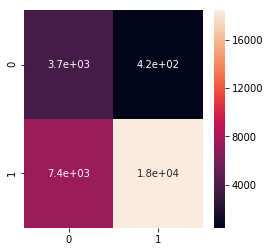

In [78]:
#print confusion matrix for test set
print("Confusion matrix for test set is: \n")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 4))
sns.heatmap(conf_matrix, annot=True)
plt.show()

### [4.3.2] Applying Logistic Regression with L2 regularization on AVG W2V

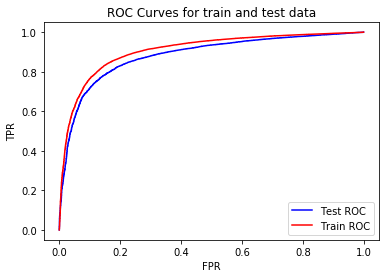

In [79]:
#Now get the model performance metrices on test set with optimal C value
optimal_CValue = 0.01
acc,prec,recall,f1,auc,conf_matrix,log_loss,weights = CheckTestSetScores(optimal_CValue, X_avgw2v_train, y_train,X_avgw2v_test, y_test, "l2", solver='saga')

In [80]:
print("auc score is for test set with L2 Regularization is " + str(auc))

auc score is for test set with L2 Regularization is 88.29145392851248


Confusion matrix for test set is: 

[[ 3619   501]
 [ 6425 19455]]


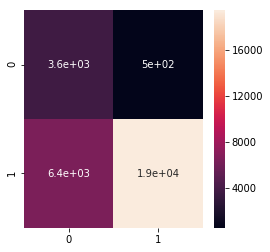

In [81]:
#print confusion matrix for test set
print("Confusion matrix for test set is: \n")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 4))
sns.heatmap(conf_matrix, annot=True)
plt.show()

## [4.4] Logistic Regression on TFIDF W2V

### [4.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V

In [172]:
#save tfidf scores of all the cleaned words from all the reviews in a dictionary
dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))

In [173]:
#code to vectorize reviews using tf-idf w2v
def Get_Tfidfw2v_Vector(list_of_reviews):
    from tqdm import tqdm
    tfidf_feat = tfidf_vect.get_feature_names() # tfidf words/col-names
    tfidf_w2v = []
    for row,review in enumerate(tqdm(list_of_reviews)):
        review_vect = np.zeros(300)
        tfidf_sum = 0
        for word in review:
            if(word in w2v_words and word in dictionary):
                #tf_idf = tfidf_data[row, tfidf_feat.index(word)]
                tf_idf = dictionary[word] * review.count(word)/len(review)
                tfidf_sum += tf_idf
                #pdb.set_trace()
                review_vect += w2v_model.wv[word] * tf_idf
        if tfidf_sum != 0:
            review_vect /= tfidf_sum
        tfidf_w2v.append(review_vect)
    return tfidf_w2v

In [174]:
#get tfidf w2v for train data
X_tfidfw2v_train = Get_Tfidfw2v_Vector(list_of_reviews_train)
print(len(X_tfidfw2v_train))

100%|██████████| 70000/70000 [01:55<00:00, 608.24it/s]


70000


In [175]:
#Serializing tfidf w2v train data
with open("X_tfidfw2v_train_noval_100k_300dim.pkl","wb") as f:
    pickle.dump(X_tfidfw2v_train,f)

In [176]:
#loading tfidf w2v train saved previously
with open("X_tfidfw2v_train_noval_100k_300dim.pkl","rb") as f:
    X_tfidfw2v_train = pickle.load(f)

In [177]:
#get tfidf w2v for test data
X_tfidfw2v_test = Get_Tfidfw2v_Vector(list_of_reviews_test)
print(len(X_tfidfw2v_test))

100%|██████████| 30000/30000 [00:51<00:00, 578.80it/s]


30000


In [178]:
#Serializing tfidf w2v test data
with open("X_tfidfw2v_test_100k_300dim.pkl","wb") as f:
    pickle.dump(X_tfidfw2v_test,f)

In [179]:
#loading tfidf w2v test saved in previous assignments
with open("X_tfidfw2v_test_100k_300dim.pkl","rb") as f:
    X_tfidfw2v_test = pickle.load(f)

In [177]:
#Define parameters and logistic regression estimator to be used in GridSearchCV
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
lrc = LogisticRegression(class_weight = 'balanced', n_jobs = -1, solver = 'saga')

In [178]:
#check best params using gridsearch on the basis on auc
auc_results,best_auc,best_estimator_auc = PerformGridSearchCV(lrc, parameters, 5, "roc_auc", X_tfidfw2v_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.4min finished


GridSearchCV took 227.23 seconds for 9 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.901 (std: 0.003)
Parameters: {'C': 1000}

Model with rank: 2
Mean validation score: 0.901 (std: 0.003)
Parameters: {'C': 10000}

Model with rank: 3
Mean validation score: 0.901 (std: 0.003)
Parameters: {'C': 100}



In [179]:
#get train and CV data from gridsearch results object
df_auc_results = pd.DataFrame(auc_results)
grd_srch_test = df_auc_results["mean_test_score"].values
grd_srch_train = df_auc_results["mean_train_score"].values
CValues = df_auc_results["param_C"].values

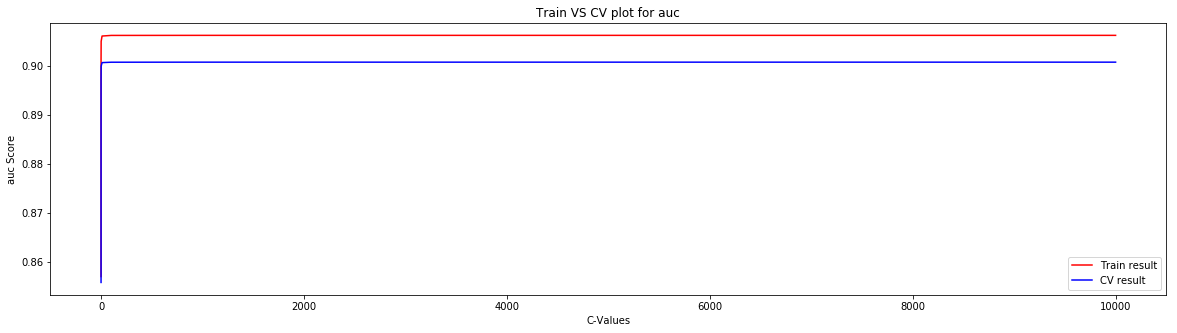

In [180]:
#Plot train vs CV data on the selected C Values on the basis of auc score
PlotTrainVsCVerror(CValues,grd_srch_train, grd_srch_test, "auc")

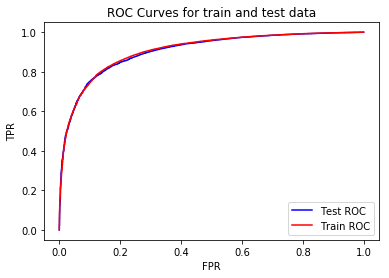

In [84]:
#Now get the model performance metrices on test set with optimal C value
optimal_CValue =1000
acc,prec,recall,f1,auc,conf_matrix,log_loss,weights = CheckTestSetScores(optimal_CValue, X_tfidfw2v_train, y_train,X_tfidfw2v_test, y_test, "l1", solver='saga')

In [85]:
print("auc score is for test set with L1 Regularization is " + str(auc))

auc score is for test set with L1 Regularization is 90.50501146066236


Confusion matrix for test set is: 

[[ 3484   636]
 [ 4852 21028]]


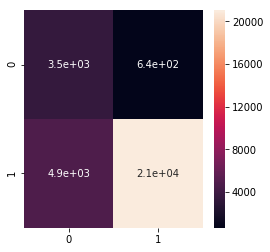

In [86]:
#print confusion matrix for test set
print("Confusion matrix for test set is: \n")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 4))
sns.heatmap(conf_matrix, annot=True)
plt.show()

### [4.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V

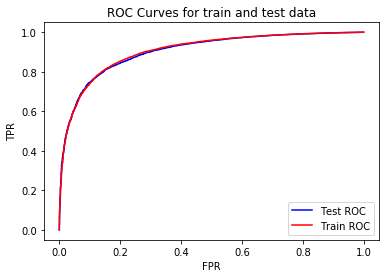

In [87]:
#Now get the model performance metrices on test set with optimal C value
optimal_CValue = 1000
acc,prec,recall,f1,auc,conf_matrix,log_loss,weights = CheckTestSetScores(optimal_CValue, X_tfidfw2v_train, y_train,X_tfidfw2v_test, y_test, "l2", solver='saga')

In [88]:
print("auc score is for test set with L2 Regularization is " + str(auc))

auc score is for test set with L2 Regularization is 90.41975988880719


Confusion matrix for test set is: 

[[ 3491   629]
 [ 4888 20992]]


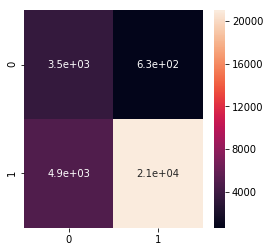

In [89]:
#print confusion matrix for test set
print("Confusion matrix for test set is: \n")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 4))
sns.heatmap(conf_matrix, annot=True)
plt.show()

# [4.5] Conclusions

In [4]:
#Printing results for L1 Regularization
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "C Value Chosen","AUC Score", "True Negatives", "True Positives", "False Negatives", "False Positives"]
x.add_row(["BOW", 0.001, 91.66, 3467, 22092, 3788, 653])
x.add_row(["TFIDF", 0.01,94.38, 3425, 23313, 2567, 695])
x.add_row(["Avg Word2Vec",0.01,87.80, 3705, 18443, 7437, 415])
x.add_row(["TFIDF Word2Vec", 1000, 90.50, 3484, 21028, 4852, 636])
print("Results for L1 Regularization")
print(x)

Results for L1 Regularization
+----------------+----------------+-----------+----------------+----------------+-----------------+-----------------+
|   Vectorizer   | C Value Chosen | AUC Score | True Negatives | True Positives | False Negatives | False Positives |
+----------------+----------------+-----------+----------------+----------------+-----------------+-----------------+
|      BOW       |     0.001      |   91.66   |      3467      |     22092      |       3788      |       653       |
|     TFIDF      |      0.01      |   94.38   |      3425      |     23313      |       2567      |       695       |
|  Avg Word2Vec  |      0.01      |    87.8   |      3705      |     18443      |       7437      |       415       |
| TFIDF Word2Vec |      1000      |    90.5   |      3484      |     21028      |       4852      |       636       |
+----------------+----------------+-----------+----------------+----------------+-----------------+-----------------+


<b>Summary</b>: From the above result TFIDF seems to be giving best all round performance with High True Negatives and Low False Positives, with an impressive AUC score of 94.38.

In [1]:
#Printing results for L2 Regularization
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Best C Value", "AUC Score", "True Negatives", "True Positives", "False Negatives", "False Positives"]
x.add_row(["BOW", 0.0001, 92.30, 3283, 23627, 2253, 837])
x.add_row(["TFIDF", 0.0001, 92.43, 3179, 23487, 2393, 941])
x.add_row(["Avg Word2Vec", 0.01, 88.29, 3619, 19455, 6425, 501])
x.add_row(["TFIDF Word2Vec", 1000, 90.41, 3491, 20992, 4888, 629])
print("Results for L2 Regularization")
print(x)

Results for L2 Regularization
+----------------+--------------+-----------+----------------+----------------+-----------------+-----------------+
|   Vectorizer   | Best C Value | AUC Score | True Negatives | True Positives | False Negatives | False Positives |
+----------------+--------------+-----------+----------------+----------------+-----------------+-----------------+
|      BOW       |    0.0001    |    92.3   |      3283      |     23627      |       2253      |       837       |
|     TFIDF      |    0.0001    |   92.43   |      3179      |     23487      |       2393      |       941       |
|  Avg Word2Vec  |     0.01     |   88.29   |      3619      |     19455      |       6425      |       501       |
| TFIDF Word2Vec |     1000     |   90.41   |      3491      |     20992      |       4888      |       629       |
+----------------+--------------+-----------+----------------+----------------+-----------------+-----------------+


<b>Summary</b>: From the above result TFIDF Word2Vec seems to be giving best all round performance with High True Negatives and Low False Positives, with a AUC score of 90.41.

# [5] Section 5: SVM

# Applying SVM

## [5.1] Linear SVM

##### <b><u>Note</u></b>: Defining some functions that we will use throughout ths section

In [4]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
#we will use sklearn.utils.class_weight to estimate sample weights
from sklearn.utils.class_weight import compute_sample_weight
def CheckTestSetScores(clf, x_train, y_train, x_test, y_test):
    """Returns the auc, confusion matrix for given estimator on test/val set"""
    #clf = SGDClassifier(alpha=OptimalAlpha, penalty=penalty, class_weight = 'balanced', n_jobs = -1)
    clf.fit(X=x_train,y= y_train)
    cal_clf = CalibratedClassifierCV(base_estimator=clf, method='isotonic', cv='prefit')
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train) #using sample weights in Calibrated Classifier
    cal_clf.fit(X=x_train,y= y_train, sample_weight = sample_weights)
    ytest_pred = cal_clf.predict(X = x_test)
    ytest_proba = cal_clf.predict_proba(X = x_test)
    ytrain_pred = cal_clf.predict(X = x_train)
    ytrain_proba= cal_clf.predict_proba(X = x_train)
    auc = sklearn.metrics.roc_auc_score(y_test, ytest_proba[:,1]) * float(100)
    conf_matrix = sklearn.metrics.confusion_matrix(y_test, ytest_pred)
    weights = clf.coef_
    #Plot ROC Curve
    fpr,tpr,thresholds = sklearn.metrics.roc_curve(y_test, ytest_proba[:,1])
    fpr_train,tpr_train,thresholds_train = sklearn.metrics.roc_curve(y_train, ytrain_proba[:,1])
    plt.plot(fpr, tpr, 'b-', label= 'Test ROC')
    plt.plot(fpr_train, tpr_train, 'r-', label= 'Train ROC')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title("ROC Curves for train and test data")
    plt.legend(loc='best')
    plt.show()
    #print(conf_matrix)
    return auc,conf_matrix,weights

In [6]:
#get the data from pre-processed or cleaned data that we saved in the previous assignment
import os
import sqlite3
con = sqlite3.connect('cleaned.sqlite')
data = pd.read_sql_query("Select Cleaned_Text,Score from Reviews where Score != 3 order by Time limit 100000", con)
con.close()

In [7]:
#Get input matrix of features X and output vector y
X = data.iloc[:,0]
y = data.iloc[:, 1]

In [8]:
#since I will use gridSearchCV so I will only split the data into train and test set (and skip a separate validation set)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3,shuffle = False, random_state = 0)
print(X_train.shape)
print(X_test.shape)

(70000,)
(30000,)


### [5.1.1] Applying Linear SVM on BOW

In [9]:
#get BOW vector for train data
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_BOW_train = cv.fit_transform(X_train)
print(X_BOW_train.shape)

(70000, 36445)


In [ ]:
#standardize the train data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_BOW_train_std = sc.fit_transform(X_BOW_train)
print(X_BOW_train_std.shape)

In [ ]:
#Serializing BOW train saved previously
with open("X_BOW_train_std_noval_100k.pkl","wb") as f:
     pickle.dump(X_BOW_train_std,f)

In [10]:
#loading BOW train saved previously
with open("X_BOW_train_std_noval_100k.pkl","rb") as f:
    X_BOW_train_std = pickle.load(f)

In [ ]:
#tranforming X_test to BOW
X_BOW_test = cv.transform(X_test)
print(X_BOW_test.shape)

In [ ]:
#standardize the test data
X_BOW_test_std = sc.transform(X_BOW_test)
print(X_BOW_test_std.shape)

In [ ]:
#Serializing BOW test saved previously
with open("X_BOW_test_std_noval_100k.pkl","wb") as f:
     pickle.dump(X_BOW_test_std,f)

In [11]:
#loading BOW test saved previously
with open("X_BOW_test_std_noval_100k.pkl","rb") as f:
    X_BOW_test_std = pickle.load(f)

In [12]:
#Define parameters and SGDClassifier estimator to be used in GridSearchCV
parameters = {'penalty':('l2', 'l1'),'alpha':[10**-4, 10**-3, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
clf = SGDClassifier(class_weight = 'balanced', n_jobs = -1)

In [13]:
#check best params using gridsearch on the basis of auc score
auc_results,best_auc,best_estimator_auc = PerformGridSearchCV(clf, parameters, 5, "roc_auc", X_BOW_train_std, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.7s finished


GridSearchCV took 6.89 seconds for 18 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.919 (std: 0.003)
Parameters: {'alpha': 1, 'penalty': 'l2'}

Model with rank: 2
Mean validation score: 0.919 (std: 0.006)
Parameters: {'alpha': 10, 'penalty': 'l2'}

Model with rank: 3
Mean validation score: 0.898 (std: 0.004)
Parameters: {'alpha': 0.1, 'penalty': 'l2'}

Model with rank: 4
Mean validation score: 0.889 (std: 0.007)
Parameters: {'alpha': 100, 'penalty': 'l2'}

Model with rank: 5
Mean validation score: 0.885 (std: 0.007)
Parameters: {'alpha': 10000, 'penalty': 'l2'}



<b>Observation</b>: Since L1 regularization is not included in top 5 model results, so I will continue with L2 Regularization and post my results.

In [19]:
#get train and CV data from gridsearch results object
df_auc_results = pd.DataFrame(auc_results)
df_auc_results_l2 = df_auc_results.loc[df_auc_results["param_penalty"] == "l2"]
grd_srch_test = df_auc_results_l2["mean_test_score"].values
grd_srch_train = df_auc_results_l2["mean_train_score"].values
alphaValues = df_auc_results_l2["param_alpha"].values

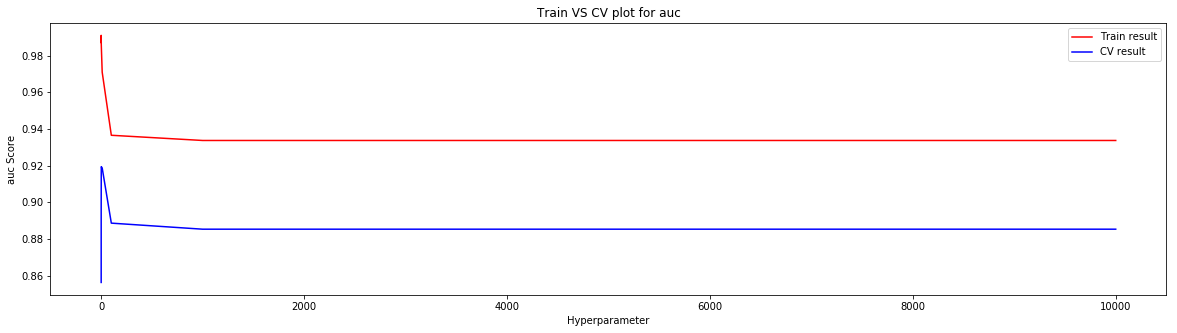

In [20]:
#Plot train vs CV data on the selected C Values on the basis of auc score
PlotTrainVsCVerror(alphaValues,grd_srch_train, grd_srch_test, "auc")

<b><u>Conclusion for best hyper-parameter</u></b>:From GridSearchCV and above plot we can conclude that CValue of 0.0001 seems to be the best value on the basis of AUC score.

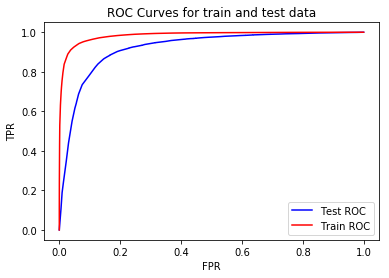

In [24]:
#Now get the model performance metrices on test set with optimal alpha value
optimal_alpha = 1 #Let's take the best alpha value for L2 Regularization
sgdc = SGDClassifier(alpha=optimal_alpha, penalty="l2", class_weight = 'balanced', n_jobs = -1)
auc,conf_matrix,weights = CheckTestSetScores(sgdc, X_BOW_train_std, y_train,X_BOW_test_std, y_test)

In [25]:
print("auc score for test set with L2 regularization is " + str(auc))

auc score for test set with L2 regularization is 92.02936161672244


Confusion matrix for test set is: 

[[ 3335   785]
 [ 2524 23356]]


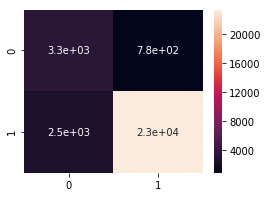

True Negative with 1 alpha value is 3335
False Positive with 1 alpha value is 785
True Positive with 1 alpha value is 23356
False Negative with 1 alpha value is 2524


In [26]:
#print confusion matrix for test set
print("Confusion matrix for test set is: \n")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 3))
sns.heatmap(conf_matrix, annot=True)
plt.show()
tn, fp, fn, tp = conf_matrix.ravel()
print('True Negative with %d alpha value is %d' % (optimal_alpha, tn))
print('False Positive with %d alpha value is %d' % (optimal_alpha, fp))
print('True Positive with %d alpha value is %d' % (optimal_alpha, tp))
print('False Negative with %d alpha value is %d' % (optimal_alpha, fn))

#### [5.1.1.1] Top 10 important features of positive class from

In [27]:
#sort the weights in descending and take the top 10 indices which will correspond to positive review
pos_class_prob_sorted = np.argsort(-weights[0])
print("Most important words for a positive review are")
#get top 10 features for positive reviews
print(np.take(cv.get_feature_names(), pos_class_prob_sorted)[:10]) 

Most important words for a positive review are
['great' 'love' 'best' 'delici' 'good' 'excel' 'perfect' 'favorit' 'nice'
 'wonder']


#### [5.1.1.2] Top 10 important features of negative class from

In [28]:
#sort the weights in ascending and take the top 10 indices which will correspond to negative review
neg_class_prob_sorted = np.argsort(weights[0])
print("Most important words for a negative review are")
#get top 10 features for negative reviews
print(np.take(cv.get_feature_names(), neg_class_prob_sorted)[:10]) 

Most important words for a negative review are
['disappoint' 'not' 'worst' 'terribl' 'bad' 'thought' 'aw' 'bland'
 'horribl' 'stale']


### [5.1.2] Applying Linear SVM on TFIDF

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
X_tfidf_train = tfidf_vect.fit_transform(X_train)
print(X_tfidf_train.shape)

(70000, 36445)


In [ ]:
#standardize the tfidf train data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_tfidf_train_std = sc.fit_transform(X_tfidf_train)
print(X_tfidf_train_std.shape)

In [ ]:
#serializing tfidf train
with open("X_tfidf_train_std_noval_100k.pkl","wb") as f:
     pickle.dump(X_tfidf_train_std,f)

In [30]:
#loading tfidf train saved previously
with open("X_tfidf_train_std_noval_100k.pkl","rb") as f:
    X_tfidf_train_std = pickle.load(f)

In [ ]:
#tranforming X_test to tfidf
X_tfidf_test = tfidf_vect.transform(X_test)
print(X_tfidf_test.shape)

In [ ]:
#standardize the tfidf test data
X_tfidf_test_std = sc.transform(X_tfidf_test)
print(X_tfidf_test_std.shape)

In [ ]:
#serializing tfidf test data
with open("X_tfidf_test_std_noval_100k.pkl","wb") as f:
     pickle.dump(X_tfidf_test_std,f)

In [31]:
#loading tfidf test saved previously
with open("X_tfidf_test_std_noval_100k.pkl","rb") as f:
    X_tfidf_test_std = pickle.load(f)

In [32]:
#Define parameters and SGDClassifier estimator to be used in GridSearchCV
parameters = {'penalty':('l2', 'l1'),'alpha':[10**-4, 10**-3, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
clf = SGDClassifier(class_weight = 'balanced', n_jobs = -1)

In [34]:
#check best params using gridsearch on the basis of auc score
auc_results,best_auc,best_estimator_auc = PerformGridSearchCV(clf, parameters, 5, "roc_auc", X_tfidf_train_std, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    4.8s finished


GridSearchCV took 5.10 seconds for 18 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.925 (std: 0.004)
Parameters: {'alpha': 10, 'penalty': 'l2'}

Model with rank: 2
Mean validation score: 0.923 (std: 0.004)
Parameters: {'alpha': 1, 'penalty': 'l2'}

Model with rank: 3
Mean validation score: 0.916 (std: 0.003)
Parameters: {'alpha': 100, 'penalty': 'l2'}

Model with rank: 4
Mean validation score: 0.916 (std: 0.003)
Parameters: {'alpha': 1000, 'penalty': 'l2'}

Model with rank: 5
Mean validation score: 0.916 (std: 0.003)
Parameters: {'alpha': 10000, 'penalty': 'l2'}



<b>Observation</b>: Since L1 regularization is not included in top 5 model results, so I will continue with L2 Regularization and post my results.

In [35]:
#get train and CV data from gridsearch results object
df_auc_results = pd.DataFrame(auc_results)
df_auc_results_l2 = df_auc_results.loc[df_auc_results["param_penalty"] == "l2"]
grd_srch_test = df_auc_results_l2["mean_test_score"].values
grd_srch_train = df_auc_results_l2["mean_train_score"].values
alphaValues = df_auc_results_l2["param_alpha"].values

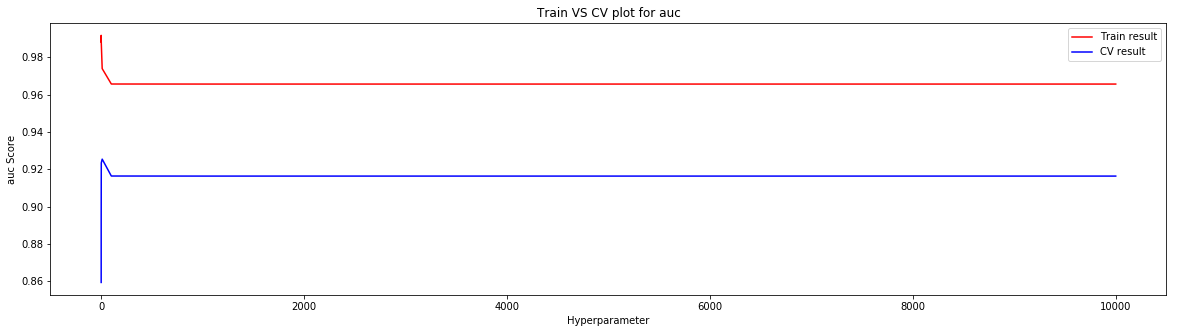

In [36]:
#Plot train vs CV data on the selected C Values on the basis of auc score
PlotTrainVsCVerror(alphaValues,grd_srch_train, grd_srch_test, "auc")

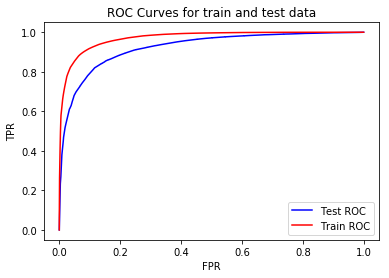

In [37]:
#Now get the model performance metrices on test set with optimal alpha value
optimal_alpha = 10 #Let's take the best alpha value for L2 Regularization
sgdc = SGDClassifier(alpha=optimal_alpha, penalty="l2", class_weight = 'balanced', n_jobs = -1)
auc,conf_matrix,weights = CheckTestSetScores(sgdc, X_tfidf_train_std, y_train,X_tfidf_test_std, y_test)

In [38]:
print("auc score for test set with L2 regularization is " + str(auc))

auc score for test set with L2 regularization is 92.35142779970288


Confusion matrix for test set is: 

[[ 3417   703]
 [ 3469 22411]]


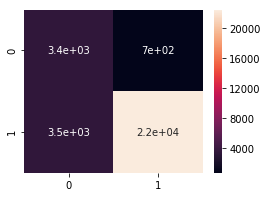

True Negative with 10 alpha value is 3417
False Positive with 10 alpha value is 703
True Positive with 10 alpha value is 22411
False Negative with 10 alpha value is 3469


In [39]:
#print confusion matrix for test set
print("Confusion matrix for test set is: \n")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 3))
sns.heatmap(conf_matrix, annot=True)
plt.show()
tn, fp, fn, tp = conf_matrix.ravel()
print('True Negative with %d alpha value is %d' % (optimal_alpha, tn))
print('False Positive with %d alpha value is %d' % (optimal_alpha, fp))
print('True Positive with %d alpha value is %d' % (optimal_alpha, tp))
print('False Negative with %d alpha value is %d' % (optimal_alpha, fn))

#### [5.1.1.1] Top 10 important features of positive class 

In [40]:
#sort the weights in descending and take the top 10 indices which will correspond to positive review
pos_class_prob_sorted = np.argsort(-weights[0])
print("Most important words for a positive review are")
#get top 10 features for positive reviews
print(np.take(tfidf_vect.get_feature_names(), pos_class_prob_sorted)[:10]) 

Most important words for a positive review are
['great' 'love' 'best' 'delici' 'perfect' 'favorit' 'good' 'find' 'make'
 'easi']


#### [5.1.1.2] Top 10 important features of negative class from

In [41]:
#sort the weights in ascending and take the top 10 indices which will correspond to negative review
neg_class_prob_sorted = np.argsort(weights[0])
print("Most important words for a negative review are")
#get top 10 features for negative reviews
print(np.take(tfidf_vect.get_feature_names(), neg_class_prob_sorted)[:10]) 

Most important words for a negative review are
['not' 'disappoint' 'worst' 'aw' 'terribl' 'horribl' 'bad' 'wast' 'return'
 'money']


### [5.1.3]  Applying Linear SVM on AVG W2V

In [12]:
#loading avg w2v train std saved previously
with open("X_avgw2v_train_std_noval_100k_300dim.pkl","rb") as f:
    X_avgw2v_train_std = pickle.load(f)

In [16]:
#loading avg w2v test std saved previously
with open("X_avgw2v_test_std_noval_100k_300dim.pkl","rb") as f:
    X_avgw2v_test_std = pickle.load(f)

In [17]:
#Define parameters and SGDClassifier estimator to be used in GridSearchCV
parameters = {'penalty':('l2', 'l1'),'alpha':[10**-4, 10**-3, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
clf = SGDClassifier(class_weight = 'balanced', n_jobs = -1)

In [18]:
#check best params using gridsearch on the basis of auc score
auc_results,best_auc,best_estimator_auc = PerformGridSearchCV(clf, parameters, 5, "roc_auc", X_avgw2v_train_std, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   50.0s finished


GridSearchCV took 51.03 seconds for 18 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.902 (std: 0.005)
Parameters: {'alpha': 0.1, 'penalty': 'l2'}

Model with rank: 2
Mean validation score: 0.899 (std: 0.004)
Parameters: {'alpha': 0.01, 'penalty': 'l2'}

Model with rank: 3
Mean validation score: 0.891 (std: 0.005)
Parameters: {'alpha': 1, 'penalty': 'l2'}

Model with rank: 4
Mean validation score: 0.881 (std: 0.007)
Parameters: {'alpha': 0.001, 'penalty': 'l1'}

Model with rank: 5
Mean validation score: 0.878 (std: 0.018)
Parameters: {'alpha': 0.01, 'penalty': 'l1'}



<b>Observation</b>: Since L1 and L2 regularizations are both included in top 5 model results, so I will try both of them with their respective best alpha values

#### Checking performance with L2 Regularization

In [19]:
#get train and CV data from gridsearch results object for L2
df_auc_results = pd.DataFrame(auc_results)
df_auc_results_l2 = df_auc_results.loc[df_auc_results["param_penalty"] == "l2"]
grd_srch_test = df_auc_results_l2["mean_test_score"].values
grd_srch_train = df_auc_results_l2["mean_train_score"].values
alphaValues = df_auc_results_l2["param_alpha"].values

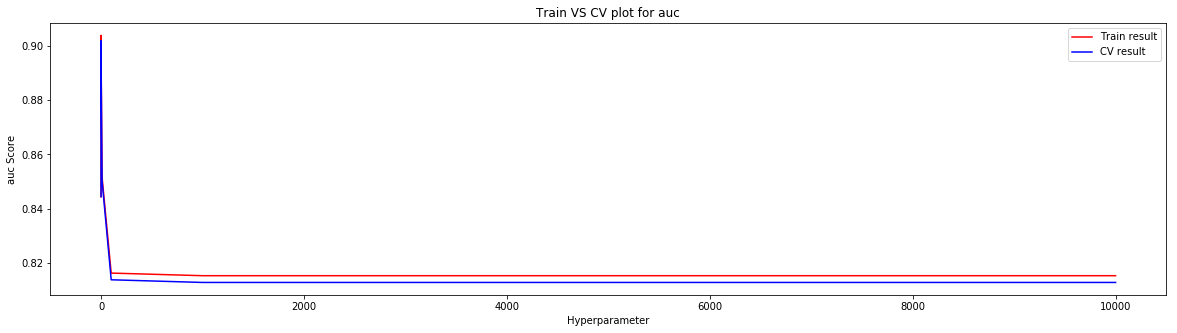

In [20]:
#Plot train vs CV data on the selected C Values on the basis of auc score
PlotTrainVsCVerror(alphaValues,grd_srch_train, grd_srch_test, "auc")

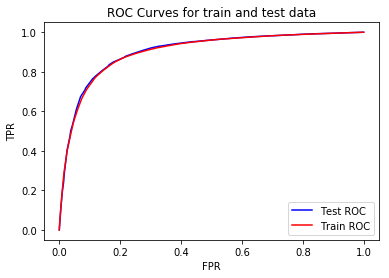

In [21]:
#Now get the model performance metrices on test set with optimal alpha value
optimal_alpha = 0.1 #Let's take the best alpha value for L2 Regularization
sgdc = SGDClassifier(alpha=optimal_alpha, penalty="l2", class_weight = 'balanced', n_jobs = -1)
auc,conf_matrix,weights = CheckTestSetScores(sgdc, X_avgw2v_train, y_train,X_avgw2v_test, y_test)

In [22]:
print("auc score for test set with L2 regularization is " + str(auc))

auc score for test set with L2 regularization is 90.33733174772289


Confusion matrix for test set is: 

[[ 3436   684]
 [ 4200 21680]]


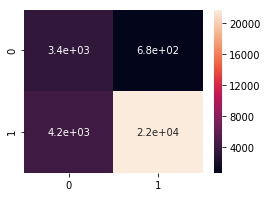

True Negative with 0.1 alpha value is 3436
False Positive with 0.1 alpha value is 684
True Positive with 0.1 alpha value is 21680
False Negative with 0.1 alpha value is 4200


In [23]:
#print confusion matrix for test set
print("Confusion matrix for test set is: \n")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 3))
sns.heatmap(conf_matrix, annot=True)
plt.show()
tn, fp, fn, tp = conf_matrix.ravel()
print('True Negative with %.1f alpha value is %d' % (optimal_alpha, tn))
print('False Positive with %.1f alpha value is %d' % (optimal_alpha, fp))
print('True Positive with %.1f alpha value is %d' % (optimal_alpha, tp))
print('False Negative with %.1f alpha value is %d' % (optimal_alpha, fn))

#### Checking performance with L1 Regularization

In [24]:
#get train and CV data from gridsearch results object for L1
df_auc_results = pd.DataFrame(auc_results)
df_auc_results_l1 = df_auc_results.loc[df_auc_results["param_penalty"] == "l1"]
grd_srch_test = df_auc_results_l1["mean_test_score"].values
grd_srch_train = df_auc_results_l1["mean_train_score"].values
alphaValues = df_auc_results_l1["param_alpha"].values

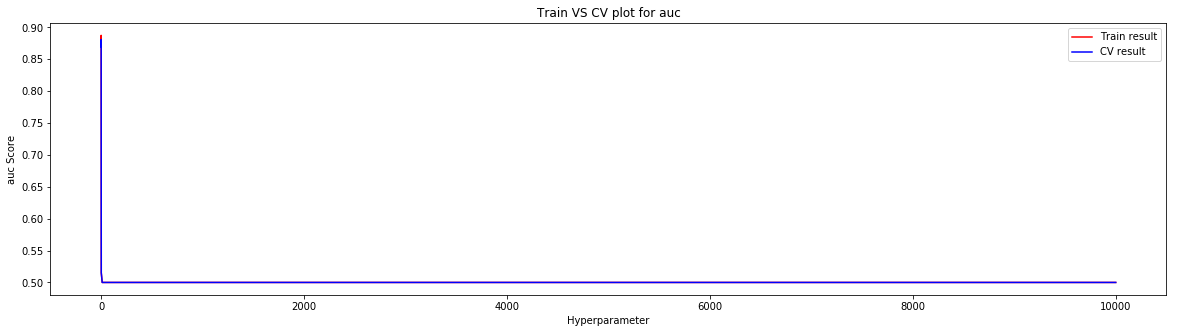

In [25]:
#Plot train vs CV data on the selected C Values on the basis of auc score
PlotTrainVsCVerror(alphaValues,grd_srch_train, grd_srch_test, "auc")

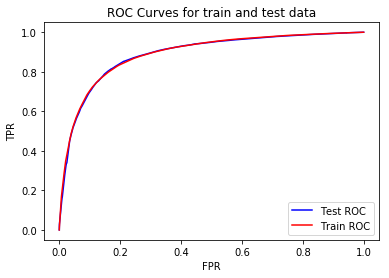

In [26]:
#Now get the model performance metrices on test set with optimal alpha value
optimal_alpha = 0.001 #Let's take the best alpha value for L1 Regularization
sgdc = SGDClassifier(alpha=optimal_alpha, penalty="l1", class_weight = 'balanced', n_jobs = -1)
auc,conf_matrix,weights = CheckTestSetScores(sgdc, X_avgw2v_train_std, y_train,X_avgw2v_test_std, y_test)

In [27]:
print("auc score for test set with L1 regularization is " + str(auc))

auc score for test set with L1 regularization is 88.83649705136479


Confusion matrix for test set is: 

[[ 3419   701]
 [ 4815 21065]]


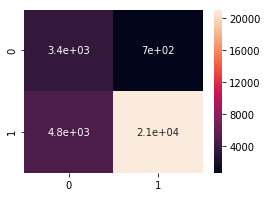

True Negative with 0.001 alpha value is 3419
False Positive with 0.001 alpha value is 701
True Positive with 0.001 alpha value is 21065
False Negative with 0.001 alpha value is 4815


In [28]:
#print confusion matrix for test set
print("Confusion matrix for test set is: \n")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 3))
sns.heatmap(conf_matrix, annot=True)
plt.show()
tn, fp, fn, tp = conf_matrix.ravel()
print('True Negative with %.3f alpha value is %d' % (optimal_alpha, tn))
print('False Positive with %.3f alpha value is %d' % (optimal_alpha, fp))
print('True Positive with %.3f alpha value is %d' % (optimal_alpha, tp))
print('False Negative with %.3f alpha value is %d' % (optimal_alpha, fn))

<b>Observation</b>:  Hence L2 regularization seems to be giving better performance

### [5.1.4]  Applying Linear SVM on TFIDF W2V

In [32]:
#loading avg w2v train std saved previously
with open("X_tfidfw2v_train_std_noval_100k_300dim.pkl","rb") as f:
    X_tfidfw2v_train_std = pickle.load(f)

In [36]:
#loading avg w2v test std saved previously
with open("X_tfidfw2v_test_std_noval_100k_300dim.pkl","rb") as f:
    X_tfidfw2v_test_std = pickle.load(f)

In [37]:
#Define parameters and SGDClassifier estimator to be used in GridSearchCV
parameters = {'penalty':('l2', 'l1'),'alpha':[10**-4, 10**-3, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
clf = SGDClassifier(class_weight = 'balanced', n_jobs = -1)

In [38]:
#check best params using gridsearch on the basis of auc score
auc_results,best_auc,best_estimator_auc = PerformGridSearchCV(clf, parameters, 5, "roc_auc", X_tfidfw2v_train_std, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   50.9s finished


GridSearchCV took 51.76 seconds for 18 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.890 (std: 0.004)
Parameters: {'alpha': 0.1, 'penalty': 'l2'}

Model with rank: 2
Mean validation score: 0.885 (std: 0.003)
Parameters: {'alpha': 0.01, 'penalty': 'l2'}

Model with rank: 3
Mean validation score: 0.878 (std: 0.004)
Parameters: {'alpha': 0.01, 'penalty': 'l1'}

Model with rank: 4
Mean validation score: 0.876 (std: 0.005)
Parameters: {'alpha': 1, 'penalty': 'l2'}

Model with rank: 5
Mean validation score: 0.870 (std: 0.005)
Parameters: {'alpha': 0.001, 'penalty': 'l1'}



<b>Observation</b>: Since L1 and L2 regularizations are both included in top 5 model results, so I will try both of them with their respective best alpha values

#### Checking performance with L2 Regularization

In [39]:
#get train and CV data from gridsearch results object for L2
df_auc_results = pd.DataFrame(auc_results)
df_auc_results_l2 = df_auc_results.loc[df_auc_results["param_penalty"] == "l2"]
grd_srch_test = df_auc_results_l2["mean_test_score"].values
grd_srch_train = df_auc_results_l2["mean_train_score"].values
alphaValues = df_auc_results_l2["param_alpha"].values

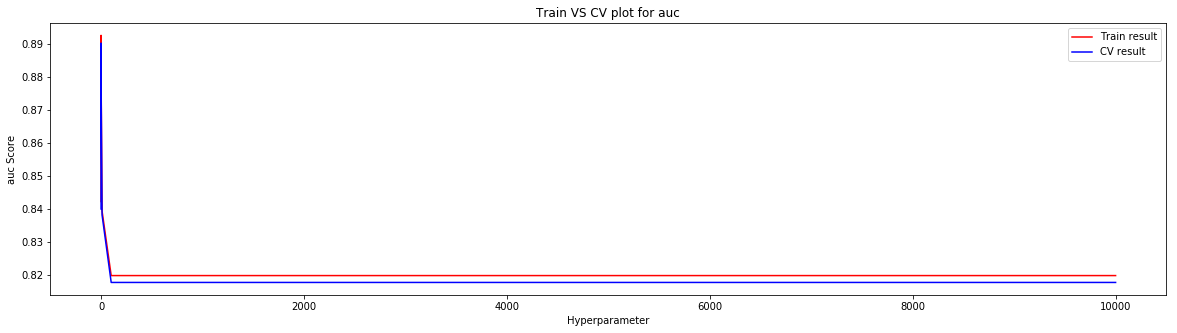

In [40]:
#Plot train vs CV data on the selected C Values on the basis of auc score
PlotTrainVsCVerror(alphaValues,grd_srch_train, grd_srch_test, "auc")

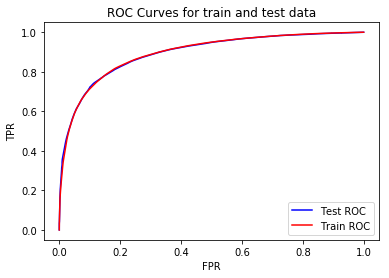

In [41]:
#Now get the model performance metrices on test set with optimal alpha value
optimal_alpha = 0.1 #Let's take the best alpha value for L2 Regularization
sgdc = SGDClassifier(alpha=optimal_alpha, penalty="l2", class_weight = 'balanced', n_jobs = -1)
auc,conf_matrix,weights = CheckTestSetScores(sgdc, X_tfidfw2v_train_std, y_train,X_tfidfw2v_test_std, y_test)

In [42]:
print("auc score for test set with L2 regularization is " + str(auc))

auc score for test set with L2 regularization is 89.36602044912291


Confusion matrix for test set is: 

[[ 3390   730]
 [ 5010 20870]]


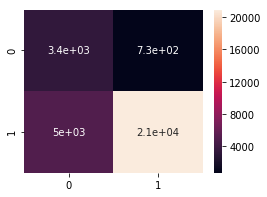

True Negative with 0.1 alpha value is 3390
False Positive with 0.1 alpha value is 730
True Positive with 0.1 alpha value is 20870
False Negative with 0.1 alpha value is 5010


In [43]:
#print confusion matrix for test set
print("Confusion matrix for test set is: \n")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 3))
sns.heatmap(conf_matrix, annot=True)
plt.show()
tn, fp, fn, tp = conf_matrix.ravel()
print('True Negative with %.1f alpha value is %d' % (optimal_alpha, tn))
print('False Positive with %.1f alpha value is %d' % (optimal_alpha, fp))
print('True Positive with %.1f alpha value is %d' % (optimal_alpha, tp))
print('False Negative with %.1f alpha value is %d' % (optimal_alpha, fn))

#### Checking performance with L1 Regularization

In [44]:
#get train and CV data from gridsearch results object for L1
df_auc_results = pd.DataFrame(auc_results)
df_auc_results_l1 = df_auc_results.loc[df_auc_results["param_penalty"] == "l1"]
grd_srch_test = df_auc_results_l1["mean_test_score"].values
grd_srch_train = df_auc_results_l1["mean_train_score"].values
alphaValues = df_auc_results_l1["param_alpha"].values

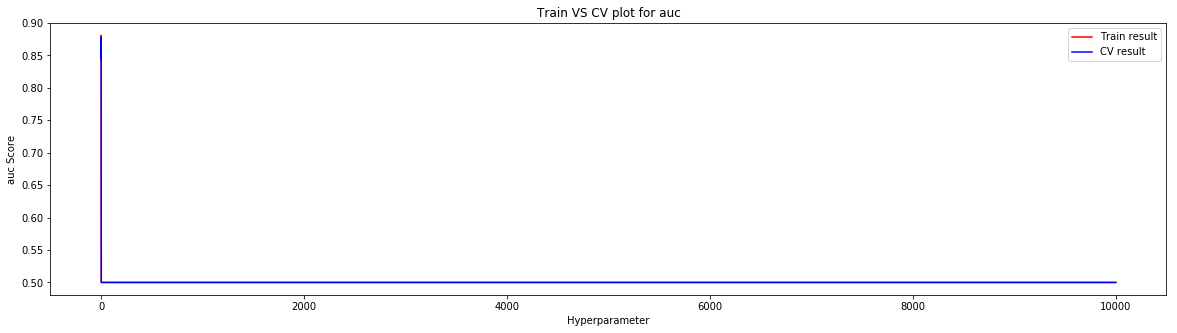

In [45]:
#Plot train vs CV data on the selected C Values on the basis of auc score
PlotTrainVsCVerror(alphaValues,grd_srch_train, grd_srch_test, "auc")

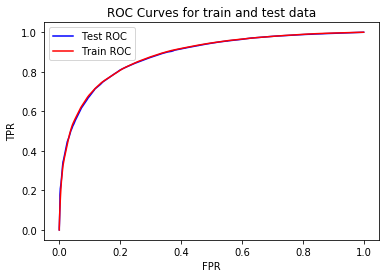

In [46]:
#Now get the model performance metrices on test set with optimal alpha value
optimal_alpha = 0.01 #Let's take the best alpha value for L1 Regularization
sgdc = SGDClassifier(alpha=optimal_alpha, penalty="l1", class_weight = 'balanced', n_jobs = -1)
auc,conf_matrix,weights = CheckTestSetScores(sgdc, X_tfidfw2v_train_std, y_train,X_tfidfw2v_test_std, y_test)

In [47]:
print("auc score for test set with L1 regularization is " + str(auc))

auc score for test set with L1 regularization is 88.32176325385275


Confusion matrix for test set is: 

[[ 3361   759]
 [ 5365 20515]]


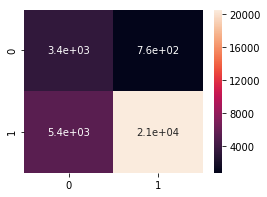

True Negative with 0.01 alpha value is 3361
False Positive with 0.01 alpha value is 759
True Positive with 0.01 alpha value is 20515
False Negative with 0.01 alpha value is 5365


In [49]:
#print confusion matrix for test set
print("Confusion matrix for test set is: \n")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 3))
sns.heatmap(conf_matrix, annot=True)
plt.show()
tn, fp, fn, tp = conf_matrix.ravel()
print('True Negative with %.2f alpha value is %d' % (optimal_alpha, tn))
print('False Positive with %.2f alpha value is %d' % (optimal_alpha, fp))
print('True Positive with %.2f alpha value is %d' % (optimal_alpha, tp))
print('False Negative with %.2f alpha value is %d' % (optimal_alpha, fn))

<b>Observation</b>:  Both L1 and L2 regularization seem to be giving similar performance. But in terms of more true negatives and less false positives, L1 seems to perform better

## [5.2] RBF SVM

In [6]:
from sklearn.svm import SVC
def CheckSVCTestSetScores(clf, x_train, y_train, x_test, y_test):
    """Returns the auc, confusion matrix for given SVC estimator on test/val set"""
    clf.fit(X=x_train,y= y_train)
    ytest_pred = clf.predict(X = x_test)
    ytest_proba = clf.predict_proba(X = x_test)
    ytrain_pred = clf.predict(X = x_train)
    ytrain_proba= clf.predict_proba(X = x_train)
    auc = sklearn.metrics.roc_auc_score(y_test, ytest_proba[:,1]) * float(100)
    conf_matrix = sklearn.metrics.confusion_matrix(y_test, ytest_pred)
    #Plot ROC Curve
    fpr,tpr,thresholds = sklearn.metrics.roc_curve(y_test, ytest_proba[:,1])
    fpr_train,tpr_train,thresholds_train = sklearn.metrics.roc_curve(y_train, ytrain_proba[:,1])
    plt.plot(fpr, tpr, 'b-', label= 'Test ROC')
    plt.plot(fpr_train, tpr_train, 'r-', label= 'Train ROC')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title("ROC Curves for train and test data")
    plt.legend(loc='best')
    plt.show()
    return auc,conf_matrix

In [8]:
#get the data from pre-processed or cleaned data that we saved in the previous assignment
import os
import sqlite3
con = sqlite3.connect('cleaned.sqlite')
#get the 30k records
data = pd.read_sql_query("Select Cleaned_Text,Score from Reviews where Score != 3 order by Time limit 30000", con)
con.close()

In [9]:
#Get input matrix of features X and output vector y
X = data.iloc[:,0]
y = data.iloc[:, 1]

In [10]:
#since I will use gridSearchCV so I will only split the data into train and test set (and skip a separate validation set)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3,shuffle = False, random_state = 0)
print(X_train.shape)
print(X_test.shape)

(21000,)
(9000,)


### [5.2.1] Applying RBF SVM on BOW

In [10]:
#get BOW vector for train data
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(min_df = 10, max_features = 500)
X_BOW_train = cv.fit_transform(X_train)
print(X_BOW_train.shape)

(21000, 500)


In [11]:
#standardize the train data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_BOW_train_std = sc.fit_transform(X_BOW_train)
print(X_BOW_train_std.shape)

(21000, 500)


In [12]:
#Serializing BOW train
with open("X_BOW_train_std_noval_30k.pkl","wb") as f:
     pickle.dump(X_BOW_train_std,f)

In [13]:
#loading BOW train saved previously
with open("X_BOW_train_std_noval_30k.pkl","rb") as f:
    X_BOW_train_std = pickle.load(f)

In [14]:
#tranforming X_test to BOW
X_BOW_test = cv.transform(X_test)
print(X_BOW_test.shape)

(9000, 500)


In [15]:
#standardize the test data
X_BOW_test_std = sc.transform(X_BOW_test)
print(X_BOW_test_std.shape)

(9000, 500)


In [16]:
#Serializing BOW test
with open("X_BOW_test_std_noval_30k.pkl","wb") as f:
     pickle.dump(X_BOW_test_std,f)

In [17]:
#loading BOW test saved previously
with open("X_BOW_test_std_noval_30k.pkl","rb") as f:
    X_BOW_test_std = pickle.load(f)

In [18]:
#Define parameters and SVC estimator to be used in GridSearchCV
parameters = {'C':[2**-5,2**-3,2**-1,2,8,32]} #I will use gamma as 'auto' to save time during parameter tuning
clf = SVC(kernel = 'rbf', class_weight = 'balanced')

In [19]:
#check best params using gridsearch on the basis of auc score
auc_results,best_auc,best_estimator_auc = PerformGridSearchCV(clf, parameters, 3, "roc_auc", X_BOW_train_std, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  6.6min finished


GridSearchCV took 472.68 seconds for 6 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.889 (std: 0.010)
Parameters: {'C': 0.125}

Model with rank: 2
Mean validation score: 0.885 (std: 0.009)
Parameters: {'C': 0.5}

Model with rank: 3
Mean validation score: 0.882 (std: 0.012)
Parameters: {'C': 2}

Model with rank: 4
Mean validation score: 0.875 (std: 0.011)
Parameters: {'C': 8}

Model with rank: 5
Mean validation score: 0.865 (std: 0.012)
Parameters: {'C': 32}



In [21]:
#get train and CV data from gridsearch results object
df_auc_results = pd.DataFrame(auc_results)
grd_srch_test = df_auc_results["mean_test_score"].values
grd_srch_train = df_auc_results["mean_train_score"].values
alphaValues = df_auc_results["param_C"].values

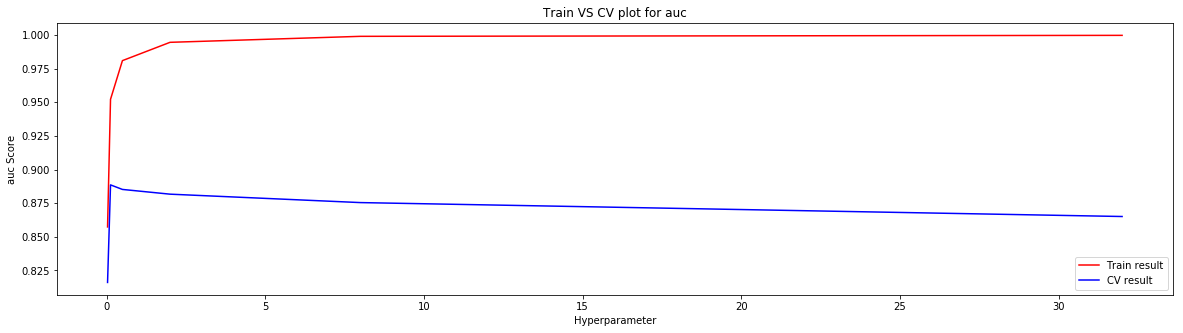

In [22]:
#Plot train vs CV data on the selected C Values on the basis of auc score
PlotTrainVsCVerror(alphaValues,grd_srch_train, grd_srch_test, "auc")

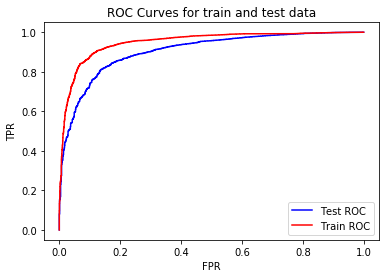

In [28]:
#Now get the model performance metrices on test set with optimal C value
optimal_C = 0.125
svc = SVC(C = optimal_C, kernel = 'rbf', class_weight = 'balanced', probability = True)
auc,conf_matrix = CheckSVCTestSetScores(svc, X_BOW_train_std, y_train,X_BOW_test_std, y_test)

In [29]:
print("auc score for test set is " + str(auc))

auc score for test set is 90.47072686678244


Confusion matrix for test set is: 

[[ 741  197]
 [1085 6977]]


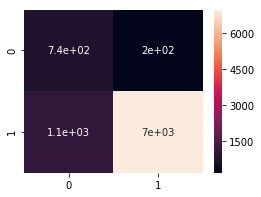

True Negative with 0.125 C value is 741
False Positive with 0.125 C value is 197
True Positive with 0.125 C value is 6977
False Negative with 0.125 C value is 1085


In [32]:
#print confusion matrix for test set
print("Confusion matrix for test set is: \n")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 3))
sns.heatmap(conf_matrix, annot=True)
plt.show()
tn, fp, fn, tp = conf_matrix.ravel()
print('True Negative with %.3f C value is %d' % (optimal_C, tn))
print('False Positive with %.3f C value is %d' % (optimal_C, fp))
print('True Positive with %.3f C value is %d' % (optimal_C, tp))
print('False Negative with %.3f C value is %d' % (optimal_C, fn))

### [5.2.2] Applying RBF SVM on TFIDF

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(min_df = 10, max_features = 500)
X_tfidf_train = tfidf_vect.fit_transform(X_train)
print(X_tfidf_train.shape)

(21000, 500)


In [72]:
#standardize the tfidf train data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_tfidf_train_std = sc.fit_transform(X_tfidf_train)
print(X_tfidf_train_std.shape)

(21000, 500)


In [73]:
#serializing tfidf train std
with open("X_tfidf_train_std_noval_30k.pkl","wb") as f:
     pickle.dump(X_tfidf_train_std,f)

In [74]:
#loading tfidf train std saved previously
with open("X_tfidf_train_std_noval_30k.pkl","rb") as f:
    X_tfidf_train_std = pickle.load(f)

In [75]:
#tranforming X_test to tfidf
X_tfidf_test = tfidf_vect.transform(X_test)
print(X_tfidf_test.shape)

(9000, 500)


In [76]:
#standardize the tfidf test data
X_tfidf_test_std = sc.transform(X_tfidf_test)
print(X_tfidf_test_std.shape)

(9000, 500)


In [77]:
#serializing tfidf test std data
with open("X_tfidf_test_std_noval_30k.pkl","wb") as f:
     pickle.dump(X_tfidf_test_std,f)

In [78]:
#loading tfidf test std saved previously
with open("X_tfidf_test_std_noval_30k.pkl","rb") as f:
    X_tfidf_test_std = pickle.load(f)

In [79]:
#Define parameters and SVC estimator to be used in GridSearchCV
parameters = {'C':[2**-5,2**-3,2**-1,2,8,32]} #I will use gamma as 'auto' to save time during parameter tuning
clf = SVC(kernel = 'rbf', class_weight = 'balanced')

In [80]:
#check best params using gridsearch on the basis of auc score
auc_results,best_auc,best_estimator_auc = PerformGridSearchCV(clf, parameters, 3, "roc_auc", X_tfidf_train_std, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  9.0min finished


GridSearchCV took 700.85 seconds for 6 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.896 (std: 0.008)
Parameters: {'C': 2}

Model with rank: 2
Mean validation score: 0.896 (std: 0.007)
Parameters: {'C': 8}

Model with rank: 3
Mean validation score: 0.895 (std: 0.007)
Parameters: {'C': 32}



In [83]:
#get train and CV data from gridsearch results object
df_auc_results = pd.DataFrame(auc_results)
grd_srch_test = df_auc_results["mean_test_score"].values
grd_srch_train = df_auc_results["mean_train_score"].values
alphaValues = df_auc_results["param_C"].values

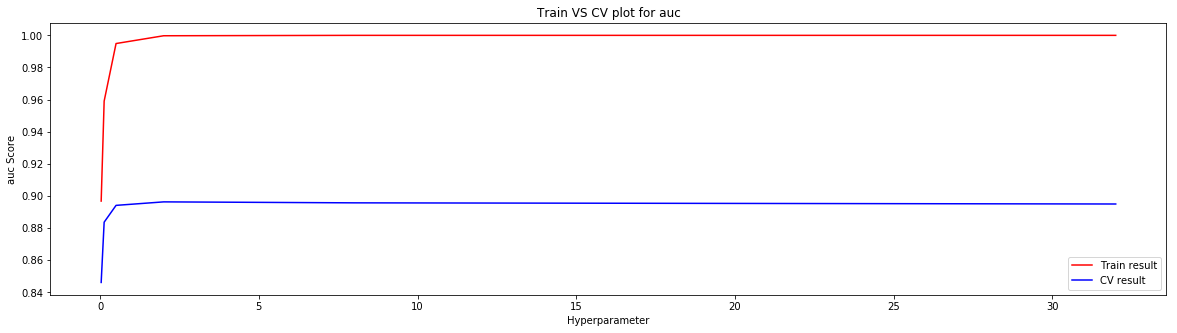

In [84]:
#Plot train vs CV data on the selected C Values on the basis of auc score
PlotTrainVsCVerror(alphaValues,grd_srch_train, grd_srch_test, "auc")

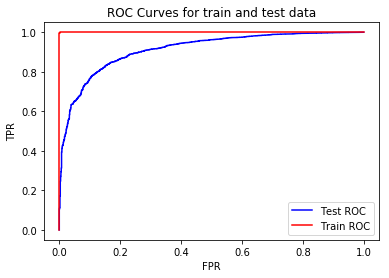

In [85]:
#Now get the model performance metrices on test set with optimal C value
optimal_C = 2
svc = SVC(C = optimal_C, kernel = 'rbf', class_weight = 'balanced', probability = True)
auc,conf_matrix = CheckSVCTestSetScores(svc, X_tfidf_train_std, y_train,X_tfidf_test_std, y_test)

In [86]:
print("auc score for test set is " + str(auc))

auc score for test set is 91.34974866955932


Confusion matrix for test set is: 

[[ 368  570]
 [ 194 7868]]


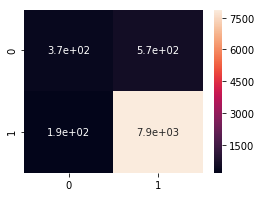

True Negative with C value 2.0 is 368
False Positive with C value 2.0 is 570
True Positive with C value 2.0 is 7868
False Negative with C value 2.0 is 194


In [87]:
#print confusion matrix for test set
print("Confusion matrix for test set is: \n")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 3))
sns.heatmap(conf_matrix, annot=True)
plt.show()
tn, fp, fn, tp = conf_matrix.ravel()
print('True Negative with C value %.1f is %d' % (optimal_C, tn))
print('False Positive with C value %.1f is %d' % (optimal_C, fp))
print('True Positive with C value %.1f is %d' % (optimal_C, tp))
print('False Negative with C value %.1f is %d' % (optimal_C, fn))

### [5.2.3]  Applying RBF SVM on AVG W2V

In [31]:
def Get_List_Reviews(X_type):
    """get list of words for all review for the given X_type"""
    list_of_reviews = []
    for review in X_type.values:
        list_of_reviews.append(review.split())
    return list_of_reviews

In [32]:
#converting X_train into list of words for each review
list_of_reviews_train = Get_List_Reviews(X_train)
print(len(list_of_reviews_train))

21000


In [33]:
#converting X_test into list of words for each review
list_of_reviews_test = Get_List_Reviews(X_test)
print(len(list_of_reviews_test))

9000


In [34]:
from gensim.models import Word2Vec
#train avg w2v on list_of_reviews_train
w2v_model = Word2Vec(list_of_reviews_train, min_count=5,size=300, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("w2v model trained")

w2v model trained


In [58]:
#writing code to generate X_avgw2v_type using avg w2v
def Get_Avg_W2v(list_of_reviews):
    from tqdm import tqdm
    review_word_vector = []
    for review in tqdm(list_of_reviews):
        w2v_vector = np.zeros(300)
        for word in review:
            word_count = 0
            if(word in w2v_words):
                w2v_vector += w2v_model.wv[word]
                word_count += 1
        if word_count != 0:
            w2v_vector /= word_count
        review_word_vector.append(w2v_vector)
    return review_word_vector

In [63]:
#get avg w2v for train data
X_avgw2v_train = Get_Avg_W2v(list_of_reviews_train)
print(len(X_avgw2v_train))
print(len(X_avgw2v_train[0]))

100%|██████████| 21000/21000 [00:21<00:00, 969.57it/s] 


21000
300


In [12]:
#standardize the train data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_avgw2v_train_std = sc.fit_transform(X_avgw2v_train)
print(X_avgw2v_train_std.shape)

(21000, 300)


In [ ]:
#serializing avg w2v train std
with open("X_avgw2v_train_std_noval_30k_300dim.pkl","wb") as f:
     pickle.dump(X_avgw2v_train_std,f)

In [14]:
#loading avg w2v train std saved previously
with open("X_avgw2v_train_std_noval_30k_300dim.pkl","rb") as f:
    X_avgw2v_train_std = pickle.load(f)

In [66]:
#get avg w2v for test data
X_avgw2v_test = Get_Avg_W2v(list_of_reviews_test)
print(len(X_avgw2v_test))
print(len(X_avgw2v_test[0]))

100%|██████████| 9000/9000 [00:09<00:00, 966.94it/s] 


9000
300


In [16]:
#standardize the avg w2v test data
X_avgw2v_test_std = sc.transform(X_avgw2v_test)
print(X_avgw2v_test_std.shape)

(9000, 300)


In [ ]:
#serializing avg w2v test std
with open("X_avgw2v_test_std_noval_30k_300dim.pkl","wb") as f:
     pickle.dump(X_avgw2v_test_std,f)

In [18]:
#loading avg w2v test std saved previously
with open("X_avgw2v_test_std_noval_30k_300dim.pkl","rb") as f:
    X_avgw2v_test_std = pickle.load(f)

In [19]:
#Define parameters and SVC estimator to be used in GridSearchCV
parameters = {'C':[2**-5,2**-3,2**-1,2,8,32]} #I will use gamma as 'auto' to save time during parameter tuning
clf = SVC(kernel = 'rbf', class_weight = 'balanced')

In [20]:
#check best params using gridsearch on the basis of auc score
auc_results,best_auc,best_estimator_auc = PerformGridSearchCV(clf, parameters, 3, "roc_auc", X_avgw2v_train_std, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 22.4min finished


GridSearchCV took 1582.24 seconds for 6 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.882 (std: 0.008)
Parameters: {'C': 0.5}

Model with rank: 2
Mean validation score: 0.880 (std: 0.008)
Parameters: {'C': 2}

Model with rank: 3
Mean validation score: 0.875 (std: 0.009)
Parameters: {'C': 0.125}



In [21]:
#get train and CV data from gridsearch results object
df_auc_results = pd.DataFrame(auc_results)
grd_srch_test = df_auc_results["mean_test_score"].values
grd_srch_train = df_auc_results["mean_train_score"].values
alphaValues = df_auc_results["param_C"].values

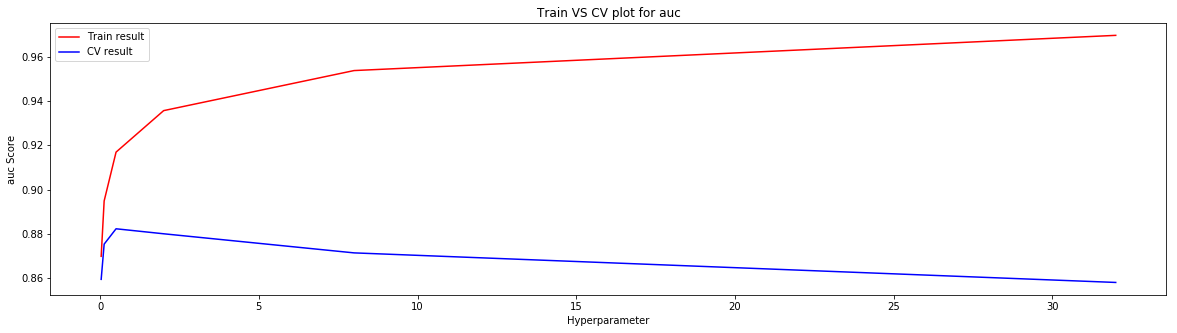

In [22]:
#Plot train vs CV data on the selected C Values on the basis of auc score
PlotTrainVsCVerror(alphaValues,grd_srch_train, grd_srch_test, "auc")

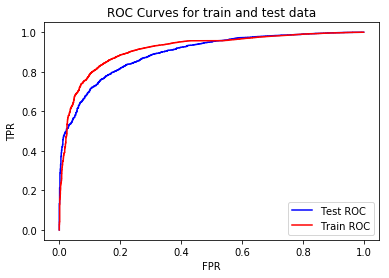

In [23]:
#Now get the model performance metrices on test set with optimal C value
optimal_C = 0.5
svc = SVC(C = optimal_C, kernel = 'rbf', class_weight = 'balanced', probability = True)
auc,conf_matrix = CheckSVCTestSetScores(svc, X_avgw2v_train_std, y_train,X_avgw2v_test_std, y_test)

In [24]:
print("auc score for test set is " + str(auc))

auc score for test set is 89.44041884351499


Confusion matrix for test set is: 

[[ 734  204]
 [1355 6707]]


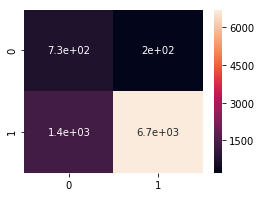

True Negative with 0.5 C value is 734
False Positive with 0.5 C value is 204
True Positive with 0.5 C value is 6707
False Negative with 0.5 C value is 1355


In [25]:
#print confusion matrix for test set
print("Confusion matrix for test set is: \n")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 3))
sns.heatmap(conf_matrix, annot=True)
plt.show()
tn, fp, fn, tp = conf_matrix.ravel()
print('True Negative with %.1f C value is %d' % (optimal_C, tn))
print('False Positive with %.1f C value is %d' % (optimal_C, fp))
print('True Positive with %.1f C value is %d' % (optimal_C, tp))
print('False Negative with %.1f C value is %d' % (optimal_C, fn))

### [5.2.4]  Applying RBF SVM on TFIDF W2V

In [28]:
#save tfidf scores of all the cleaned words from all the reviews in a dictionary
dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))

In [29]:
#code to vectorize reviews using tf-idf w2v
def Get_Tfidfw2v_Vector(list_of_reviews):
    from tqdm import tqdm
    tfidf_feat = tfidf_vect.get_feature_names() # tfidf words/col-names
    tfidf_w2v = []
    for row,review in enumerate(tqdm(list_of_reviews)):
        review_vect = np.zeros(300)
        tfidf_sum = 0
        for word in review:
            if(word in w2v_words and word in dictionary):
                #tf_idf = tfidf_data[row, tfidf_feat.index(word)]
                tf_idf = dictionary[word] * review.count(word)/len(review)
                tfidf_sum += tf_idf
                #pdb.set_trace()
                review_vect += w2v_model.wv[word] * tf_idf
        if tfidf_sum != 0:
            review_vect /= tfidf_sum
        tfidf_w2v.append(review_vect)
    return tfidf_w2v

In [35]:
#get tfidf w2v for train data
X_tfidfw2v_train = Get_Tfidfw2v_Vector(list_of_reviews_train)
print(len(X_tfidfw2v_train))

100%|██████████| 21000/21000 [00:37<00:00, 561.71it/s]


21000


In [38]:
#standardize the train data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_tfidfw2v_train_std = sc.fit_transform(X_tfidfw2v_train)
print(X_tfidfw2v_train_std.shape)

(21000, 300)


In [ ]:
#serializing tfidf w2v train std
with open("X_tfidfw2v_train_std_noval_30k_300dim.pkl","wb") as f:
     pickle.dump(X_tfidfw2v_train_std,f)

In [40]:
#loading tfidf w2v train std saved previously
with open("X_tfidfw2v_train_std_noval_30k_300dim.pkl","rb") as f:
    X_tfidfw2v_train_std = pickle.load(f)

In [41]:
#get tfidf w2v for test data
X_tfidfw2v_test = Get_Tfidfw2v_Vector(list_of_reviews_test)
print(len(X_tfidfw2v_test))

100%|██████████| 9000/9000 [00:15<00:00, 573.90it/s]


9000


In [44]:
#standardize the tfidf w2v test data
X_tfidfw2v_test_std = sc.transform(X_tfidfw2v_test)
print(X_tfidfw2v_test_std.shape)

(9000, 300)


In [ ]:
#serializing tfidf w2v train std
with open("X_tfidfw2v_test_std_noval_30k_300dim.pkl","wb") as f:
     pickle.dump(X_tfidfw2v_test_std,f)

In [46]:
#loading tfidf w2v test std saved previously
with open("X_tfidfw2v_test_std_noval_30k_300dim.pkl","rb") as f:
    X_tfidfw2v_test_std = pickle.load(f)

In [47]:
#Define parameters and SVC estimator to be used in GridSearchCV
parameters = {'C':[2**-5,2**-3,2**-1,2,8,32]} #I will use gamma as 'auto' to save time during parameter tuning
clf = SVC(kernel = 'rbf', class_weight = 'balanced')

In [48]:
#check best params using gridsearch on the basis of auc score
auc_results,best_auc,best_estimator_auc = PerformGridSearchCV(clf, parameters, 3, "roc_auc", X_tfidfw2v_train_std, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 19.9min finished


GridSearchCV took 1447.32 seconds for 6 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.847 (std: 0.004)
Parameters: {'C': 0.5}

Model with rank: 2
Mean validation score: 0.842 (std: 0.002)
Parameters: {'C': 2}

Model with rank: 3
Mean validation score: 0.840 (std: 0.007)
Parameters: {'C': 0.125}



In [49]:
#get train and CV data from gridsearch results object
df_auc_results = pd.DataFrame(auc_results)
grd_srch_test = df_auc_results["mean_test_score"].values
grd_srch_train = df_auc_results["mean_train_score"].values
alphaValues = df_auc_results["param_C"].values

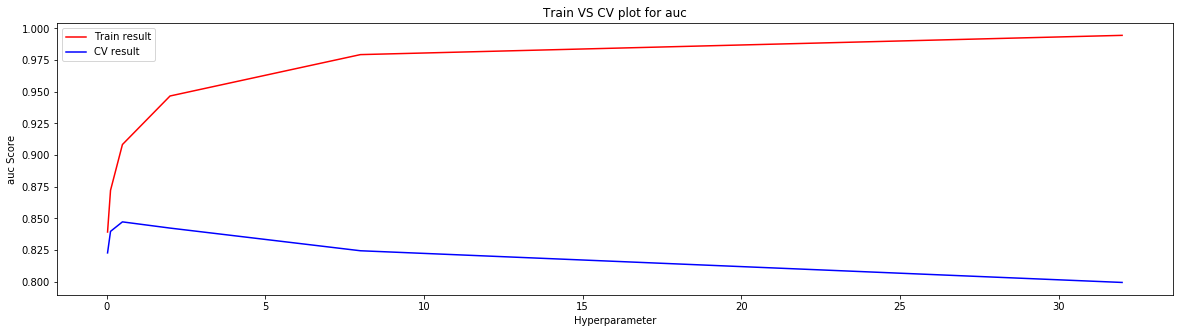

In [50]:
#Plot train vs CV data on the selected C Values on the basis of auc score
PlotTrainVsCVerror(alphaValues,grd_srch_train, grd_srch_test, "auc")

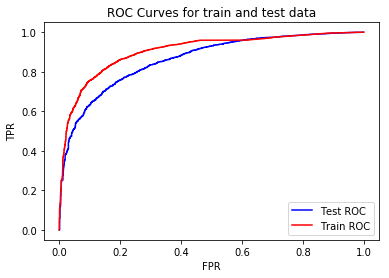

In [51]:
#Now get the model performance metrices on test set with optimal C value
optimal_C = 0.5
svc = SVC(C = optimal_C, kernel = 'rbf', class_weight = 'balanced', probability = True)
auc,conf_matrix = CheckSVCTestSetScores(svc, X_tfidfw2v_train_std, y_train,X_tfidfw2v_test_std, y_test)

In [52]:
print("auc score for test set is " + str(auc))

auc score for test set is 86.2334233782006


Confusion matrix for test set is: 

[[ 698  240]
 [1618 6444]]


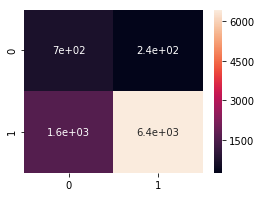

True Negative with 0.5 C value is 698
False Positive with 0.5 C value is 240
True Positive with 0.5 C value is 6444
False Negative with 0.5 C value is 1618


In [53]:
#print confusion matrix for test set
print("Confusion matrix for test set is: \n")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 3))
sns.heatmap(conf_matrix, annot=True)
plt.show()
tn, fp, fn, tp = conf_matrix.ravel()
print('True Negative with %.1f C value is %d' % (optimal_C, tn))
print('False Positive with %.1f C value is %d' % (optimal_C, fp))
print('True Positive with %.1f C value is %d' % (optimal_C, tp))
print('False Negative with %.1f C value is %d' % (optimal_C, fn))

# [6] Conclusions

In [60]:
#Printing results for SGDRegressor with hinge loss
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "alpha Value","Regularization","AUC Score", "True Neg", "False Pos", "True Pos", "False Neg"]
x.add_row(["BOW", 1,"L2", 92.02, 3335,785,23356, 2524])
x.add_row(["TFIDF", 10,"L2",92.35, 3417, 703, 22411, 3469])
x.add_row(["Avg Word2Vec",0.1,"L2", 90.33, 3436, 684, 21680, 4200])
x.add_row(["TFIDF Word2Vec", 0.01,"L1",88.32, 3361, 759, 20515, 5365])
print("Results for Linear SVC")
print(x)

Results for Linear SVC
+----------------+-------------+----------------+-----------+----------+-----------+----------+-----------+
|   Vectorizer   | alpha Value | Regularization | AUC Score | True Neg | False Pos | True Pos | False Neg |
+----------------+-------------+----------------+-----------+----------+-----------+----------+-----------+
|      BOW       |      1      |       L2       |   92.02   |   3335   |    785    |  23356   |    2524   |
|     TFIDF      |      10     |       L2       |   92.35   |   3417   |    703    |  22411   |    3469   |
|  Avg Word2Vec  |     0.1     |       L2       |   90.33   |   3436   |    684    |  21680   |    4200   |
| TFIDF Word2Vec |     0.01    |       L1       |   88.32   |   3361   |    759    |  20515   |    5365   |
+----------------+-------------+----------------+-----------+----------+-----------+----------+-----------+


In [61]:
#Printing results for SVC with RBF
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "C Value","AUC Score", "True Neg", "False Pos", "True Pos", "False Neg"]
x.add_row(["BOW", 0.125, 90.47, 741,197,6977, 1085])
x.add_row(["TFIDF", 2, 91.34, 368,570,7868, 194])
x.add_row(["Avg Word2Vec",0.5, 89.44, 734,204,6707, 1355])
x.add_row(["TFIDF Word2Vec", 0.5, 86.23, 698,240,6444, 1618])
print("Results for RBF SVC")
print(x)

Results for RBF SVC
+----------------+---------+-----------+----------+-----------+----------+-----------+
|   Vectorizer   | C Value | AUC Score | True Neg | False Pos | True Pos | False Neg |
+----------------+---------+-----------+----------+-----------+----------+-----------+
|      BOW       |  0.125  |   90.47   |   741    |    197    |   6977   |    1085   |
|     TFIDF      |    2    |   91.34   |   368    |    570    |   7868   |    194    |
|  Avg Word2Vec  |   0.5   |   89.44   |   734    |    204    |   6707   |    1355   |
| TFIDF Word2Vec |   0.5   |   86.23   |   698    |    240    |   6444   |    1618   |
+----------------+---------+-----------+----------+-----------+----------+-----------+


# Section 6: Decision Trees

# Applying Decision Trees

In [4]:
from sklearn.tree import DecisionTreeClassifier
def CheckTestSetScores(clf, x_train, y_train, x_test, y_test):
    """Returns the auc, confusion matrix for given estimator on test/val set"""
    clf.fit(X=x_train,y= y_train)
    ytest_pred = clf.predict(X = x_test)
    ytest_proba = clf.predict_proba(X = x_test)
    ytrain_pred = clf.predict(X = x_train)
    ytrain_proba= clf.predict_proba(X = x_train)
    auc = sklearn.metrics.roc_auc_score(y_test, ytest_proba[:,1]) * float(100)
    conf_matrix = sklearn.metrics.confusion_matrix(y_test, ytest_pred)
    feature_importances = clf.feature_importances_
    #Plot ROC Curve
    fpr,tpr,thresholds = sklearn.metrics.roc_curve(y_test, ytest_proba[:,1])
    fpr_train,tpr_train,thresholds_train = sklearn.metrics.roc_curve(y_train, ytrain_proba[:,1])
    plt.plot(fpr, tpr, 'b-', label= 'Test ROC')
    plt.plot(fpr_train, tpr_train, 'r-', label= 'Train ROC')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title("ROC Curves for train and test data")
    plt.legend(loc='best')
    plt.show()
    #print(conf_matrix)
    return auc,conf_matrix,feature_importances

In [6]:
#get the data from pre-processed or cleaned data that we saved in the previous assignment
import os
import sqlite3
con = sqlite3.connect('cleaned.sqlite')
data = pd.read_sql_query("Select Cleaned_Text,Score from Reviews where Score != 3 order by Time limit 100000", con)
con.close()

In [7]:
#Get input matrix of features X and output vector y
X = data.iloc[:,0]
y = data.iloc[:, 1]

In [8]:
#since I will use gridSearchCV so I will only split the data into train and test set (and skip a separate validation set)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3,shuffle = False, random_state = 0)
print(X_train.shape)
print(X_test.shape)

(70000,)
(30000,)


## [6.1] Applying Decision Trees on BOW

In [9]:
#get BOW vector for train data
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_BOW_train = cv.fit_transform(X_train)
print(X_BOW_train.shape)

(70000, 36445)


In [10]:
#Get BOW test set
X_BOW_test = cv.transform(X_test)
print(X_BOW_test.shape)

(30000, 36445)


In [39]:
#Define parameters and SGDClassifier estimator to be used in GridSearchCV
parameters = {'min_samples_split':[5, 10, 100, 500],'max_depth':[1, 5, 10, 50, 100, 500, 1000]}
clf = DecisionTreeClassifier(class_weight = 'balanced')

In [40]:
#check best params using gridsearch on the basis of auc score
auc_results,best_auc,best_estimator_auc = PerformGridSearchCV(clf, parameters, 3, "roc_auc", X_BOW_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:  4.1min finished


GridSearchCV took 256.11 seconds for 28 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.800 (std: 0.004)
Parameters: {'max_depth': 50, 'min_samples_split': 500}

Model with rank: 2
Mean validation score: 0.793 (std: 0.005)
Parameters: {'max_depth': 100, 'min_samples_split': 500}

Model with rank: 3
Mean validation score: 0.789 (std: 0.007)
Parameters: {'max_depth': 10, 'min_samples_split': 500}

Model with rank: 4
Mean validation score: 0.781 (std: 0.005)
Parameters: {'max_depth': 10, 'min_samples_split': 100}

Model with rank: 5
Mean validation score: 0.777 (std: 0.007)
Parameters: {'max_depth': 1000, 'min_samples_split': 500}



<b>Observation:</b> For top 5 results from gridsearch, we have the value of min_samples_split = 500 in 4 results. Hence I will consider this value along with max_depth of 50

In [41]:
#get train and CV data from gridsearch results object
df_auc_results = pd.DataFrame(auc_results)
df_auc_results_mss500 = df_auc_results.loc[df_auc_results["param_min_samples_split"] == 500]
grd_srch_test = df_auc_results_mss500["mean_test_score"].values
grd_srch_train = df_auc_results_mss500["mean_train_score"].values
maxDepthValues = df_auc_results_mss500["param_max_depth"].values

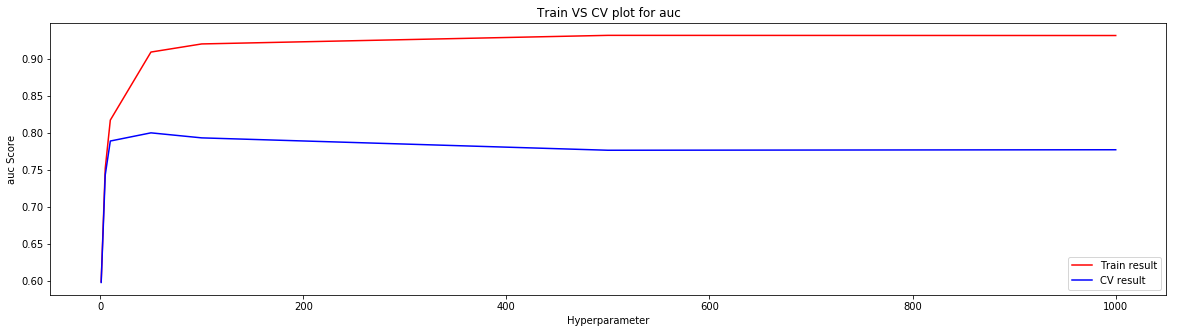

In [42]:
#Plot train vs CV data on for max_depth while fixing min_samples_split to 500
PlotTrainVsCVerror(maxDepthValues,grd_srch_train, grd_srch_test, "auc")

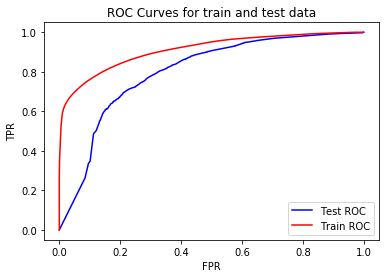

In [11]:
#Now get the model performance metrices on test set with tuned hyperparameter
optimal_min_samples_split = 500
optimal_max_depth = 50
dtc = DecisionTreeClassifier(class_weight = 'balanced', max_depth = optimal_max_depth, min_samples_split = optimal_min_samples_split)
auc,conf_matrix,feature_importances = CheckTestSetScores(dtc, X_BOW_train, y_train,X_BOW_test, y_test)

auc score for test set is 80.00206470115994
Confusion matrix for test set is:
[[ 3045  1075]
 [ 6834 19046]]


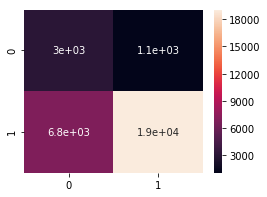

True Negative with optimal hyperparameters is 3045
False Positive with optimal hyperparameters is 1075
True Positive with optimal hyperparameters is 19046
False Negative with optimal hyperparameters is 6834


In [12]:
print("auc score for test set is " + str(auc))
#print confusion matrix for test set
print("Confusion matrix for test set is:")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 3))
sns.heatmap(conf_matrix, annot=True)
plt.show()
tn, fp, fn, tp = conf_matrix.ravel()
print('True Negative with optimal hyperparameters is %d' % (tn))
print('False Positive with optimal hyperparameters is %d' % (fp))
print('True Positive with optimal hyperparameters is %d' % (tp))
print('False Negative with optimal hyperparameters is %d' % (fn))

### [6.1.1] Top 20 important features from

In [24]:
#sort the weights in descending and take the top 10 indices which will correspond to positive review
pos_class_prob_sorted = np.argsort(feature_importances)[::-1]
print("Most important words are")
#get top 10 features for positive reviews
print(np.take(cv.get_feature_names(), pos_class_prob_sorted)[:20]) 

Most important words are
['great' 'not' 'best' 'disappoint' 'love' 'delici' 'perfect' 'good'
 'excel' 'bad' 'favorit' 'nice' 'unfortun' 'tast' 'thought' 'tasti' 'easi'
 'terribl' 'wonder' 'howev']


### [6.1.2] Graphviz visualization of Decision Tree on BOW

In [54]:
#generating dot file which will be used for generating into png format
with open("DT_classifier.dot", "w") as f:
    f = sklearn.tree.export_graphviz(dtc,feature_names = cv.get_feature_names(),max_depth =3, out_file=f)

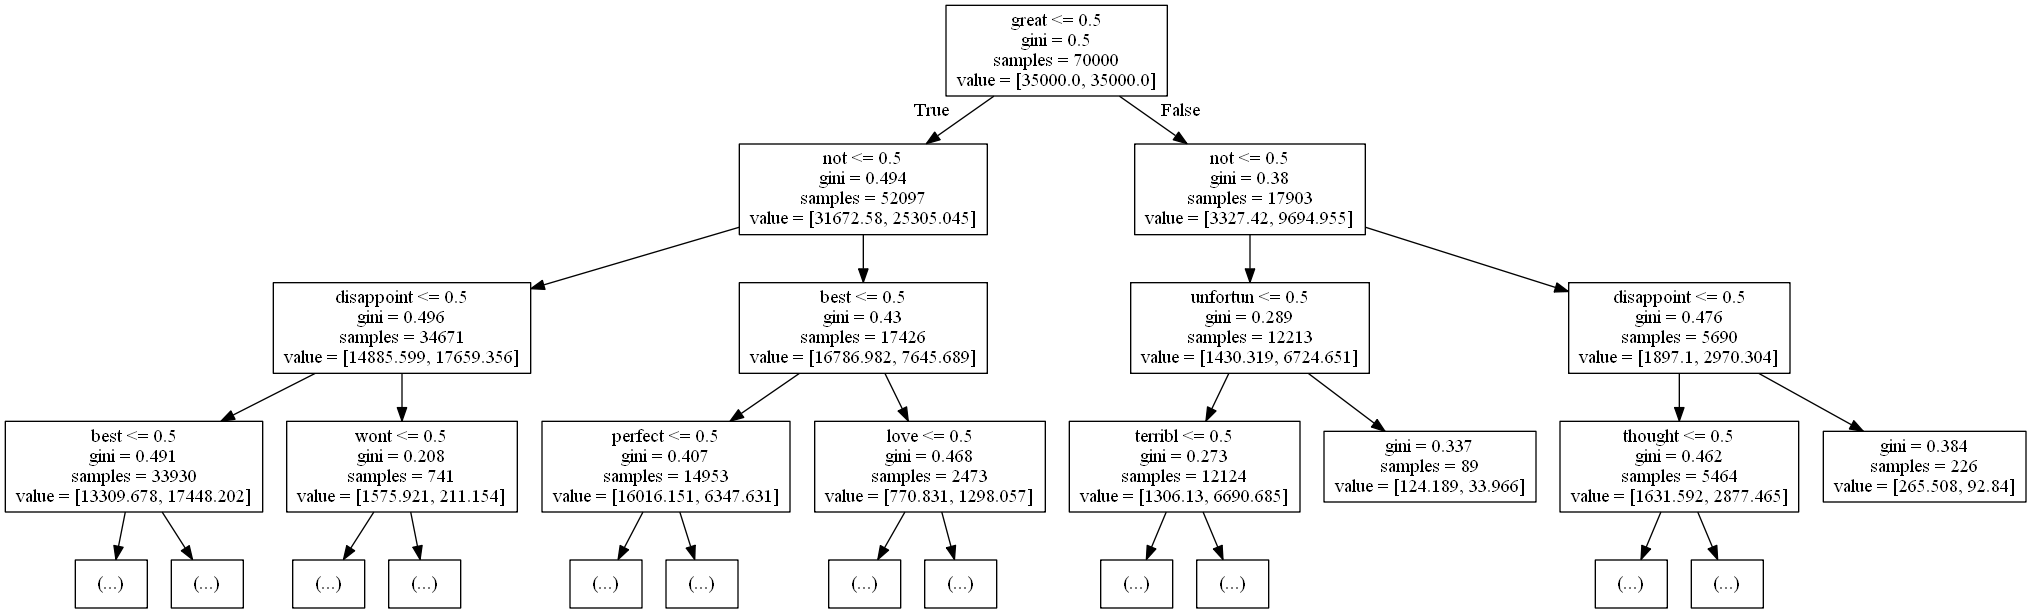

In [14]:
#displaying the Decision tree
from IPython.display import Image
Image("DT_classifier.png") #I used GVEdit.exe to convert .dot file to .png file

## [6.2] Applying Decision Trees on TFIDF

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
X_tfidf_train = tfidf_vect.fit_transform(X_train)
print(X_tfidf_train.shape)

(70000, 36445)


In [26]:
#Get tfidf test set
X_tfidf_test = cv.transform(X_test)
print(X_tfidf_test.shape)

(30000, 36445)


In [27]:
#Define parameters and SGDClassifier estimator to be used in GridSearchCV
parameters = {'min_samples_split':[5, 10, 100, 500],'max_depth':[1, 5, 10, 50, 100, 500, 1000]}
clf = DecisionTreeClassifier(class_weight = 'balanced')

In [28]:
#check best params using gridsearch on the basis of auc score
auc_results,best_auc,best_estimator_auc = PerformGridSearchCV(clf, parameters, 3, "roc_auc", X_tfidf_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:  8.8min finished


GridSearchCV took 547.44 seconds for 28 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.789 (std: 0.004)
Parameters: {'max_depth': 50, 'min_samples_split': 500}

Model with rank: 2
Mean validation score: 0.784 (std: 0.007)
Parameters: {'max_depth': 10, 'min_samples_split': 500}

Model with rank: 3
Mean validation score: 0.777 (std: 0.005)
Parameters: {'max_depth': 10, 'min_samples_split': 100}

Model with rank: 4
Mean validation score: 0.775 (std: 0.006)
Parameters: {'max_depth': 100, 'min_samples_split': 500}

Model with rank: 5
Mean validation score: 0.769 (std: 0.009)
Parameters: {'max_depth': 10, 'min_samples_split': 5}



<b>Observation:</b> Since min_samples_split = 500 is included in 3 out of 5 top results, I will go with that. For max depth, I have taken 10 as it gives better AUC score on actual test set as shown below

In [29]:
#get train and CV data from gridsearch results object
df_auc_results = pd.DataFrame(auc_results)
df_auc_results_mss500 = df_auc_results.loc[df_auc_results["param_min_samples_split"] == 500]
grd_srch_test = df_auc_results_mss500["mean_test_score"].values
grd_srch_train = df_auc_results_mss500["mean_train_score"].values
maxDepthValues = df_auc_results_mss500["param_max_depth"].values

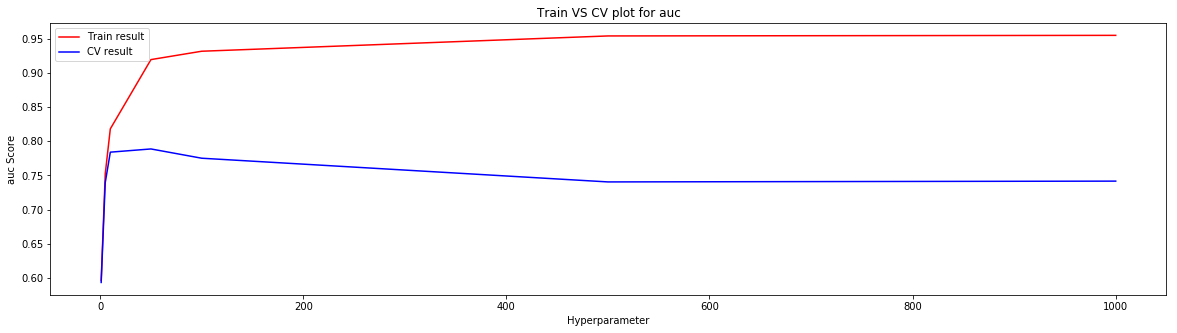

In [30]:
#Plot train vs CV data on for max_depth while fixing min_samples_split to 500
PlotTrainVsCVerror(maxDepthValues,grd_srch_train, grd_srch_test, "auc")

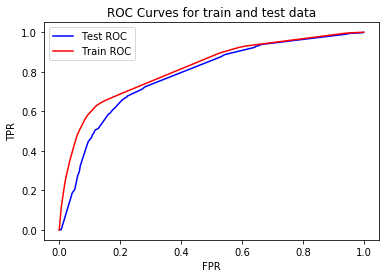

In [36]:
#Now get the model performance metrices on test set with tuned hyperparameter
optimal_min_samples_split = 500
optimal_max_depth = 10
dtc = DecisionTreeClassifier(class_weight = 'balanced', max_depth = optimal_max_depth, min_samples_split = optimal_min_samples_split)
auc,conf_matrix,feature_importances = CheckTestSetScores(dtc, X_tfidf_train, y_train,X_tfidf_test, y_test)

auc score for test set is 78.00795822016478
Confusion matrix for test set is:
[[ 3244   876]
 [ 8684 17196]]


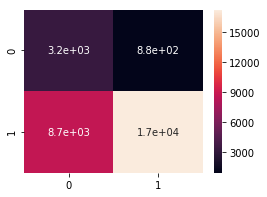

True Negative with optimal hyperparameters is 3244
False Positive with optimal hyperparameters is 876
True Positive with optimal hyperparameters is 17196
False Negative with optimal hyperparameters is 8684


In [37]:
#print the model performace metrices
print("auc score for test set is " + str(auc))
#print confusion matrix for test set
print("Confusion matrix for test set is:")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 3))
sns.heatmap(conf_matrix, annot=True)
plt.show()
tn, fp, fn, tp = conf_matrix.ravel()
print('True Negative with optimal hyperparameters is %d' % (tn))
print('False Positive with optimal hyperparameters is %d' % (fp))
print('True Positive with optimal hyperparameters is %d' % (tp))
print('False Negative with optimal hyperparameters is %d' % (fn))

### [6.2.1] Top 20 important features from

In [38]:
#sort the weights in descending and take the top 10 indices which will correspond to positive review
pos_class_prob_sorted = np.argsort(feature_importances)[::-1]
print("Most important words are")
#get top 10 features for positive reviews
print(np.take(tfidf_vect.get_feature_names(), pos_class_prob_sorted)[:20]) 

Most important words are
['not' 'great' 'best' 'disappoint' 'love' 'delici' 'perfect' 'good'
 'excel' 'favorit' 'thought' 'nice' 'howev' 'horribl' 'unfortun' 'terribl'
 'bad' 'tast' 'wont' 'away']


### [6.2.2] Graphviz visualization of Decision Tree on TFIDF

In [39]:
#generating dot file which will be used for generating into png format
with open("DT_classifier_tfidf.dot", "w") as f:
    f = sklearn.tree.export_graphviz(dtc,feature_names = tfidf_vect.get_feature_names(),max_depth =3, out_file=f)

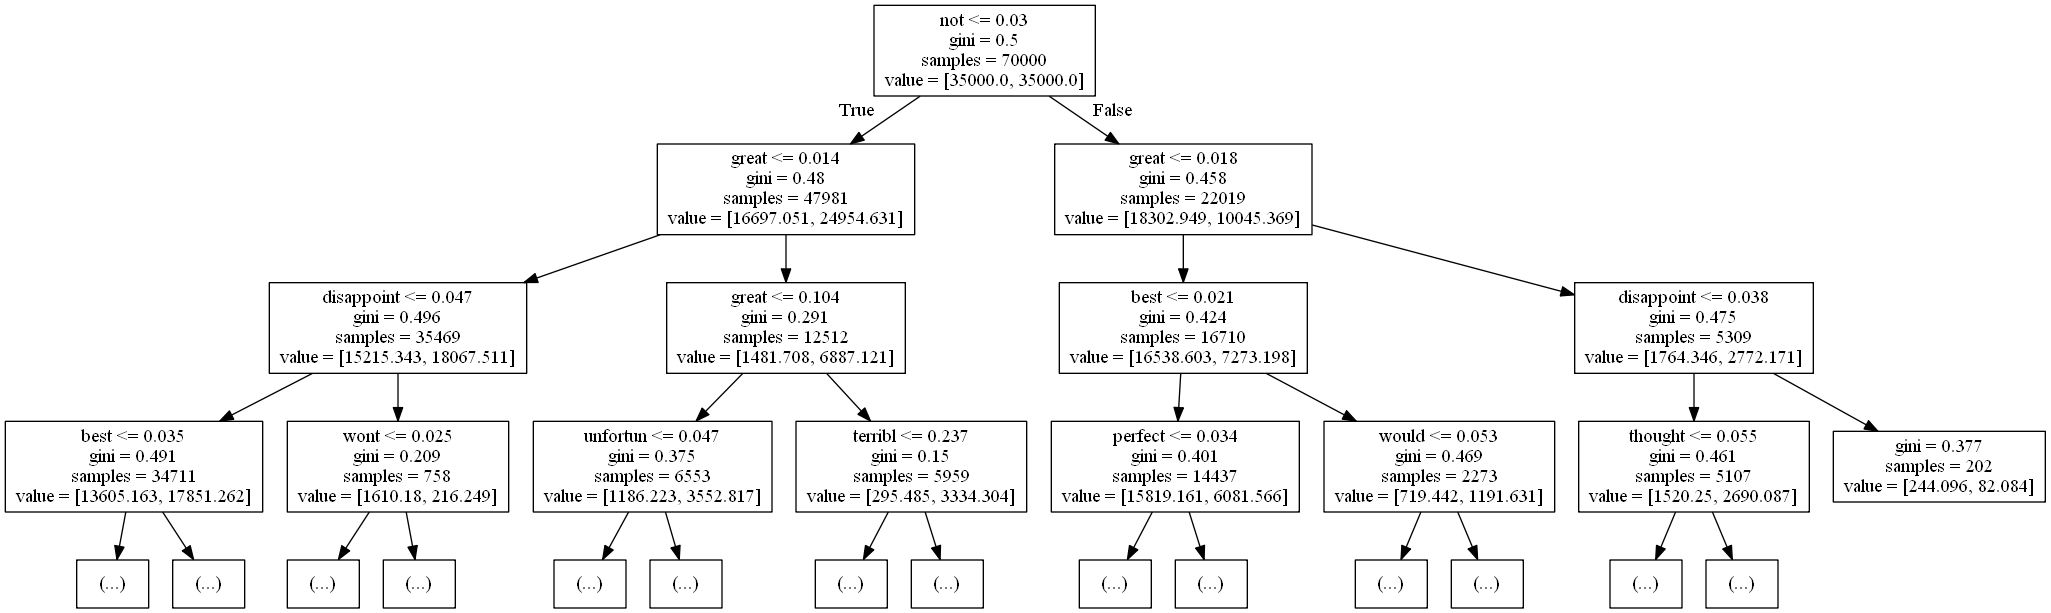

In [40]:
#displaying the Decision tree
from IPython.display import Image
Image("DT_classifier_tfidf.png")

## [6.3] Applying Decision Trees on AVG W2V

In [41]:
#loading avg w2v train std saved previously
with open("X_avgw2v_train_noval_100k_300dim.pkl","rb") as f:
    X_avgw2v_train = pickle.load(f)

In [43]:
#loading avg w2v test std saved previously
with open("X_avgw2v_test_100k_300dim.pkl","rb") as f:
    X_avgw2v_test = pickle.load(f)

In [44]:
#Define parameters and SGDClassifier estimator to be used in GridSearchCV
parameters = {'min_samples_split':[5, 10, 100, 500],'max_depth':[1, 5, 10, 50, 100, 500, 1000]}
clf = DecisionTreeClassifier(class_weight = 'balanced')

In [45]:
#check best params using gridsearch on the basis of auc score
auc_results,best_auc,best_estimator_auc = PerformGridSearchCV(clf, parameters, 3, "roc_auc", X_avgw2v_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed: 14.2min finished


GridSearchCV took 894.18 seconds for 28 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.811 (std: 0.002)
Parameters: {'max_depth': 10, 'min_samples_split': 500}

Model with rank: 2
Mean validation score: 0.806 (std: 0.001)
Parameters: {'max_depth': 5, 'min_samples_split': 500}

Model with rank: 3
Mean validation score: 0.806 (std: 0.001)
Parameters: {'max_depth': 5, 'min_samples_split': 5}

Model with rank: 3
Mean validation score: 0.806 (std: 0.001)
Parameters: {'max_depth': 5, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 0.806 (std: 0.001)
Parameters: {'max_depth': 5, 'min_samples_split': 100}



<b>Observation:</b> Since min_samples_split = 500 is included in 2 out of 5 top results, I will go with that. For max depth, I have taken 10 as it gives better AUC score on actual test set as shown below

In [46]:
#get train and CV data from gridsearch results object
df_auc_results = pd.DataFrame(auc_results)
df_auc_results_mss500 = df_auc_results.loc[df_auc_results["param_min_samples_split"] == 500]
grd_srch_test = df_auc_results_mss500["mean_test_score"].values
grd_srch_train = df_auc_results_mss500["mean_train_score"].values
maxDepthValues = df_auc_results_mss500["param_max_depth"].values

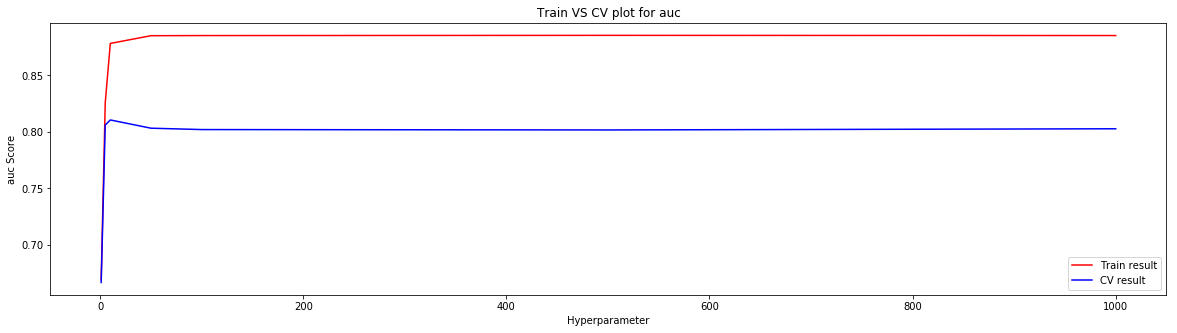

In [47]:
#Plot train vs CV data on for max_depth while fixing min_samples_split to 500
PlotTrainVsCVerror(maxDepthValues,grd_srch_train, grd_srch_test, "auc")

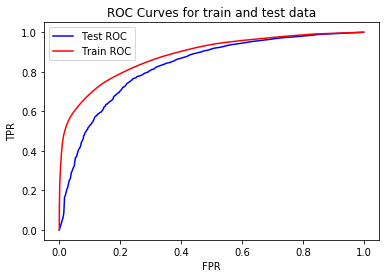

In [48]:
#Now get the model performance metrices on test set with tuned hyperparameter
optimal_min_samples_split = 500
optimal_max_depth = 10
dtc = DecisionTreeClassifier(class_weight = 'balanced', max_depth = optimal_max_depth, min_samples_split = optimal_min_samples_split)
auc,conf_matrix,feature_importances = CheckTestSetScores(dtc, X_avgw2v_train, y_train,X_avgw2v_test, y_test)

auc score for test set is 82.77694615551987
Confusion matrix for test set is:
[[ 3220   900]
 [ 6926 18954]]


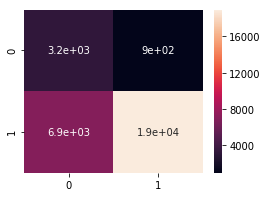

True Negative with optimal hyperparameters is 3220
False Positive with optimal hyperparameters is 900
True Positive with optimal hyperparameters is 18954
False Negative with optimal hyperparameters is 6926


In [49]:
#print the model performace metrices
print("auc score for test set is " + str(auc))
#print confusion matrix for test set
print("Confusion matrix for test set is:")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 3))
sns.heatmap(conf_matrix, annot=True)
plt.show()
tn, fp, fn, tp = conf_matrix.ravel()
print('True Negative with optimal hyperparameters is %d' % (tn))
print('False Positive with optimal hyperparameters is %d' % (fp))
print('True Positive with optimal hyperparameters is %d' % (tp))
print('False Negative with optimal hyperparameters is %d' % (fn))

## [6.4] Applying Decision Trees on TFIDF W2V

In [50]:
#loading avg w2v train std saved previously
with open("X_tfidfw2v_train_noval_100k_300dim.pkl","rb") as f:
    X_tfidfw2v_train = pickle.load(f)

In [51]:
#loading avg w2v test std saved previously
with open("X_tfidfw2v_test_100k_300dim.pkl","rb") as f:
    X_tfidfw2v_test = pickle.load(f)

In [52]:
#Define parameters and SGDClassifier estimator to be used in GridSearchCV
parameters = {'min_samples_split':[5, 10, 100, 500],'max_depth':[1, 5, 10, 50, 100, 500, 1000]}
clf = DecisionTreeClassifier(class_weight = 'balanced')

In [53]:
#check best params using gridsearch on the basis of auc score
auc_results,best_auc,best_estimator_auc = PerformGridSearchCV(clf, parameters, 3, "roc_auc", X_tfidfw2v_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed: 15.1min finished


GridSearchCV took 945.92 seconds for 28 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.780 (std: 0.001)
Parameters: {'max_depth': 10, 'min_samples_split': 500}

Model with rank: 2
Mean validation score: 0.774 (std: 0.002)
Parameters: {'max_depth': 50, 'min_samples_split': 500}

Model with rank: 3
Mean validation score: 0.774 (std: 0.002)
Parameters: {'max_depth': 100, 'min_samples_split': 500}

Model with rank: 4
Mean validation score: 0.774 (std: 0.002)
Parameters: {'max_depth': 500, 'min_samples_split': 500}

Model with rank: 5
Mean validation score: 0.774 (std: 0.002)
Parameters: {'max_depth': 1000, 'min_samples_split': 500}



In [54]:
#get train and CV data from gridsearch results object
df_auc_results = pd.DataFrame(auc_results)
df_auc_results_mss500 = df_auc_results.loc[df_auc_results["param_min_samples_split"] == 500]
grd_srch_test = df_auc_results_mss500["mean_test_score"].values
grd_srch_train = df_auc_results_mss500["mean_train_score"].values
maxDepthValues = df_auc_results_mss500["param_max_depth"].values

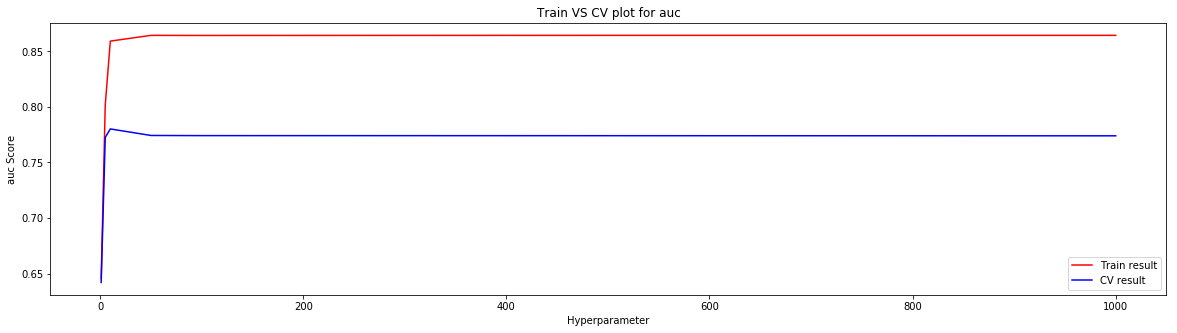

In [55]:
#Plot train vs CV data on for max_depth while fixing min_samples_split to 500
PlotTrainVsCVerror(maxDepthValues,grd_srch_train, grd_srch_test, "auc")

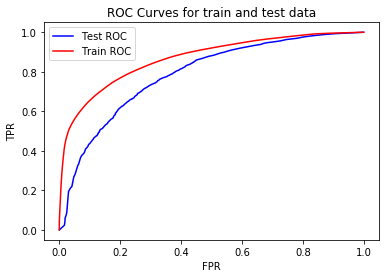

In [60]:
#Now get the model performance metrices on test set with tuned hyperparameter
optimal_min_samples_split = 500
optimal_max_depth = 10
dtc = DecisionTreeClassifier(class_weight = 'balanced', max_depth = optimal_max_depth, min_samples_split = optimal_min_samples_split)
auc,conf_matrix,feature_importances = CheckTestSetScores(dtc, X_tfidfw2v_train, y_train,X_tfidfw2v_test, y_test)

auc score for test set is 78.59124075268977
Confusion matrix for test set is:
[[ 2935  1185]
 [ 7209 18671]]


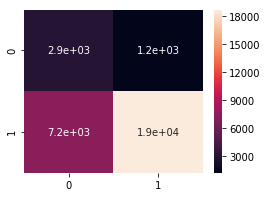

True Negative with optimal hyperparameters is 2935
False Positive with optimal hyperparameters is 1185
True Positive with optimal hyperparameters is 18671
False Negative with optimal hyperparameters is 7209


In [61]:
#print the model performace metrices
print("auc score for test set is " + str(auc))
#print confusion matrix for test set
print("Confusion matrix for test set is:")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 3))
sns.heatmap(conf_matrix, annot=True)
plt.show()
tn, fp, fn, tp = conf_matrix.ravel()
print('True Negative with optimal hyperparameters is %d' % (tn))
print('False Positive with optimal hyperparameters is %d' % (fp))
print('True Positive with optimal hyperparameters is %d' % (tp))
print('False Negative with optimal hyperparameters is %d' % (fn))

# [6.5] Conclusions

In [62]:
#Printing results for Decision Tree Classifier
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "max_depth","min_samples_split","AUC Score", "True Neg", "False Pos", "True Pos", "False Neg"]
x.add_row(["BOW", 50,500, 80.00, 3045,1075,19046, 6834])
x.add_row(["TFIDF", 10,500,78.00, 3244, 876, 17196, 8684])
x.add_row(["Avg Word2Vec",10,500, 82.77, 3220, 900, 18954, 6926])
x.add_row(["TFIDF Word2Vec", 10,500, 78.59, 2935, 1185, 18671, 7209])
print("Results for Decision Tree Classifier:")
print(x)

Results for Decision Tree Classifier:
+----------------+-----------+-------------------+-----------+----------+-----------+----------+-----------+
|   Vectorizer   | max_depth | min_samples_split | AUC Score | True Neg | False Pos | True Pos | False Neg |
+----------------+-----------+-------------------+-----------+----------+-----------+----------+-----------+
|      BOW       |     50    |        500        |    80.0   |   3045   |    1075   |  19046   |    6834   |
|     TFIDF      |     10    |        500        |    78.0   |   3244   |    876    |  17196   |    8684   |
|  Avg Word2Vec  |     10    |        500        |   82.77   |   3220   |    900    |  18954   |    6926   |
| TFIDF Word2Vec |     10    |        500        |   78.59   |   2935   |    1185   |  18671   |    7209   |
+----------------+-----------+-------------------+-----------+----------+-----------+----------+-----------+


# Section 7: Random Forests

## [7.1] Applying RF

In [5]:
#get the data from pre-processed or cleaned data that we saved in the previous assignment
import os
import sqlite3
con = sqlite3.connect('cleaned.sqlite')
data = pd.read_sql_query("Select Cleaned_Text,Score from Reviews where Score != 3 order by Time limit 100000", con)
con.close()

In [6]:
#Get input matrix of features X and output vector y
X = data.iloc[:,0]
y = data.iloc[:, 1]

In [7]:
#since I will use gridSearchCV so I will only split the data into train and test set (and skip a separate validation set)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3,shuffle = False, random_state = 0)
print(X_train.shape)
print(X_test.shape)

(70000,)
(30000,)


### [7.1.1] Applying Random Forests on BOW

In [19]:
#get BOW vector for train data
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_BOW_train = cv.fit_transform(X_train)
print(X_BOW_train.shape)

(70000, 36445)


In [20]:
#Get BOW test set
X_BOW_test = cv.transform(X_test)
print(X_BOW_test.shape)

(30000, 36445)


In [16]:
#Define parameters and SGDClassifier estimator to be used in GridSearchCV
parameters = {'n_estimators':[5, 10, 20, 30, 50, 100, 200, 500],'max_depth':[5, 10, 50, 100, 500, 1000]}
clf = RandomForestClassifier(class_weight = 'balanced', n_jobs = -1)

In [17]:
#check best params using gridsearch on the basis of auc score
auc_results,best_auc,best_estimator_auc = PerformGridSearchCV(clf, parameters, 3, "roc_auc", X_BOW_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 48.8min finished


GridSearchCV took 3135.79 seconds for 48 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.933 (std: 0.001)
Parameters: {'max_depth': 1000, 'n_estimators': 500}

Model with rank: 2
Mean validation score: 0.933 (std: 0.001)
Parameters: {'max_depth': 500, 'n_estimators': 500}

Model with rank: 3
Mean validation score: 0.930 (std: 0.001)
Parameters: {'max_depth': 1000, 'n_estimators': 200}

Model with rank: 4
Mean validation score: 0.929 (std: 0.001)
Parameters: {'max_depth': 500, 'n_estimators': 200}

Model with rank: 5
Mean validation score: 0.923 (std: 0.001)
Parameters: {'max_depth': 500, 'n_estimators': 100}



In [4]:
#get train and CV data from gridsearch results object
df_auc_results = pd.DataFrame(auc_results)

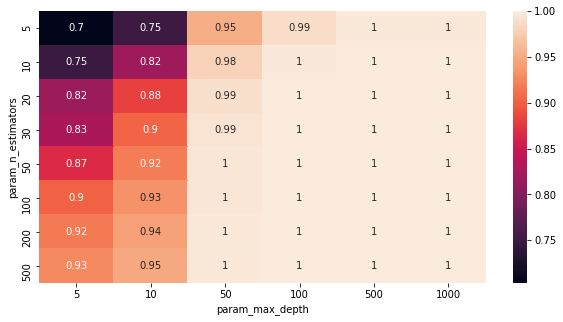

In [11]:
#Visualizing AUC score change with two hyperparameters using a heatmap for train data
import seaborn as sns
plt.figure(figsize = (10, 5))
pivot = df_auc_results.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_train_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

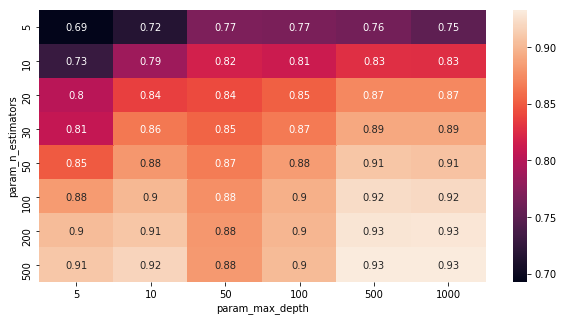

In [12]:
#Visualizing AUC score change with two hyperparameters using a heatmap for test data
plt.figure(figsize = (10, 5))
pivot = df_auc_results.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_test_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

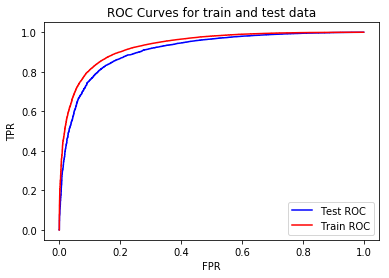

In [37]:
#Now get the model performance metrices on test set with tuned hyperparameter
#Note: After trying different hyperparameter combinations observed from heat map,
        #I got a good performance using the following hyperparameter combination
optimal_n_estimators = 100 
optimal_max_depth = 10
rfc = RandomForestClassifier(class_weight = 'balanced', max_depth = optimal_max_depth, n_estimators = optimal_n_estimators, n_jobs = -1)
auc,conf_matrix,feature_importances = CheckTestSetScores(rfc, X_BOW_train, y_train,X_BOW_test, y_test)

auc score for test set is 91.03938031767231
Confusion matrix for test set is:
[[ 3257   863]
 [ 3276 22604]]


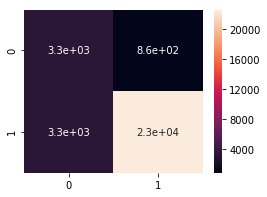

True Negative with optimal hyperparameters is 3257
False Positive with optimal hyperparameters is 863
True Positive with optimal hyperparameters is 22604
False Negative with optimal hyperparameters is 3276


In [38]:
print("auc score for test set is " + str(auc))
#print confusion matrix for test set
print("Confusion matrix for test set is:")
print(conf_matrix)
#plotting confusion matrix on heatmap
plt.figure(figsize = (4, 3))
sns.heatmap(conf_matrix, annot=True)
plt.show()
tn, fp, fn, tp = conf_matrix.ravel()
print('True Negative with optimal hyperparameters is %d' % (tn))
print('False Positive with optimal hyperparameters is %d' % (fp))
print('True Positive with optimal hyperparameters is %d' % (tp))
print('False Negative with optimal hyperparameters is %d' % (fn))

### [7.1.2] Wordcloud of top 20 important features from

Most important words are


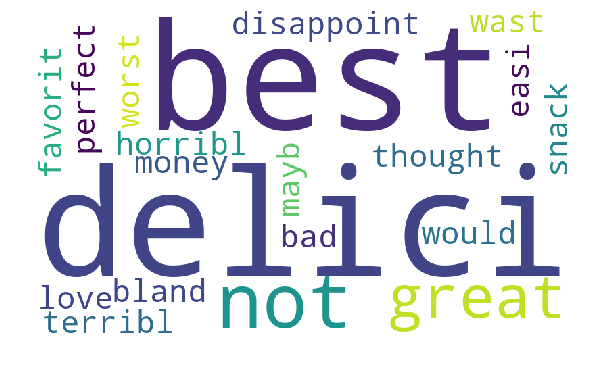

In [39]:
#sort the weights in descending and take the top 10 indices which will correspond to positive review
pos_class_prob_sorted = np.argsort(feature_importances)[::-1]
print("Most important words are")
#get top 20 features for positive reviews
important_words = np.take(cv.get_feature_names(), pos_class_prob_sorted)[:20]
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
for words in important_words: 
    comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 800, height = 500, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### [7.1.3] Applying Random Forests on TFIDF

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
X_tfidf_train = tfidf_vect.fit_transform(X_train)
print(X_tfidf_train.shape)

(70000, 36445)


In [9]:
#Get tfidf test set
X_tfidf_test = tfidf_vect.transform(X_test)
print(X_tfidf_test.shape)

(30000, 36445)


In [27]:
#Define parameters and SGDClassifier estimator to be used in GridSearchCV
parameters = {'n_estimators':[5, 10, 20, 30, 50, 100, 200, 500],'max_depth':[5, 10, 50, 100, 500, 1000]}
clf = RandomForestClassifier(class_weight = 'balanced', n_jobs = -1)

In [28]:
#check best params using gridsearch on the basis of auc score
auc_results,best_auc,best_estimator_auc = PerformGridSearchCV(clf, parameters, 3, "roc_auc", X_tfidf_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 45.4min finished


GridSearchCV took 2906.81 seconds for 48 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.933 (std: 0.001)
Parameters: {'max_depth': 500, 'n_estimators': 500}

Model with rank: 2
Mean validation score: 0.933 (std: 0.001)
Parameters: {'max_depth': 1000, 'n_estimators': 500}

Model with rank: 3
Mean validation score: 0.929 (std: 0.001)
Parameters: {'max_depth': 1000, 'n_estimators': 200}

Model with rank: 4
Mean validation score: 0.929 (std: 0.001)
Parameters: {'max_depth': 500, 'n_estimators': 200}

Model with rank: 5
Mean validation score: 0.924 (std: 0.001)
Parameters: {'max_depth': 1000, 'n_estimators': 100}



In [29]:
#get train and CV data from gridsearch results object
df_auc_results = pd.DataFrame(auc_results)

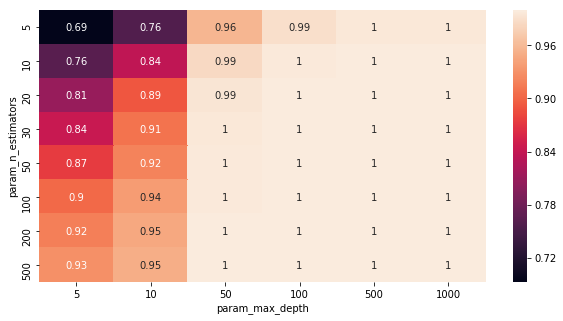

In [44]:
#Visualizing AUC score change with two hyperparameters using a heatmap for train data
import seaborn as sns
plt.figure(figsize = (10, 5))
pivot = df_auc_results.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_train_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

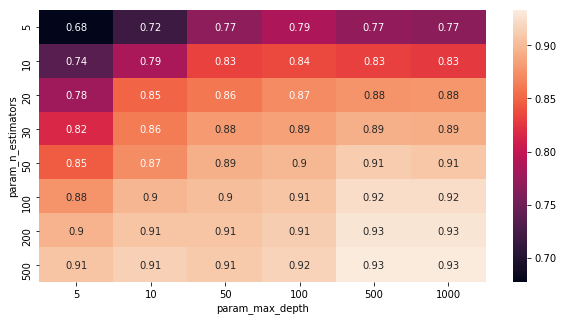

In [45]:
#Visualizing AUC score change with two hyperparameters using a heatmap for test data
plt.figure(figsize = (10, 5))
pivot = df_auc_results.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_test_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

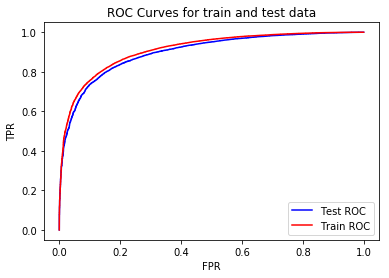

In [10]:
#Now get the model performance metrices on test set with tuned hyperparameter
#Note: After trying different hyperparameter combinations observed from heat map,
        #I got the relatively best performance using the following hyperparameter combination
optimal_n_estimators = 200
optimal_max_depth = 5
rfc = RandomForestClassifier(class_weight = 'balanced', max_depth = optimal_max_depth, n_estimators = optimal_n_estimators, n_jobs = -1)
auc,conf_matrix,feature_importances = CheckTestSetScores(rfc, X_tfidf_train, y_train,X_tfidf_test, y_test)

auc score for test set is 89.89703410813162
Confusion matrix for test set is:
[[ 3208   912]
 [ 3840 22040]]


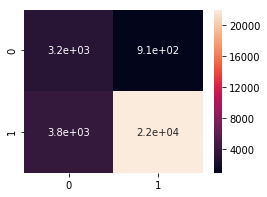

True Negative with optimal hyperparameters is 3208
False Positive with optimal hyperparameters is 912
True Positive with optimal hyperparameters is 22040
False Negative with optimal hyperparameters is 3840


In [11]:
print("auc score for test set is " + str(auc))
#print confusion matrix for test set
print("Confusion matrix for test set is:")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 3))
sns.heatmap(conf_matrix, annot=True)
plt.show()
tn, fp, fn, tp = conf_matrix.ravel()
print('True Negative with optimal hyperparameters is %d' % (tn))
print('False Positive with optimal hyperparameters is %d' % (fp))
print('True Positive with optimal hyperparameters is %d' % (tp))
print('False Negative with optimal hyperparameters is %d' % (fn))

### [7.1.4] Wordcloud of top 20 important features from

Most important words are


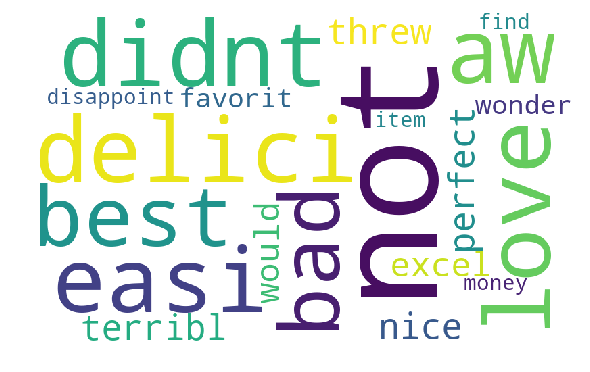

In [79]:
#use feature importances to get top 20 most important features/words
pos_class_prob_sorted = np.argsort(feature_importances)[::-1]
print("Most important words are")
#get top 20 features for positive reviews
important_words = np.take(tfidf_vect.get_feature_names(), pos_class_prob_sorted)[:20]
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
for words in important_words: 
    comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 800, height = 500, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### [7.1.5] Applying Random Forests on AVG W2V

In [9]:
#loading avg w2v train std saved previously
with open("X_avgw2v_train_noval_100k_300dim.pkl","rb") as f:
    X_avgw2v_train = pickle.load(f)

In [10]:
#converting X_avgw2v_train to 2-D numpy array to avoid memory leakage issues
X_avgw2v_train_arr = np.array(X_avgw2v_train).reshape(len(X_avgw2v_train),len(X_avgw2v_train[0]))

In [11]:
#loading avg w2v test std saved previously
with open("X_avgw2v_test_100k_300dim.pkl","rb") as f:
    X_avgw2v_test = pickle.load(f)

In [12]:
#converting X_avgw2v_test to 2-D numpy array to avoid memory leakage issues
X_avgw2v_test_arr = np.array(X_avgw2v_test).reshape(len(X_avgw2v_test),len(X_avgw2v_test[0]))

In [63]:
#Define parameters and RandomForest estimator to be used in GridSearchCV
parameters = {'n_estimators':[5, 10, 20, 30, 50, 100, 200, 500],'max_depth':[5, 10, 50, 100, 500, 1000]}
clf = RandomForestClassifier(class_weight = 'balanced', n_jobs = -1)

In [64]:
#check best params using gridsearch on the basis of auc score
auc_results,best_auc,best_estimator_auc = PerformGridSearchCV(clf, parameters, 3, "roc_auc", X_avgw2v_train_arr, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 46.1min finished


GridSearchCV took 2917.64 seconds for 48 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.900 (std: 0.004)
Parameters: {'max_depth': 50, 'n_estimators': 500}

Model with rank: 2
Mean validation score: 0.900 (std: 0.004)
Parameters: {'max_depth': 1000, 'n_estimators': 500}

Model with rank: 3
Mean validation score: 0.900 (std: 0.003)
Parameters: {'max_depth': 100, 'n_estimators': 500}

Model with rank: 4
Mean validation score: 0.900 (std: 0.004)
Parameters: {'max_depth': 500, 'n_estimators': 500}

Model with rank: 5
Mean validation score: 0.897 (std: 0.004)
Parameters: {'max_depth': 1000, 'n_estimators': 200}



In [65]:
#get train and CV data from gridsearch results object
df_auc_results = pd.DataFrame(auc_results)

In [13]:
import pickle
with open("grid_results_avgw2v_arr_RF.pkl","rb") as f:
    df_auc_results = pickle.load(f)

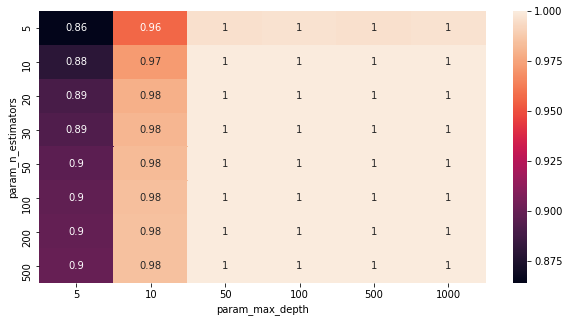

In [14]:
#Visualizing AUC score change with two hyperparameters using a heatmap for train data
import seaborn as sns
plt.figure(figsize = (10, 5))
pivot = df_auc_results.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_train_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

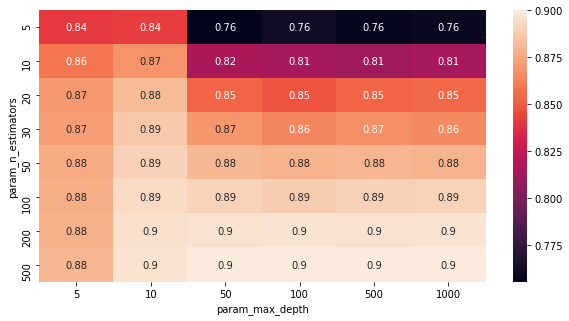

In [15]:
#Visualizing AUC score change with two hyperparameters using a heatmap for test data
import seaborn as sns
plt.figure(figsize = (10, 5))
pivot = df_auc_results.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_test_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

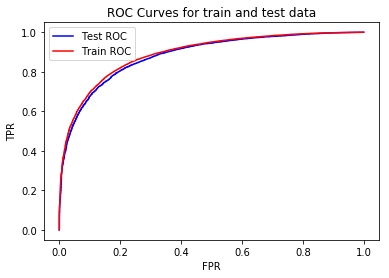

In [32]:
#Now get the model performance metrices on test set with tuned hyperparameter
#Note: After trying different hyperparameter combinations observed from heat map,
        #I got a good performance using the following hyperparameter combination
optimal_n_estimators = 100
optimal_max_depth = 5
rfc = RandomForestClassifier(class_weight = 'balanced', max_depth = optimal_max_depth, n_estimators = optimal_n_estimators, n_jobs = -1)
auc,conf_matrix,feature_importances = CheckTestSetScores(rfc, X_avgw2v_train_arr, y_train,X_avgw2v_test_arr, y_test)

auc score for test set is 88.30828900376646
Confusion matrix for test set is:
[[ 3397   723]
 [ 5666 20214]]


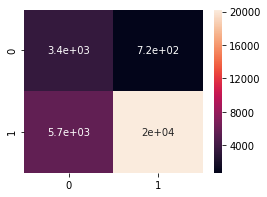

True Negative with optimal hyperparameters is 3397
False Positive with optimal hyperparameters is 723
True Positive with optimal hyperparameters is 20214
False Negative with optimal hyperparameters is 5666


In [33]:
#Printing various performance matrices for test set
print("auc score for test set is " + str(auc))
#print confusion matrix for test set
print("Confusion matrix for test set is:")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 3))
sns.heatmap(conf_matrix, annot=True)
plt.show()
tn, fp, fn, tp = conf_matrix.ravel()
print('True Negative with optimal hyperparameters is %d' % (tn))
print('False Positive with optimal hyperparameters is %d' % (fp))
print('True Positive with optimal hyperparameters is %d' % (tp))
print('False Negative with optimal hyperparameters is %d' % (fn))

### [7.1.6] Applying Random Forests on TFIDF W2V

In [34]:
#loading avg w2v train std saved previously
with open("X_tfidfw2v_train_noval_100k_300dim.pkl","rb") as f:
    X_tfidfw2v_train = pickle.load(f)

In [35]:
#converting X_avgw2v_train to 2-D numpy array to avoid memory leakage issues
X_tfidfw2v_train_arr = np.array(X_tfidfw2v_train).reshape(len(X_tfidfw2v_train),len(X_tfidfw2v_train[0]))

In [36]:
#loading avg w2v test std saved previously
with open("X_tfidfw2v_test_100k_300dim.pkl","rb") as f:
    X_tfidfw2v_test = pickle.load(f)

In [37]:
#converting X_tfidfw2v_test to 2-D numpy array to avoid memory leakage issues
X_tfidfw2v_test_arr = np.array(X_tfidfw2v_test).reshape(len(X_tfidfw2v_test),len(X_tfidfw2v_test[0]))

In [67]:
#Define parameters and RandomForest estimator to be used in GridSearchCV
parameters = {'n_estimators':[5, 10, 20, 30, 50, 100, 200, 500],'max_depth':[5, 10, 50, 100, 500, 1000]}
clf = RandomForestClassifier(class_weight = 'balanced', n_jobs = -1)

In [68]:
#check best params using gridsearch on the basis of auc score
auc_results,best_auc,best_estimator_auc = PerformGridSearchCV(clf, parameters, 3, "roc_auc", X_tfidfw2v_train_arr, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 46.9min finished


GridSearchCV took 2973.23 seconds for 48 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.873 (std: 0.003)
Parameters: {'max_depth': 100, 'n_estimators': 500}

Model with rank: 2
Mean validation score: 0.873 (std: 0.002)
Parameters: {'max_depth': 500, 'n_estimators': 500}

Model with rank: 3
Mean validation score: 0.873 (std: 0.002)
Parameters: {'max_depth': 50, 'n_estimators': 500}

Model with rank: 4
Mean validation score: 0.872 (std: 0.003)
Parameters: {'max_depth': 1000, 'n_estimators': 500}

Model with rank: 5
Mean validation score: 0.869 (std: 0.003)
Parameters: {'max_depth': 10, 'n_estimators': 500}



In [69]:
#get train and CV data from gridsearch results object
df_auc_results = pd.DataFrame(auc_results)

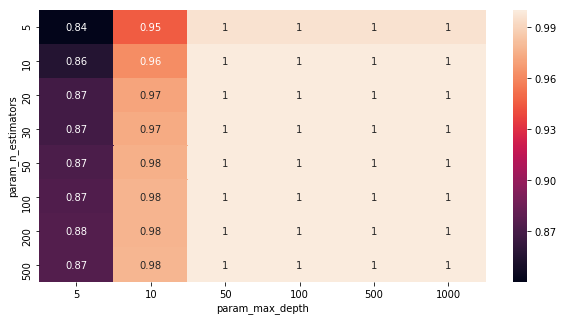

In [39]:
#Visualizing AUC score change with two hyperparameters using a heatmap for train data
import seaborn as sns
plt.figure(figsize = (10, 5))
pivot = df_auc_results.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_train_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

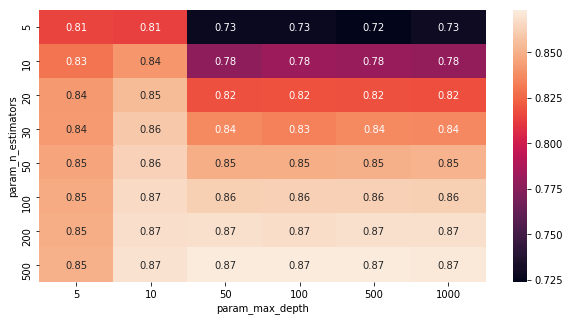

In [40]:
#Visualizing AUC score change with two hyperparameters using a heatmap for test data
import seaborn as sns
plt.figure(figsize = (10, 5))
pivot = df_auc_results.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_test_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

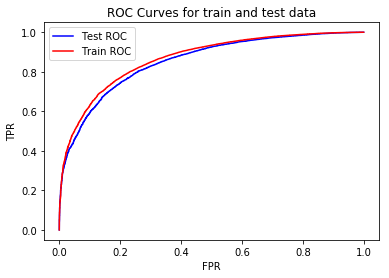

In [51]:
#Now get the model performance metrices on test set with tuned hyperparameter
#Note: After trying different hyperparameter combinations observed from heat map,
        #I got a good performance using the following hyperparameter combination
optimal_n_estimators = 200
optimal_max_depth = 5
rfc = RandomForestClassifier(class_weight = 'balanced', max_depth = optimal_max_depth, n_estimators = optimal_n_estimators, n_jobs = -1)
auc,conf_matrix,feature_importances = CheckTestSetScores(rfc, X_tfidfw2v_train_arr, y_train,X_tfidfw2v_test_arr, y_test)

auc score for test set is 85.3759852230609
Confusion matrix for test set is:
[[ 3159   961]
 [ 5828 20052]]


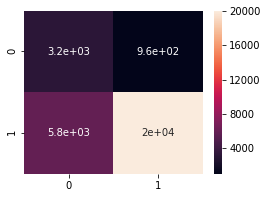

True Negative with optimal hyperparameters is 3159
False Positive with optimal hyperparameters is 961
True Positive with optimal hyperparameters is 20052
False Negative with optimal hyperparameters is 5828


In [52]:
print("auc score for test set is " + str(auc))
#print confusion matrix for test set
print("Confusion matrix for test set is:")
print(conf_matrix)
#plotting confusion matrix on heatmap
import seaborn as sns
plt.figure(figsize = (4, 3))
sns.heatmap(conf_matrix, annot=True)
plt.show()
tn, fp, fn, tp = conf_matrix.ravel()
print('True Negative with optimal hyperparameters is %d' % (tn))
print('False Positive with optimal hyperparameters is %d' % (fp))
print('True Positive with optimal hyperparameters is %d' % (tp))
print('False Negative with optimal hyperparameters is %d' % (fn))

## [7.2] Applying GBDT using XGBOOST

In [57]:
import xgboost as xgb
#we will use sklearn.utils.class_weight to estimate sample weights
from sklearn.utils.class_weight import compute_sample_weight
def CheckXGBTestSetScores(clf, x_train, y_train, x_test, y_test):
    """Returns the auc, confusion matrix for XGBoost estimator on test/val set"""
    sample_weight = compute_sample_weight(class_weight='balanced', y=y_train) #using sample weights in XGB Classifier
    clf.fit(X=x_train,y= y_train, sample_weight=sample_weight)
    #clf.fit(X=x_train, y= y_train,sample_weight=sample_weight, eval_metric='auc',verbose= False
            #eval_set=[(x_test, y_test)], early_stopping_rounds=100)
    ytest_pred = clf.predict(x_test)
    ytest_proba = clf.predict_proba(x_test)
    ytrain_pred = clf.predict(x_train)
    ytrain_proba= clf.predict_proba(x_train)
    auc = sklearn.metrics.roc_auc_score(y_test, ytest_proba[:,1]) * float(100)
    conf_matrix = sklearn.metrics.confusion_matrix(y_test, ytest_pred)
    feature_importances = clf.feature_importances_
    #Plot ROC Curve
    fpr,tpr,thresholds = sklearn.metrics.roc_curve(y_test, ytest_proba[:,1])
    fpr_train,tpr_train,thresholds_train = sklearn.metrics.roc_curve(y_train, ytrain_proba[:,1])
    plt.plot(fpr, tpr, 'b-', label= 'Test ROC')
    plt.plot(fpr_train, tpr_train, 'r-', label= 'Train ROC')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title("ROC Curves for train and test data")
    plt.legend(loc='best')
    plt.show()
    #print(conf_matrix)
    return auc,conf_matrix,feature_importances

### [7.2.1] Applying XGBOOST on BOW

In [10]:
#get BOW vector for train data
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_BOW_train = cv.fit_transform(X_train)
print(X_BOW_train.shape)

(70000, 36445)


In [11]:
#Get BOW test set
X_BOW_test = cv.transform(X_test)
print(X_BOW_test.shape)

(30000, 36445)


In [15]:
#Define parameters and SGDClassifier estimator to be used in GridSearchCV
parameters = {'n_estimators':[5, 10, 20, 30, 50, 100, 200, 500],'max_depth':[5, 10, 50, 100, 500, 1000]}
clf = xgb.XGBClassifier(class_weight = 'balanced', n_jobs = -1, colsample_bytree=0.7, colsample_bylevel=0.7)

In [16]:
#check best params using gridsearch on the basis of auc score
auc_results,best_auc,best_estimator_auc = PerformGridSearchCV(clf, parameters, 3, "roc_auc", X_BOW_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 132.8min finished


GridSearchCV took 8438.53 seconds for 48 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.936 (std: 0.001)
Parameters: {'max_depth': 100, 'n_estimators': 500}

Model with rank: 2
Mean validation score: 0.936 (std: 0.001)
Parameters: {'max_depth': 500, 'n_estimators': 500}

Model with rank: 2
Mean validation score: 0.936 (std: 0.001)
Parameters: {'max_depth': 1000, 'n_estimators': 500}

Model with rank: 4
Mean validation score: 0.935 (std: 0.002)
Parameters: {'max_depth': 50, 'n_estimators': 500}

Model with rank: 5
Mean validation score: 0.933 (std: 0.001)
Parameters: {'max_depth': 100, 'n_estimators': 200}



In [17]:
#get train and CV data from gridsearch results object
df_auc_results = pd.DataFrame(auc_results)

In [18]:
import pickle
with open("grid_results_BOW_XGB.pkl","wb") as f:
    pickle.dump(df_auc_results,f)

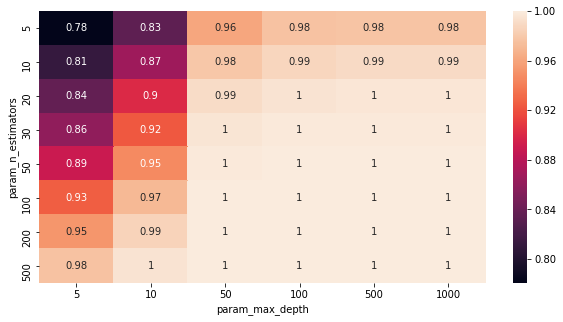

In [19]:
#Visualizing AUC score change with two hyperparameters using a heatmap for train data
import seaborn as sns
plt.figure(figsize = (10, 5))
pivot = df_auc_results.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_train_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

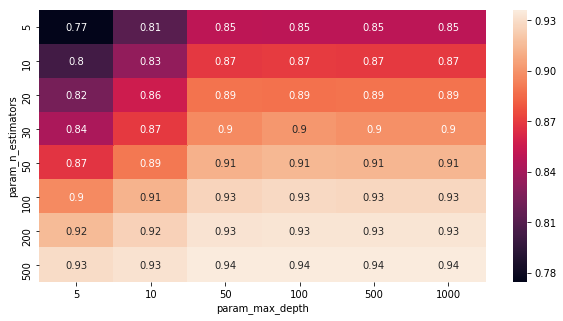

In [20]:
#Visualizing AUC score change with two hyperparameters using a heatmap for test data
plt.figure(figsize = (10, 5))
pivot = df_auc_results.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_test_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

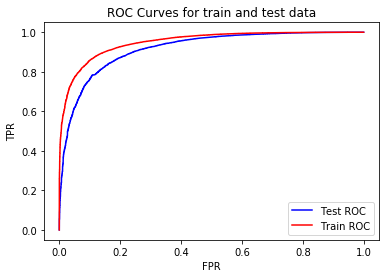

In [39]:
#Now get the model performance metrices on test set with tuned hyperparameter
#Note: After trying different hyperparameter combinations observed from heat map,
        #I got a good performance using the following hyperparameter combination
optimal_n_estimators = 200 
optimal_max_depth = 5
xgbc = xgb.XGBClassifier(max_depth = optimal_max_depth, n_estimators = optimal_n_estimators, n_jobs = -1,
                        colsample_bytree=0.7, colsample_bylevel=0.7)
auc,conf_matrix,feature_importances = CheckXGBTestSetScores(xgbc, X_BOW_train, y_train,X_BOW_test, y_test)

auc score for test set is 91.67656313305623
Confusion matrix for test set is:
[[ 3400   720]
 [ 3848 22032]]


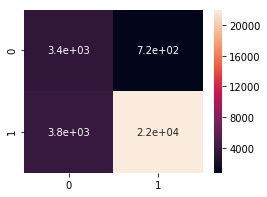

True Negative with optimal hyperparameters is 3400
False Positive with optimal hyperparameters is 720
True Positive with optimal hyperparameters is 22032
False Negative with optimal hyperparameters is 3848


In [40]:
print("auc score for test set is " + str(auc))
#print confusion matrix for test set
print("Confusion matrix for test set is:")
print(conf_matrix)
#plotting confusion matrix on heatmap
plt.figure(figsize = (4, 3))
sns.heatmap(conf_matrix, annot=True)
plt.show()
tn, fp, fn, tp = conf_matrix.ravel()
print('True Negative with optimal hyperparameters is %d' % (tn))
print('False Positive with optimal hyperparameters is %d' % (fp))
print('True Positive with optimal hyperparameters is %d' % (tp))
print('False Negative with optimal hyperparameters is %d' % (fn))

### [7.2.2] Applying XGBOOST on TFIDF

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
X_tfidf_train = tfidf_vect.fit_transform(X_train)
print(X_tfidf_train.shape)

(70000, 36445)


In [8]:
#Get tfidf test set
X_tfidf_test = tfidf_vect.transform(X_test)
print(X_tfidf_test.shape)

(30000, 36445)


In [15]:
#Define parameters and XGBClassifier estimator to be used in GridSearchCV
parameters = {'n_estimators':[5, 10, 20, 50, 100, 200],'max_depth':[5, 10, 50, 100, 200]}
clf = xgb.XGBClassifier(n_jobs = -1, colsample_bytree=0.7, colsample_bylevel=0.7)

In [16]:
#check best params using gridsearch on the basis of auc score
auc_results,best_auc,best_estimator_auc = PerformGridSearchCV(clf, parameters, 3, "roc_auc", X_tfidf_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 59.7min finished


GridSearchCV took 3758.80 seconds for 30 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.930 (std: 0.002)
Parameters: {'max_depth': 50, 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.930 (std: 0.002)
Parameters: {'max_depth': 100, 'n_estimators': 200}

Model with rank: 3
Mean validation score: 0.929 (std: 0.002)
Parameters: {'max_depth': 200, 'n_estimators': 200}

Model with rank: 4
Mean validation score: 0.926 (std: 0.002)
Parameters: {'max_depth': 10, 'n_estimators': 200}

Model with rank: 5
Mean validation score: 0.924 (std: 0.003)
Parameters: {'max_depth': 100, 'n_estimators': 100}



In [17]:
#get train and CV data from gridsearch results object
df_auc_results = pd.DataFrame(auc_results)

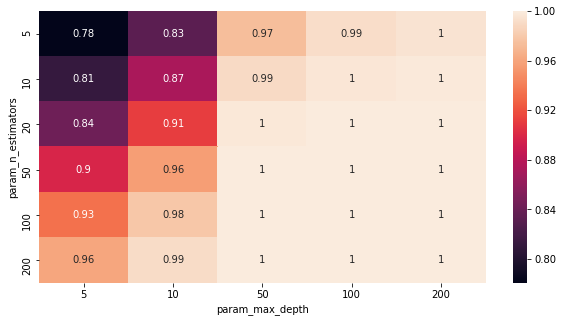

In [10]:
#Visualizing AUC score change with two hyperparameters using a heatmap for train data
import seaborn as sns
plt.figure(figsize = (10, 5))
pivot = df_auc_results.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_train_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

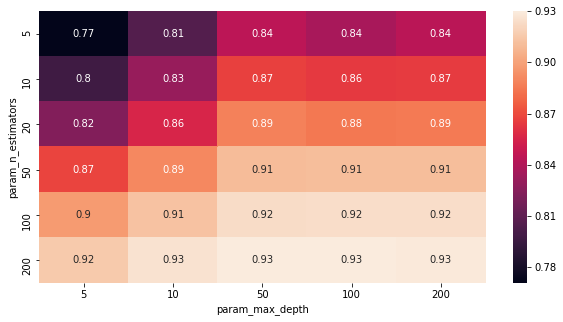

In [11]:
#Visualizing AUC score change with two hyperparameters using a heatmap for test data
plt.figure(figsize = (10, 5))
pivot = df_auc_results.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_test_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

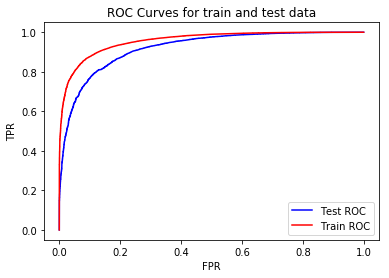

In [23]:
#Now get the model performance metrices on test set with tuned hyperparameter
#Note: After trying different hyperparameter combinations observed from heat map,
        #I got a good performance using the following hyperparameter combination
optimal_n_estimators = 200 
optimal_max_depth = 5
xgbc = xgb.XGBClassifier(max_depth = optimal_max_depth, n_estimators = optimal_n_estimators, n_jobs = -1,
                        colsample_bytree=0.7, colsample_bylevel=0.7)
auc,conf_matrix,feature_importances = CheckXGBTestSetScores(xgbc, X_tfidf_train, y_train,X_tfidf_test, y_test)

auc score for test set is 92.02617054440958
Confusion matrix for test set is:
[[ 3395   725]
 [ 3791 22089]]


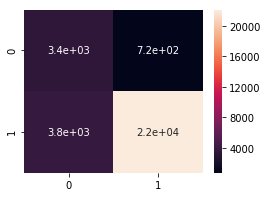

True Negative with optimal hyperparameters is 3395
False Positive with optimal hyperparameters is 725
True Positive with optimal hyperparameters is 22089
False Negative with optimal hyperparameters is 3791


In [24]:
print("auc score for test set is " + str(auc))
#print confusion matrix for test set
print("Confusion matrix for test set is:")
print(conf_matrix)
#plotting confusion matrix on heatmap
plt.figure(figsize = (4, 3))
sns.heatmap(conf_matrix, annot=True)
plt.show()
tn, fp, fn, tp = conf_matrix.ravel()
print('True Negative with optimal hyperparameters is %d' % (tn))
print('False Positive with optimal hyperparameters is %d' % (fp))
print('True Positive with optimal hyperparameters is %d' % (tp))
print('False Negative with optimal hyperparameters is %d' % (fn))

### [7.2.3] Applying XGBOOST on AVG W2V

In [32]:
#loading avg w2v train std saved previously
with open("X_avgw2v_train_noval_100k_300dim.pkl","rb") as f:
    X_avgw2v_train = pickle.load(f)

In [45]:
#converting X_avgw2v_train to 2-D numpy array, otherwise gridsearch is failing in case of XGBoost
X_avgw2v_train_arr = np.array(X_avgw2v_train).reshape(len(X_avgw2v_train),len(X_avgw2v_train[0]))

In [35]:
#loading avg w2v test std saved previously
with open("X_avgw2v_test_100k_300dim.pkl","rb") as f:
    X_avgw2v_test = pickle.load(f)

In [44]:
#converting X_avgw2v_test to 2-D numpy array, otherwise gridsearch is failing in case of XGBoost
X_avgw2v_test_arr = np.array(X_avgw2v_test).reshape(len(X_avgw2v_test),len(X_avgw2v_test[0]))

In [46]:
#Define parameters and XGBClassifier estimator to be used in GridSearchCV
parameters = {'n_estimators':[5, 10, 20, 50, 100, 200],'max_depth':[5, 10, 50, 100, 200]}
clf = xgb.XGBClassifier(n_jobs = -1, colsample_bytree=0.7, colsample_bylevel=0.7)

In [47]:
#check best params using gridsearch on the basis of auc score
auc_results,best_auc,best_estimator_auc = PerformGridSearchCV(clf, parameters, 3, "roc_auc", X_avgw2v_train_arr, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 64.6min finished


GridSearchCV took 4045.08 seconds for 30 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.915 (std: 0.002)
Parameters: {'max_depth': 10, 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.914 (std: 0.002)
Parameters: {'max_depth': 50, 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.914 (std: 0.002)
Parameters: {'max_depth': 100, 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.914 (std: 0.002)
Parameters: {'max_depth': 200, 'n_estimators': 200}

Model with rank: 5
Mean validation score: 0.913 (std: 0.002)
Parameters: {'max_depth': 5, 'n_estimators': 200}



In [48]:
#get train and CV data from gridsearch results object
df_auc_results = pd.DataFrame(auc_results)

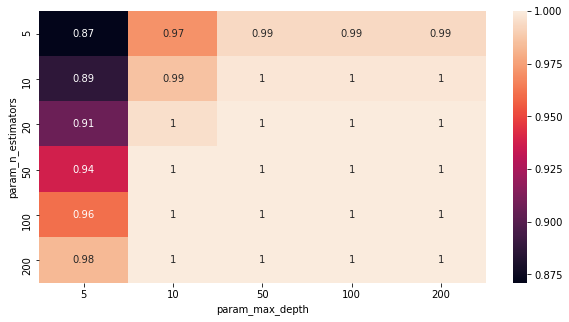

In [50]:
#Visualizing AUC score change with two hyperparameters using a heatmap for train data
import seaborn as sns
plt.figure(figsize = (10, 5))
pivot = df_auc_results.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_train_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

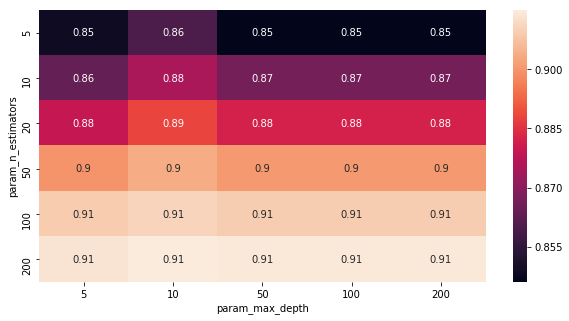

In [51]:
#Visualizing AUC score change with two hyperparameters using a heatmap for test data
plt.figure(figsize = (10, 5))
pivot = df_auc_results.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_test_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

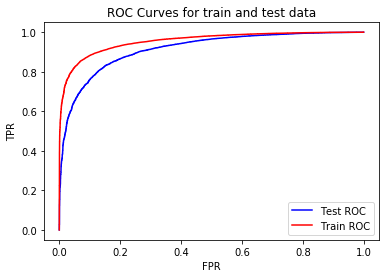

In [62]:
#Now get the model performance metrices on test set with tuned hyperparameter
#Note: After trying different hyperparameter combinations observed from heat map,
        #I got a good performance using the following hyperparameter combination
optimal_n_estimators = 100 
optimal_max_depth = 5
xgbc = xgb.XGBClassifier(max_depth = optimal_max_depth, n_estimators = optimal_n_estimators, n_jobs = -1,
                        colsample_bytree=0.7, colsample_bylevel=0.7)
auc,conf_matrix,feature_importances = CheckXGBTestSetScores(xgbc, X_avgw2v_train_arr, y_train,X_avgw2v_test_arr, y_test)

auc score for test set is 91.459906438979
Confusion matrix for test set is:
[[ 3424   696]
 [ 4016 21864]]


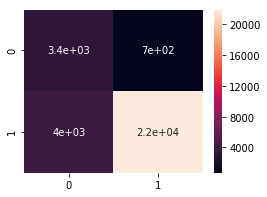

True Negative with optimal hyperparameters is 3424
False Positive with optimal hyperparameters is 696
True Positive with optimal hyperparameters is 21864
False Negative with optimal hyperparameters is 4016


In [63]:
print("auc score for test set is " + str(auc))
#print confusion matrix for test set
print("Confusion matrix for test set is:")
print(conf_matrix)
#plotting confusion matrix on heatmap
plt.figure(figsize = (4, 3))
sns.heatmap(conf_matrix, annot=True)
plt.show()
tn, fp, fn, tp = conf_matrix.ravel()
print('True Negative with optimal hyperparameters is %d' % (tn))
print('False Positive with optimal hyperparameters is %d' % (fp))
print('True Positive with optimal hyperparameters is %d' % (tp))
print('False Negative with optimal hyperparameters is %d' % (fn))

### [7.2.4] Applying XGBOOST on TFIDF W2V

In [52]:
#loading tfidf w2v train std saved previously
with open("X_tfidfw2v_train_noval_100k_300dim.pkl","rb") as f:
    X_tfidfw2v_train = pickle.load(f)

In [53]:
#converting X_tfidfw2v_train to 2-D numpy array, otherwise gridsearch is failing in case of XGBoost
X_tfidfw2v_train_arr = np.array(X_tfidfw2v_train).reshape(len(X_tfidfw2v_train),len(X_tfidfw2v_train[0]))

In [54]:
#loading tfidf w2v test std saved previously
with open("X_tfidfw2v_test_100k_300dim.pkl","rb") as f:
    X_tfidfw2v_test = pickle.load(f)

In [55]:
#converting X_tfidfw2v_test to 2-D numpy array, otherwise gridsearch is failing in case of XGBoost
X_tfidfw2v_test_arr = np.array(X_tfidfw2v_test).reshape(len(X_tfidfw2v_test),len(X_tfidfw2v_test[0]))

In [56]:
#Define parameters and XGBClassifier estimator to be used in GridSearchCV
parameters = {'n_estimators':[5, 10, 20, 50, 100, 200],'max_depth':[5, 10, 50, 100, 200]}
clf = xgb.XGBClassifier(n_jobs = -1, colsample_bytree=0.7, colsample_bylevel=0.7)

In [57]:
#check best params using gridsearch on the basis of auc score
auc_results,best_auc,best_estimator_auc = PerformGridSearchCV(clf, parameters, 3, "roc_auc", X_tfidfw2v_train_arr, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 66.5min finished


GridSearchCV took 4169.71 seconds for 30 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.896 (std: 0.003)
Parameters: {'max_depth': 10, 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.895 (std: 0.003)
Parameters: {'max_depth': 50, 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.895 (std: 0.003)
Parameters: {'max_depth': 100, 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.895 (std: 0.003)
Parameters: {'max_depth': 200, 'n_estimators': 200}

Model with rank: 5
Mean validation score: 0.894 (std: 0.003)
Parameters: {'max_depth': 5, 'n_estimators': 200}



In [58]:
#get train and CV data from gridsearch results object
df_auc_results = pd.DataFrame(auc_results)

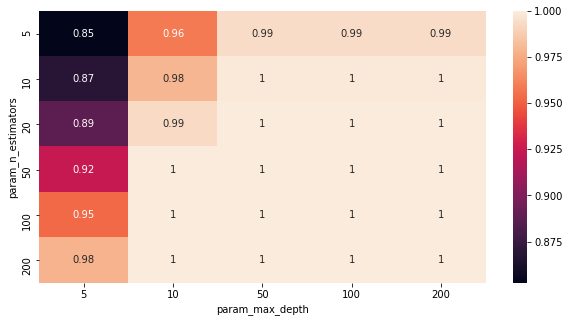

In [55]:
#Visualizing AUC score change with two hyperparameters using a heatmap for train data
import seaborn as sns
plt.figure(figsize = (10, 5))
pivot = df_auc_results.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_train_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

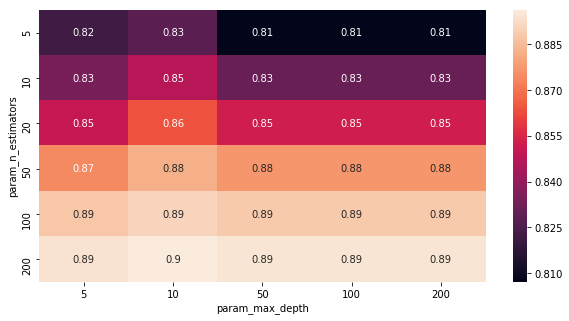

In [56]:
#Visualizing AUC score change with two hyperparameters using a heatmap for test data
plt.figure(figsize = (10, 5))
pivot = df_auc_results.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_test_score')
ax = sns.heatmap(pivot,annot=True)
plt.show()

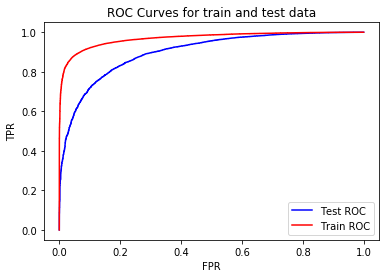

In [71]:
#Now get the model performance metrices on test set with tuned hyperparameter
#Note: After trying different hyperparameter combinations observed from heat map,
        #I got a good performance using the following hyperparameter combination
optimal_n_estimators = 200 
optimal_max_depth = 5
xgbc = xgb.XGBClassifier(max_depth = optimal_max_depth, n_estimators = optimal_n_estimators, n_jobs = -1,
                        colsample_bytree=0.7, colsample_bylevel=0.7)
auc,conf_matrix,feature_importances = CheckXGBTestSetScores(xgbc, X_tfidfw2v_train_arr, y_train,X_tfidfw2v_test_arr, y_test)

auc score for test set is 89.91760233940067
Confusion matrix for test set is:
[[ 3169   951]
 [ 3786 22094]]


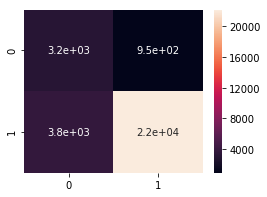

True Negative with optimal hyperparameters is 3169
False Positive with optimal hyperparameters is 951
True Positive with optimal hyperparameters is 22094
False Negative with optimal hyperparameters is 3786


In [72]:
print("auc score for test set is " + str(auc))
#print confusion matrix for test set
print("Confusion matrix for test set is:")
print(conf_matrix)
#plotting confusion matrix on heatmap
plt.figure(figsize = (4, 3))
sns.heatmap(conf_matrix, annot=True)
plt.show()
tn, fp, fn, tp = conf_matrix.ravel()
print('True Negative with optimal hyperparameters is %d' % (tn))
print('False Positive with optimal hyperparameters is %d' % (fp))
print('True Positive with optimal hyperparameters is %d' % (tp))
print('False Negative with optimal hyperparameters is %d' % (fn))

# [7.3] Conclusions

In [75]:
#Printing results for Decision Tree Classifier
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "max_depth","n_estimators","AUC Score", "True Neg", "False Pos", "True Pos", "False Neg"]
x.add_row(["BOW", 10,100, 91.03, 3257,863,22604, 3276])
x.add_row(["TFIDF", 5,200,89.89, 3208, 912, 22040, 3840])
x.add_row(["Avg Word2Vec",5,100, 88.30, 3397, 723, 20214, 5666])
x.add_row(["TFIDF Word2Vec", 5,200, 85.37, 3159, 961, 20052, 5828])
print("Results for Random Forest Classifier:")
print(x)

Results for Random Forest Classifier:
+----------------+-----------+--------------+-----------+----------+-----------+----------+-----------+
|   Vectorizer   | max_depth | n_estimators | AUC Score | True Neg | False Pos | True Pos | False Neg |
+----------------+-----------+--------------+-----------+----------+-----------+----------+-----------+
|      BOW       |     10    |     100      |   91.03   |   3257   |    863    |  22604   |    3276   |
|     TFIDF      |     5     |     200      |   89.89   |   3208   |    912    |  22040   |    3840   |
|  Avg Word2Vec  |     5     |     100      |    88.3   |   3397   |    723    |  20214   |    5666   |
| TFIDF Word2Vec |     5     |     200      |   85.37   |   3159   |    961    |  20052   |    5828   |
+----------------+-----------+--------------+-----------+----------+-----------+----------+-----------+


<b>Observation:</b> Overall RF on BOW seems to be performing the best

In [74]:
#Printing results for Decision Tree Classifier
x = PrettyTable()
x.field_names = ["Vectorizer", "max_depth","n_estimators","AUC Score", "True Neg", "False Pos", "True Pos", "False Neg"]
x.add_row(["BOW", 5,200, 91.03, 3400,720,22032, 3848])
x.add_row(["TFIDF", 5,200,92.02, 3395, 725, 22089, 3791])
x.add_row(["Avg Word2Vec",5,100, 91.45, 3424, 696, 21864, 4016])
x.add_row(["TFIDF Word2Vec", 5,200, 89.91, 3169, 951, 22094, 3786])
print("Results for XGBoost Classifier:")
print(x)

Results for XGBoost Classifier:
+----------------+-----------+--------------+-----------+----------+-----------+----------+-----------+
|   Vectorizer   | max_depth | n_estimators | AUC Score | True Neg | False Pos | True Pos | False Neg |
+----------------+-----------+--------------+-----------+----------+-----------+----------+-----------+
|      BOW       |     5     |     200      |   91.03   |   3400   |    720    |  22032   |    3848   |
|     TFIDF      |     5     |     200      |   92.02   |   3395   |    725    |  22089   |    3791   |
|  Avg Word2Vec  |     5     |     100      |   91.45   |   3424   |    696    |  21864   |    4016   |
| TFIDF Word2Vec |     5     |     200      |   89.91   |   3169   |    951    |  22094   |    3786   |
+----------------+-----------+--------------+-----------+----------+-----------+----------+-----------+


<b>Observation:</b> Here BOW, TFIDF and Avg Word2Vec all seem to be performing similar with XGBosst. Overall TFIDF seems to be having the best all round performance with highest AUC score

# <b><u> Section 8: LSTM on Amazon food reviews</u></b>



In [21]:
import os
import sqlite3
con = sqlite3.connect("cleaned.sqlite")
final = pd.read_sql_query("select Cleaned_Text,Score from Reviews order by Time where Score != 3", con)
con.close()
print(final.shape)

(363184, 3)


In [12]:
#get list of all words
import pdb
from tqdm import tqdm
all_words = []
for idx,review in enumerate(tqdm(cleaned_data["Text"].values)):
    words = review.split()
    for word in words:
        all_words.append(word)
print("done")

100%|█████████████████████████████████████████████████████████████████████████| 363184/363184 [11:37<00:00, 520.45it/s]


done


In [18]:
#create a dataframe of all words to get value_counts() or frequency
vocab_df = pd.DataFrame()
vocab_df["words"] = all_words
value_count = vocab_df["words"].value_counts()

In [67]:
#create a dictionary that will contain list of word index and frequency as value, and word as key
word_dict = {}
counter = 1;
for word, frequency in value_count.items():
    word_decoded = word.decode('utf-8')
    word_dict[word_decoded]=[counter, frequency]
    counter += 1

In [68]:
#create a dataframe that will have custom index as word and cloumns as word index and frequency
word_freq = pd.DataFrame.from_dict(word_dict, orient='index',columns=['Word_Index','Frequency'])
#we can now fetch word index by simply using word_freq.loc["word"].Word_Index

In [71]:
word_freq.head(5)

,Word_Index,Frequency
the,1,1160418
i,2,944735
and,3,819166
a,4,753297
it,5,708712


In [80]:
#print number of unique words
word_freq.shape[0]

140443

In [4]:
#convert the words in reviews to their corresponding index values
indexed_reviews = []
all_words = []
from tqdm import tqdm
for idx,review in enumerate(tqdm(final["Cleaned_Text"].values)):
    indexed_review = []
    words = review.split()
    for word in words:
        word_idx = word_freq.loc[word].Word_Index
        indexed_review.append(word_idx)
        all_words.append(word)
    indexed_reviews.append(indexed_review)
print("done")

100%|█████████████████████████████████████████████████████████████████████████| 363184/363184 [53:46<00:00, 112.56it/s]


done


In [28]:
#this method will convert the values > 5000 to 0 so as to have 5000 top words
def top_words(lst):
    lst = list(map(lambda x: 0 if x > 5000 else x,lst))
    return lst

In [29]:
from sklearn.model_selection import train_test_split
def load_data(data,test_size):
    temp_list = data["Indexed_Reviews"]
    data["Indexed_Reviews"] = [top_words(item) for item in temp_list]
    X = data.iloc[:,-1]
    y = data.iloc[:, 1]
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = test_size,shuffle = False, random_state = 0)
    return X_train,X_test,y_train,y_test

In [10]:
#Reference: https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
# Plot train and validation loss
def PlotLoss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [32]:
X_train,X_test,y_train,y_test = load_data(final, 0.3)

In [3]:
import pickle
with open("X_train.pkl", "rb") as f:
    X_train = pickle.load(f)
with open("X_test.pkl", "rb") as f:
    X_test = pickle.load(f)
with open("y_train.pkl", "rb") as f:
    y_train = pickle.load(f)
with open("y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

In [4]:
import numpy
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)

Using TensorFlow backend.


In [5]:
print(X_train.iloc[0])
print(type(X_train.iloc[0]))
print(len(X_train.iloc[0]))

[9, 0, 84, 1229, 50, 12, 481, 2640, 37, 3502, 2, 0, 5, 10, 1, 1263, 21, 82, 1367, 661, 3, 116, 189, 43, 4168, 1, 0, 969, 923, 67, 0, 2002, 0, 0, 2, 35, 44, 1, 269, 904, 9, 1229, 1198, 3, 1, 3066, 7, 5, 44, 9, 8, 4, 1369, 1229, 2, 98, 54, 6, 2046, 12, 481, 54, 161, 28, 365, 6, 0, 46, 1571, 49, 116, 8, 10, 1841]
<class 'list'>
74


In [6]:
max_review_length = 600
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

### [8.1] Using LSTM without dropout rate

In [37]:
#create sequential model will 1 LSTM layer
top_words = 5001
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,333
Trainable params: 213,333
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
model.fit(X_train, y_train, nb_epoch=10, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
254228/254228 [==============================] - 2130s 8ms/step - loss: 0.2032 - acc: 0.9206
Epoch 2/10
254228/254228 [==============================] - 2153s 8ms/step - loss: 0.1433 - acc: 0.9451
Epoch 3/10
254228/254228 [==============================] - 2202s 9ms/step - loss: 0.1219 - acc: 0.9541
Epoch 4/10
254228/254228 [==============================] - 2207s 9ms/step - loss: 0.1072 - acc: 0.9599
Epoch 5/10
254228/254228 [==============================] - 2192s 9ms/step - loss: 0.0957 - acc: 0.9643
Epoch 6/10
254228/254228 [==============================] - 2210s 9ms/step - loss: 0.0857 - acc: 0.9682
Epoch 7/10
254228/254228 [==============================] - 2114s 8ms/step - loss: 0.0770 - acc: 0.9717
Epoch 8/10
254228/254228 [==============================] - 2112s 8ms/step - loss: 0.0683 - acc: 0.9753
Epoch 9/10
254228/254228 [==============================] - 2122s 8ms/step - loss: 0.0597 - acc: 0.9785
Epoch 10/10
254228/254228 [==============================] - 211

#### <u>Note:</u> As I mentioned in the classroom comments, I have not included the loss plots for the above model since I will need to again train the data which takes a very long time. I will only include loss plots for the below modified model as per the AAIC team's suggestion.

### [8.2] Using an LSTM with dropout

In [7]:
top_words = 5001
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,333
Trainable params: 213,333
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
history = model.fit(X_train, y_train, nb_epoch=10, batch_size=64, validation_data=(X_test, y_test))

Train on 254228 samples, validate on 108956 samples
Epoch 1/10
254228/254228 [==============================] - 4547s 18ms/step - loss: 0.2335 - acc: 0.9094 - val_loss: 0.1974 - val_acc: 0.9204
Epoch 2/10
254228/254228 [==============================] - 3703s 15ms/step - loss: 0.1645 - acc: 0.9362 - val_loss: 0.1663 - val_acc: 0.9367
Epoch 3/10
254228/254228 [==============================] - 3568s 14ms/step - loss: 0.1383 - acc: 0.9476 - val_loss: 0.1638 - val_acc: 0.9427
Epoch 4/10
254228/254228 [==============================] - 3583s 14ms/step - loss: 0.1212 - acc: 0.9538 - val_loss: 0.1444 - val_acc: 0.9463
Epoch 5/10
254228/254228 [==============================] - 3592s 14ms/step - loss: 0.1100 - acc: 0.9584 - val_loss: 0.1384 - val_acc: 0.9461
Epoch 6/10
254228/254228 [==============================] - 3591s 14ms/step - loss: 0.1001 - acc: 0.9625 - val_loss: 0.1392 - val_acc: 0.9471
Epoch 7/10
254228/254228 [==============================] - 3573s 14ms/step - loss: 0.0910 - acc

In [9]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 94.69%


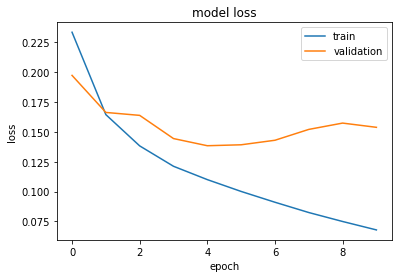

In [11]:
PlotLoss(history)

### <u>Observation</u>: I am getting a very similar performance in terms of validation loss with and without using dropout

### [8.3] Using sequential model with 2 LSTM layers without dropout

In [47]:
top_words = 5001
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100, input_shape=(max_review_length,1), return_sequences=True))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_9 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 293,733
Trainable params: 293,733
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
model.fit(X_train, y_train, nb_epoch=10, batch_size=64)

Epoch 1/10
254228/254228 [==============================] - 5385s 21ms/step - loss: 0.2063 - acc: 0.9188
Epoch 2/10
254228/254228 [==============================] - 5501s 22ms/step - loss: 0.1429 - acc: 0.9444
Epoch 3/10
254228/254228 [==============================] - 5279s 21ms/step - loss: 0.1196 - acc: 0.9536
Epoch 4/10
254228/254228 [==============================] - 5201s 20ms/step - loss: 0.1067 - acc: 0.9590
Epoch 5/10
254228/254228 [==============================] - 5234s 21ms/step - loss: 0.0972 - acc: 0.9629
Epoch 6/10
254228/254228 [==============================] - 5215s 21ms/step - loss: 0.0885 - acc: 0.9667
Epoch 7/10
254228/254228 [==============================] - 5209s 20ms/step - loss: 0.0803 - acc: 0.9701
Epoch 8/10
254228/254228 [==============================] - 5201s 20ms/step - loss: 0.0718 - acc: 0.9739
Epoch 9/10
254228/254228 [==============================] - 5361s 21ms/step - loss: 0.0639 - acc: 0.9770
Epoch 10/10
254228/254228 [============================

In [50]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 94.59%


### [8.4] Using sequential model with 2 LSTM layers with high dropout

In [12]:
top_words = 5001
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100, input_shape=(max_review_length,1), return_sequences=True))
model.add(Dropout(0.8))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.8))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_2 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 600, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 293,733
Trainable params: 293,733
Non-trainable params: 0
_________________________________________________________________
None

In [13]:
history = model.fit(X_train, y_train, nb_epoch=10, batch_size=64, validation_data=(X_test, y_test))

Train on 254228 samples, validate on 108956 samples
Epoch 1/10
254228/254228 [==============================] - 6040s 24ms/step - loss: 0.2221 - acc: 0.9152 - val_loss: 0.1897 - val_acc: 0.9257
Epoch 2/10
254228/254228 [==============================] - 6110s 24ms/step - loss: 0.1563 - acc: 0.9416 - val_loss: 0.1553 - val_acc: 0.9360
Epoch 3/10
254228/254228 [==============================] - 6716s 26ms/step - loss: 0.1327 - acc: 0.9506 - val_loss: 0.1439 - val_acc: 0.9455
Epoch 4/10
254228/254228 [==============================] - 6634s 26ms/step - loss: 0.1192 - acc: 0.9559 - val_loss: 0.1357 - val_acc: 0.9484
Epoch 5/10
254228/254228 [==============================] - 6402s 25ms/step - loss: 0.1086 - acc: 0.9599 - val_loss: 0.1358 - val_acc: 0.9471
Epoch 6/10
254228/254228 [==============================] - 6341s 25ms/step - loss: 0.1014 - acc: 0.9629 - val_loss: 0.1370 - val_acc: 0.9494
Epoch 7/10
254228/254228 [==============================] - 6345s 25ms/step - loss: 0.0960 - acc

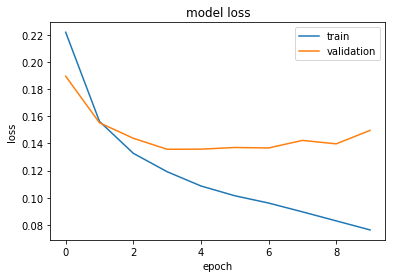

In [14]:
PlotLoss(history)

In [15]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 94.71%


#### <u>Observation</u>: While using 2 layer LSTM with higher dropout, we observe a very minor improvement in performance as compared to the the 2 layer LSTM model where I am not using dropout

#  [8.5] Summary

In [17]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["LSTM Layers","Dropout", "Accuracy"]
x.add_row([1,0, 94.64])
x.add_row([1,0.5, 94.69])
x.add_row([2,0, 94.59])
x.add_row([2,0.8, 94.71])
print("Results for LSTM")
print(x)

Results for LSTM
+-------------+---------+----------+
| LSTM Layers | Dropout | Accuracy |
+-------------+---------+----------+
|      1      |    0    |  94.64   |
|      1      |   0.5   |  94.69   |
|      2      |    0    |  94.59   |
|      2      |   0.8   |  94.71   |
+-------------+---------+----------+
